In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(8749832, 828)
(8749832, 8)
validation
(1260688, 828)
(1260688, 8)
test
(987784, 828)
(987784, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/875 [..............................] - ETA: 24:45 - loss: 2.2383 - STD: 0.0618 - MAE: 0.2203

  4/875 [..............................] - ETA: 19s - loss: 2.1138 - STD: 0.0428 - MAE: 0.2177  

  7/875 [..............................] - ETA: 19s - loss: 2.1045 - STD: 0.0535 - MAE: 0.2165

 10/875 [..............................] - ETA: 19s - loss: 2.0917 - STD: 0.0494 - MAE: 0.2164

 13/875 [..............................] - ETA: 19s - loss: 2.0825 - STD: 0.0446 - MAE: 0.2165

 16/875 [..............................] - ETA: 19s - loss: 2.0776 - STD: 0.0415 - MAE: 0.2166

 19/875 [..............................] - ETA: 19s - loss: 2.0736 - STD: 0.0391 - MAE: 0.2167

 22/875 [..............................] - ETA: 19s - loss: 2.0692 - STD: 0.0377 - MAE: 0.2167

 25/875 [..............................] - ETA: 19s - loss: 2.0655 - STD: 0.0375 - MAE: 0.2166

 28/875 [..............................] - ETA: 19s - loss: 2.0608 - STD: 0.0377 - MAE: 0.2165

 31/875 [>.............................] - ETA: 18s - loss: 2.0552 - STD: 0.0378 - MAE: 0.2163

 34/875 [>.............................] - ETA: 18s - loss: 2.0482 - STD: 0.0378 - MAE: 0.2161

 37/875 [>.............................] - ETA: 18s - loss: 2.0394 - STD: 0.0382 - MAE: 0.2158

 40/875 [>.............................] - ETA: 18s - loss: 2.0291 - STD: 0.0393 - MAE: 0.2154

 43/875 [>.............................] - ETA: 18s - loss: 2.0177 - STD: 0.0411 - MAE: 0.2149

 46/875 [>.............................] - ETA: 18s - loss: 2.0056 - STD: 0.0433 - MAE: 0.2143

 49/875 [>.............................] - ETA: 18s - loss: 1.9933 - STD: 0.0454 - MAE: 0.2137

 52/875 [>.............................] - ETA: 18s - loss: 1.9807 - STD: 0.0474 - MAE: 0.2131

 55/875 [>.............................] - ETA: 18s - loss: 1.9672 - STD: 0.0495 - MAE: 0.2124

 58/875 [>.............................] - ETA: 18s - loss: 1.9527 - STD: 0.0516 - MAE: 0.2116

 61/875 [=>............................] - ETA: 18s - loss: 1.9377 - STD: 0.0536 - MAE: 0.2109

 64/875 [=>............................] - ETA: 18s - loss: 1.9220 - STD: 0.0559 - MAE: 0.2100

 67/875 [=>............................] - ETA: 18s - loss: 1.9067 - STD: 0.0584 - MAE: 0.2091

 70/875 [=>............................] - ETA: 18s - loss: 1.8915 - STD: 0.0609 - MAE: 0.2082

 73/875 [=>............................] - ETA: 18s - loss: 1.8765 - STD: 0.0634 - MAE: 0.2073

 76/875 [=>............................] - ETA: 18s - loss: 1.8625 - STD: 0.0658 - MAE: 0.2064

 79/875 [=>............................] - ETA: 17s - loss: 1.8488 - STD: 0.0681 - MAE: 0.2055

 82/875 [=>............................] - ETA: 17s - loss: 1.8353 - STD: 0.0704 - MAE: 0.2046

 85/875 [=>............................] - ETA: 17s - loss: 1.8222 - STD: 0.0726 - MAE: 0.2038

 88/875 [==>...........................] - ETA: 17s - loss: 1.8096 - STD: 0.0747 - MAE: 0.2029

 91/875 [==>...........................] - ETA: 17s - loss: 1.7973 - STD: 0.0767 - MAE: 0.2021

 94/875 [==>...........................] - ETA: 17s - loss: 1.7854 - STD: 0.0787 - MAE: 0.2013

 97/875 [==>...........................] - ETA: 17s - loss: 1.7740 - STD: 0.0807 - MAE: 0.2005

100/875 [==>...........................] - ETA: 17s - loss: 1.7627 - STD: 0.0826 - MAE: 0.1997

103/875 [==>...........................] - ETA: 17s - loss: 1.7517 - STD: 0.0845 - MAE: 0.1989

106/875 [==>...........................] - ETA: 17s - loss: 1.7412 - STD: 0.0863 - MAE: 0.1981

109/875 [==>...........................] - ETA: 17s - loss: 1.7312 - STD: 0.0881 - MAE: 0.1974

112/875 [==>...........................] - ETA: 17s - loss: 1.7214 - STD: 0.0898 - MAE: 0.1966

115/875 [==>...........................] - ETA: 17s - loss: 1.7118 - STD: 0.0914 - MAE: 0.1959

118/875 [===>..........................] - ETA: 17s - loss: 1.7027 - STD: 0.0930 - MAE: 0.1952

121/875 [===>..........................] - ETA: 16s - loss: 1.6941 - STD: 0.0946 - MAE: 0.1946

124/875 [===>..........................] - ETA: 16s - loss: 1.6858 - STD: 0.0960 - MAE: 0.1939

127/875 [===>..........................] - ETA: 16s - loss: 1.6776 - STD: 0.0975 - MAE: 0.1933

130/875 [===>..........................] - ETA: 16s - loss: 1.6697 - STD: 0.0988 - MAE: 0.1927

133/875 [===>..........................] - ETA: 16s - loss: 1.6619 - STD: 0.1002 - MAE: 0.1921

136/875 [===>..........................] - ETA: 16s - loss: 1.6544 - STD: 0.1015 - MAE: 0.1915

139/875 [===>..........................] - ETA: 16s - loss: 1.6472 - STD: 0.1028 - MAE: 0.1909

142/875 [===>..........................] - ETA: 16s - loss: 1.6403 - STD: 0.1040 - MAE: 0.1904

145/875 [===>..........................] - ETA: 16s - loss: 1.6337 - STD: 0.1052 - MAE: 0.1898

148/875 [====>.........................] - ETA: 16s - loss: 1.6273 - STD: 0.1063 - MAE: 0.1893

151/875 [====>.........................] - ETA: 16s - loss: 1.6211 - STD: 0.1075 - MAE: 0.1888

154/875 [====>.........................] - ETA: 16s - loss: 1.6150 - STD: 0.1085 - MAE: 0.1884

157/875 [====>.........................] - ETA: 16s - loss: 1.6092 - STD: 0.1095 - MAE: 0.1879

160/875 [====>.........................] - ETA: 16s - loss: 1.6034 - STD: 0.1105 - MAE: 0.1874

163/875 [====>.........................] - ETA: 16s - loss: 1.5977 - STD: 0.1115 - MAE: 0.1870

166/875 [====>.........................] - ETA: 15s - loss: 1.5921 - STD: 0.1125 - MAE: 0.1865

169/875 [====>.........................] - ETA: 15s - loss: 1.5868 - STD: 0.1135 - MAE: 0.1861

172/875 [====>.........................] - ETA: 15s - loss: 1.5818 - STD: 0.1144 - MAE: 0.1857

175/875 [=====>........................] - ETA: 15s - loss: 1.5767 - STD: 0.1153 - MAE: 0.1853

178/875 [=====>........................] - ETA: 15s - loss: 1.5719 - STD: 0.1161 - MAE: 0.1849

181/875 [=====>........................] - ETA: 15s - loss: 1.5670 - STD: 0.1169 - MAE: 0.1845

184/875 [=====>........................] - ETA: 15s - loss: 1.5625 - STD: 0.1178 - MAE: 0.1841

187/875 [=====>........................] - ETA: 15s - loss: 1.5579 - STD: 0.1186 - MAE: 0.1837

190/875 [=====>........................] - ETA: 15s - loss: 1.5536 - STD: 0.1193 - MAE: 0.1834

193/875 [=====>........................] - ETA: 15s - loss: 1.5491 - STD: 0.1201 - MAE: 0.1830

196/875 [=====>........................] - ETA: 15s - loss: 1.5448 - STD: 0.1208 - MAE: 0.1827

199/875 [=====>........................] - ETA: 15s - loss: 1.5406 - STD: 0.1216 - MAE: 0.1823

202/875 [=====>........................] - ETA: 15s - loss: 1.5366 - STD: 0.1223 - MAE: 0.1820

205/875 [======>.......................] - ETA: 15s - loss: 1.5326 - STD: 0.1230 - MAE: 0.1816

208/875 [======>.......................] - ETA: 15s - loss: 1.5290 - STD: 0.1237 - MAE: 0.1813

211/875 [======>.......................] - ETA: 14s - loss: 1.5253 - STD: 0.1243 - MAE: 0.1810

214/875 [======>.......................] - ETA: 14s - loss: 1.5218 - STD: 0.1250 - MAE: 0.1807

217/875 [======>.......................] - ETA: 14s - loss: 1.5183 - STD: 0.1256 - MAE: 0.1804

220/875 [======>.......................] - ETA: 14s - loss: 1.5148 - STD: 0.1262 - MAE: 0.1801

223/875 [======>.......................] - ETA: 14s - loss: 1.5116 - STD: 0.1268 - MAE: 0.1799

226/875 [======>.......................] - ETA: 14s - loss: 1.5082 - STD: 0.1274 - MAE: 0.1796

229/875 [======>.......................] - ETA: 14s - loss: 1.5048 - STD: 0.1280 - MAE: 0.1793

232/875 [======>.......................] - ETA: 14s - loss: 1.5017 - STD: 0.1286 - MAE: 0.1790

235/875 [=======>......................] - ETA: 14s - loss: 1.4986 - STD: 0.1291 - MAE: 0.1788

238/875 [=======>......................] - ETA: 14s - loss: 1.4957 - STD: 0.1297 - MAE: 0.1785

241/875 [=======>......................] - ETA: 14s - loss: 1.4926 - STD: 0.1302 - MAE: 0.1783

244/875 [=======>......................] - ETA: 14s - loss: 1.4895 - STD: 0.1307 - MAE: 0.1780

247/875 [=======>......................] - ETA: 14s - loss: 1.4866 - STD: 0.1312 - MAE: 0.1778

250/875 [=======>......................] - ETA: 14s - loss: 1.4837 - STD: 0.1317 - MAE: 0.1775

253/875 [=======>......................] - ETA: 14s - loss: 1.4809 - STD: 0.1322 - MAE: 0.1773

256/875 [=======>......................] - ETA: 13s - loss: 1.4781 - STD: 0.1327 - MAE: 0.1770

259/875 [=======>......................] - ETA: 13s - loss: 1.4754 - STD: 0.1331 - MAE: 0.1768

262/875 [=======>......................] - ETA: 13s - loss: 1.4727 - STD: 0.1336 - MAE: 0.1766

265/875 [========>.....................] - ETA: 13s - loss: 1.4700 - STD: 0.1341 - MAE: 0.1764

268/875 [========>.....................] - ETA: 13s - loss: 1.4674 - STD: 0.1345 - MAE: 0.1761

271/875 [========>.....................] - ETA: 13s - loss: 1.4648 - STD: 0.1350 - MAE: 0.1759

274/875 [========>.....................] - ETA: 13s - loss: 1.4621 - STD: 0.1354 - MAE: 0.1757

277/875 [========>.....................] - ETA: 13s - loss: 1.4597 - STD: 0.1358 - MAE: 0.1755

280/875 [========>.....................] - ETA: 13s - loss: 1.4572 - STD: 0.1363 - MAE: 0.1753

283/875 [========>.....................] - ETA: 13s - loss: 1.4547 - STD: 0.1367 - MAE: 0.1750

286/875 [========>.....................] - ETA: 13s - loss: 1.4524 - STD: 0.1371 - MAE: 0.1748

289/875 [========>.....................] - ETA: 13s - loss: 1.4500 - STD: 0.1375 - MAE: 0.1746

292/875 [=========>....................] - ETA: 13s - loss: 1.4476 - STD: 0.1379 - MAE: 0.1744

295/875 [=========>....................] - ETA: 13s - loss: 1.4453 - STD: 0.1383 - MAE: 0.1742

298/875 [=========>....................] - ETA: 13s - loss: 1.4431 - STD: 0.1387 - MAE: 0.1740

301/875 [=========>....................] - ETA: 12s - loss: 1.4408 - STD: 0.1391 - MAE: 0.1738

302/875 [=========>....................] - ETA: 14s - loss: 1.4401 - STD: 0.1392 - MAE: 0.1738

305/875 [=========>....................] - ETA: 14s - loss: 1.4378 - STD: 0.1396 - MAE: 0.1736

308/875 [=========>....................] - ETA: 14s - loss: 1.4357 - STD: 0.1400 - MAE: 0.1734

311/875 [=========>....................] - ETA: 14s - loss: 1.4337 - STD: 0.1404 - MAE: 0.1732

314/875 [=========>....................] - ETA: 14s - loss: 1.4316 - STD: 0.1407 - MAE: 0.1730

317/875 [=========>....................] - ETA: 14s - loss: 1.4295 - STD: 0.1411 - MAE: 0.1728

320/875 [=========>....................] - ETA: 14s - loss: 1.4275 - STD: 0.1414 - MAE: 0.1726

323/875 [==========>...................] - ETA: 14s - loss: 1.4256 - STD: 0.1418 - MAE: 0.1725

326/875 [==========>...................] - ETA: 14s - loss: 1.4237 - STD: 0.1421 - MAE: 0.1723

329/875 [==========>...................] - ETA: 14s - loss: 1.4217 - STD: 0.1425 - MAE: 0.1721

332/875 [==========>...................] - ETA: 14s - loss: 1.4197 - STD: 0.1428 - MAE: 0.1719

335/875 [==========>...................] - ETA: 13s - loss: 1.4178 - STD: 0.1431 - MAE: 0.1718

338/875 [==========>...................] - ETA: 13s - loss: 1.4158 - STD: 0.1434 - MAE: 0.1716

341/875 [==========>...................] - ETA: 13s - loss: 1.4140 - STD: 0.1438 - MAE: 0.1714

344/875 [==========>...................] - ETA: 13s - loss: 1.4121 - STD: 0.1441 - MAE: 0.1713

347/875 [==========>...................] - ETA: 13s - loss: 1.4102 - STD: 0.1444 - MAE: 0.1711

350/875 [===========>..................] - ETA: 13s - loss: 1.4083 - STD: 0.1447 - MAE: 0.1709

353/875 [===========>..................] - ETA: 13s - loss: 1.4064 - STD: 0.1450 - MAE: 0.1708

356/875 [===========>..................] - ETA: 13s - loss: 1.4046 - STD: 0.1453 - MAE: 0.1706

359/875 [===========>..................] - ETA: 13s - loss: 1.4028 - STD: 0.1456 - MAE: 0.1704

362/875 [===========>..................] - ETA: 13s - loss: 1.4011 - STD: 0.1459 - MAE: 0.1703

365/875 [===========>..................] - ETA: 13s - loss: 1.3993 - STD: 0.1462 - MAE: 0.1701

368/875 [===========>..................] - ETA: 12s - loss: 1.3976 - STD: 0.1465 - MAE: 0.1700

371/875 [===========>..................] - ETA: 12s - loss: 1.3959 - STD: 0.1468 - MAE: 0.1698

374/875 [===========>..................] - ETA: 12s - loss: 1.3941 - STD: 0.1471 - MAE: 0.1697

377/875 [===========>..................] - ETA: 12s - loss: 1.3925 - STD: 0.1474 - MAE: 0.1695

380/875 [============>.................] - ETA: 12s - loss: 1.3908 - STD: 0.1477 - MAE: 0.1694

383/875 [============>.................] - ETA: 12s - loss: 1.3891 - STD: 0.1479 - MAE: 0.1692

386/875 [============>.................] - ETA: 12s - loss: 1.3875 - STD: 0.1482 - MAE: 0.1691

389/875 [============>.................] - ETA: 12s - loss: 1.3859 - STD: 0.1485 - MAE: 0.1689

392/875 [============>.................] - ETA: 12s - loss: 1.3843 - STD: 0.1488 - MAE: 0.1688

395/875 [============>.................] - ETA: 12s - loss: 1.3828 - STD: 0.1490 - MAE: 0.1686

398/875 [============>.................] - ETA: 12s - loss: 1.3813 - STD: 0.1493 - MAE: 0.1685

401/875 [============>.................] - ETA: 11s - loss: 1.3797 - STD: 0.1495 - MAE: 0.1683

404/875 [============>.................] - ETA: 11s - loss: 1.3785 - STD: 0.1498 - MAE: 0.1682

407/875 [============>.................] - ETA: 11s - loss: 1.3771 - STD: 0.1501 - MAE: 0.1681

410/875 [=============>................] - ETA: 11s - loss: 1.3756 - STD: 0.1503 - MAE: 0.1680

413/875 [=============>................] - ETA: 11s - loss: 1.3741 - STD: 0.1505 - MAE: 0.1678

416/875 [=============>................] - ETA: 11s - loss: 1.3727 - STD: 0.1508 - MAE: 0.1677

419/875 [=============>................] - ETA: 11s - loss: 1.3712 - STD: 0.1510 - MAE: 0.1676

422/875 [=============>................] - ETA: 11s - loss: 1.3698 - STD: 0.1513 - MAE: 0.1674

425/875 [=============>................] - ETA: 11s - loss: 1.3684 - STD: 0.1515 - MAE: 0.1673

428/875 [=============>................] - ETA: 11s - loss: 1.3670 - STD: 0.1517 - MAE: 0.1672

431/875 [=============>................] - ETA: 11s - loss: 1.3656 - STD: 0.1520 - MAE: 0.1670

434/875 [=============>................] - ETA: 11s - loss: 1.3641 - STD: 0.1522 - MAE: 0.1669

437/875 [=============>................] - ETA: 10s - loss: 1.3630 - STD: 0.1524 - MAE: 0.1668

440/875 [==============>...............] - ETA: 10s - loss: 1.3617 - STD: 0.1527 - MAE: 0.1667

443/875 [==============>...............] - ETA: 10s - loss: 1.3604 - STD: 0.1529 - MAE: 0.1665

446/875 [==============>...............] - ETA: 10s - loss: 1.3591 - STD: 0.1531 - MAE: 0.1664

449/875 [==============>...............] - ETA: 10s - loss: 1.3578 - STD: 0.1533 - MAE: 0.1663

452/875 [==============>...............] - ETA: 10s - loss: 1.3564 - STD: 0.1536 - MAE: 0.1662

455/875 [==============>...............] - ETA: 10s - loss: 1.3552 - STD: 0.1538 - MAE: 0.1661

458/875 [==============>...............] - ETA: 10s - loss: 1.3539 - STD: 0.1540 - MAE: 0.1659

461/875 [==============>...............] - ETA: 10s - loss: 1.3526 - STD: 0.1542 - MAE: 0.1658

464/875 [==============>...............] - ETA: 10s - loss: 1.3514 - STD: 0.1544 - MAE: 0.1657

467/875 [===============>..............] - ETA: 10s - loss: 1.3501 - STD: 0.1546 - MAE: 0.1656

470/875 [===============>..............] - ETA: 10s - loss: 1.3489 - STD: 0.1548 - MAE: 0.1655

473/875 [===============>..............] - ETA: 9s - loss: 1.3477 - STD: 0.1550 - MAE: 0.1654 

476/875 [===============>..............] - ETA: 9s - loss: 1.3466 - STD: 0.1552 - MAE: 0.1652

479/875 [===============>..............] - ETA: 9s - loss: 1.3454 - STD: 0.1554 - MAE: 0.1651

482/875 [===============>..............] - ETA: 9s - loss: 1.3443 - STD: 0.1556 - MAE: 0.1650

485/875 [===============>..............] - ETA: 9s - loss: 1.3431 - STD: 0.1558 - MAE: 0.1649

488/875 [===============>..............] - ETA: 9s - loss: 1.3419 - STD: 0.1560 - MAE: 0.1648

491/875 [===============>..............] - ETA: 9s - loss: 1.3407 - STD: 0.1562 - MAE: 0.1647

494/875 [===============>..............] - ETA: 9s - loss: 1.3395 - STD: 0.1564 - MAE: 0.1646

497/875 [================>.............] - ETA: 9s - loss: 1.3384 - STD: 0.1566 - MAE: 0.1645

500/875 [================>.............] - ETA: 9s - loss: 1.3372 - STD: 0.1568 - MAE: 0.1644

503/875 [================>.............] - ETA: 9s - loss: 1.3362 - STD: 0.1570 - MAE: 0.1643

506/875 [================>.............] - ETA: 9s - loss: 1.3350 - STD: 0.1572 - MAE: 0.1642

509/875 [================>.............] - ETA: 9s - loss: 1.3339 - STD: 0.1574 - MAE: 0.1641

512/875 [================>.............] - ETA: 8s - loss: 1.3328 - STD: 0.1576 - MAE: 0.1639

515/875 [================>.............] - ETA: 8s - loss: 1.3317 - STD: 0.1577 - MAE: 0.1638

518/875 [================>.............] - ETA: 8s - loss: 1.3306 - STD: 0.1579 - MAE: 0.1637

521/875 [================>.............] - ETA: 8s - loss: 1.3296 - STD: 0.1581 - MAE: 0.1636

524/875 [================>.............] - ETA: 8s - loss: 1.3285 - STD: 0.1583 - MAE: 0.1635

527/875 [=================>............] - ETA: 8s - loss: 1.3275 - STD: 0.1585 - MAE: 0.1634

530/875 [=================>............] - ETA: 8s - loss: 1.3264 - STD: 0.1586 - MAE: 0.1633

533/875 [=================>............] - ETA: 8s - loss: 1.3254 - STD: 0.1588 - MAE: 0.1632

536/875 [=================>............] - ETA: 8s - loss: 1.3243 - STD: 0.1590 - MAE: 0.1631

539/875 [=================>............] - ETA: 8s - loss: 1.3232 - STD: 0.1591 - MAE: 0.1630

542/875 [=================>............] - ETA: 8s - loss: 1.3222 - STD: 0.1593 - MAE: 0.1629

545/875 [=================>............] - ETA: 8s - loss: 1.3212 - STD: 0.1595 - MAE: 0.1628

548/875 [=================>............] - ETA: 8s - loss: 1.3202 - STD: 0.1597 - MAE: 0.1627

551/875 [=================>............] - ETA: 7s - loss: 1.3194 - STD: 0.1598 - MAE: 0.1627

554/875 [=================>............] - ETA: 7s - loss: 1.3185 - STD: 0.1600 - MAE: 0.1626

557/875 [==================>...........] - ETA: 7s - loss: 1.3176 - STD: 0.1601 - MAE: 0.1625

560/875 [==================>...........] - ETA: 7s - loss: 1.3167 - STD: 0.1603 - MAE: 0.1624

563/875 [==================>...........] - ETA: 7s - loss: 1.3158 - STD: 0.1605 - MAE: 0.1623

566/875 [==================>...........] - ETA: 7s - loss: 1.3149 - STD: 0.1606 - MAE: 0.1622

569/875 [==================>...........] - ETA: 7s - loss: 1.3140 - STD: 0.1608 - MAE: 0.1621

572/875 [==================>...........] - ETA: 7s - loss: 1.3131 - STD: 0.1609 - MAE: 0.1621

575/875 [==================>...........] - ETA: 7s - loss: 1.3121 - STD: 0.1611 - MAE: 0.1620

578/875 [==================>...........] - ETA: 7s - loss: 1.3112 - STD: 0.1612 - MAE: 0.1619

581/875 [==================>...........] - ETA: 7s - loss: 1.3103 - STD: 0.1614 - MAE: 0.1618

584/875 [===================>..........] - ETA: 7s - loss: 1.3093 - STD: 0.1615 - MAE: 0.1617

587/875 [===================>..........] - ETA: 7s - loss: 1.3083 - STD: 0.1617 - MAE: 0.1616

590/875 [===================>..........] - ETA: 6s - loss: 1.3074 - STD: 0.1618 - MAE: 0.1615

593/875 [===================>..........] - ETA: 6s - loss: 1.3065 - STD: 0.1620 - MAE: 0.1614

596/875 [===================>..........] - ETA: 6s - loss: 1.3057 - STD: 0.1621 - MAE: 0.1614

599/875 [===================>..........] - ETA: 6s - loss: 1.3048 - STD: 0.1623 - MAE: 0.1613

602/875 [===================>..........] - ETA: 6s - loss: 1.3038 - STD: 0.1624 - MAE: 0.1612

605/875 [===================>..........] - ETA: 6s - loss: 1.3029 - STD: 0.1626 - MAE: 0.1611

608/875 [===================>..........] - ETA: 6s - loss: 1.3020 - STD: 0.1627 - MAE: 0.1610

611/875 [===================>..........] - ETA: 6s - loss: 1.3010 - STD: 0.1628 - MAE: 0.1609

614/875 [====================>.........] - ETA: 6s - loss: 1.3001 - STD: 0.1630 - MAE: 0.1608

617/875 [====================>.........] - ETA: 6s - loss: 1.2992 - STD: 0.1631 - MAE: 0.1607

620/875 [====================>.........] - ETA: 6s - loss: 1.2984 - STD: 0.1633 - MAE: 0.1607

623/875 [====================>.........] - ETA: 6s - loss: 1.2975 - STD: 0.1634 - MAE: 0.1606

626/875 [====================>.........] - ETA: 6s - loss: 1.2966 - STD: 0.1636 - MAE: 0.1605

629/875 [====================>.........] - ETA: 5s - loss: 1.2958 - STD: 0.1637 - MAE: 0.1604

632/875 [====================>.........] - ETA: 5s - loss: 1.2949 - STD: 0.1638 - MAE: 0.1603

635/875 [====================>.........] - ETA: 5s - loss: 1.2940 - STD: 0.1640 - MAE: 0.1602

638/875 [====================>.........] - ETA: 5s - loss: 1.2932 - STD: 0.1641 - MAE: 0.1602

641/875 [====================>.........] - ETA: 5s - loss: 1.2924 - STD: 0.1642 - MAE: 0.1601

644/875 [=====================>........] - ETA: 5s - loss: 1.2915 - STD: 0.1644 - MAE: 0.1600

647/875 [=====================>........] - ETA: 5s - loss: 1.2908 - STD: 0.1645 - MAE: 0.1599

650/875 [=====================>........] - ETA: 5s - loss: 1.2899 - STD: 0.1646 - MAE: 0.1598

653/875 [=====================>........] - ETA: 5s - loss: 1.2891 - STD: 0.1648 - MAE: 0.1598

656/875 [=====================>........] - ETA: 5s - loss: 1.2883 - STD: 0.1649 - MAE: 0.1597

659/875 [=====================>........] - ETA: 5s - loss: 1.2875 - STD: 0.1651 - MAE: 0.1596

662/875 [=====================>........] - ETA: 5s - loss: 1.2867 - STD: 0.1652 - MAE: 0.1595

665/875 [=====================>........] - ETA: 5s - loss: 1.2859 - STD: 0.1653 - MAE: 0.1595

668/875 [=====================>........] - ETA: 5s - loss: 1.2851 - STD: 0.1654 - MAE: 0.1594

671/875 [======================>.......] - ETA: 4s - loss: 1.2843 - STD: 0.1656 - MAE: 0.1593

674/875 [======================>.......] - ETA: 4s - loss: 1.2835 - STD: 0.1657 - MAE: 0.1592

677/875 [======================>.......] - ETA: 4s - loss: 1.2828 - STD: 0.1658 - MAE: 0.1591

680/875 [======================>.......] - ETA: 4s - loss: 1.2819 - STD: 0.1660 - MAE: 0.1591

683/875 [======================>.......] - ETA: 4s - loss: 1.2811 - STD: 0.1661 - MAE: 0.1590

686/875 [======================>.......] - ETA: 4s - loss: 1.2804 - STD: 0.1662 - MAE: 0.1589

689/875 [======================>.......] - ETA: 4s - loss: 1.2797 - STD: 0.1663 - MAE: 0.1588

692/875 [======================>.......] - ETA: 4s - loss: 1.2790 - STD: 0.1665 - MAE: 0.1588

695/875 [======================>.......] - ETA: 4s - loss: 1.2781 - STD: 0.1666 - MAE: 0.1587

698/875 [======================>.......] - ETA: 4s - loss: 1.2774 - STD: 0.1667 - MAE: 0.1586

701/875 [=======================>......] - ETA: 4s - loss: 1.2768 - STD: 0.1668 - MAE: 0.1586

704/875 [=======================>......] - ETA: 4s - loss: 1.2760 - STD: 0.1669 - MAE: 0.1585

707/875 [=======================>......] - ETA: 4s - loss: 1.2754 - STD: 0.1671 - MAE: 0.1584

710/875 [=======================>......] - ETA: 3s - loss: 1.2748 - STD: 0.1672 - MAE: 0.1583

713/875 [=======================>......] - ETA: 3s - loss: 1.2741 - STD: 0.1673 - MAE: 0.1583

716/875 [=======================>......] - ETA: 3s - loss: 1.2734 - STD: 0.1674 - MAE: 0.1582

719/875 [=======================>......] - ETA: 3s - loss: 1.2727 - STD: 0.1675 - MAE: 0.1581

722/875 [=======================>......] - ETA: 3s - loss: 1.2720 - STD: 0.1676 - MAE: 0.1581

725/875 [=======================>......] - ETA: 3s - loss: 1.2713 - STD: 0.1678 - MAE: 0.1580

728/875 [=======================>......] - ETA: 3s - loss: 1.2706 - STD: 0.1679 - MAE: 0.1579

731/875 [========================>.....] - ETA: 3s - loss: 1.2700 - STD: 0.1680 - MAE: 0.1579

734/875 [========================>.....] - ETA: 3s - loss: 1.2693 - STD: 0.1681 - MAE: 0.1578

737/875 [========================>.....] - ETA: 3s - loss: 1.2686 - STD: 0.1682 - MAE: 0.1577

740/875 [========================>.....] - ETA: 3s - loss: 1.2679 - STD: 0.1683 - MAE: 0.1577

743/875 [========================>.....] - ETA: 3s - loss: 1.2672 - STD: 0.1684 - MAE: 0.1576

746/875 [========================>.....] - ETA: 3s - loss: 1.2666 - STD: 0.1685 - MAE: 0.1575

749/875 [========================>.....] - ETA: 3s - loss: 1.2659 - STD: 0.1686 - MAE: 0.1575

752/875 [========================>.....] - ETA: 2s - loss: 1.2652 - STD: 0.1687 - MAE: 0.1574

755/875 [========================>.....] - ETA: 2s - loss: 1.2645 - STD: 0.1689 - MAE: 0.1573

758/875 [========================>.....] - ETA: 2s - loss: 1.2638 - STD: 0.1690 - MAE: 0.1573

761/875 [=========================>....] - ETA: 2s - loss: 1.2632 - STD: 0.1691 - MAE: 0.1572

764/875 [=========================>....] - ETA: 2s - loss: 1.2626 - STD: 0.1692 - MAE: 0.1571

767/875 [=========================>....] - ETA: 2s - loss: 1.2620 - STD: 0.1693 - MAE: 0.1571

770/875 [=========================>....] - ETA: 2s - loss: 1.2614 - STD: 0.1694 - MAE: 0.1570

773/875 [=========================>....] - ETA: 2s - loss: 1.2608 - STD: 0.1695 - MAE: 0.1570

776/875 [=========================>....] - ETA: 2s - loss: 1.2602 - STD: 0.1696 - MAE: 0.1569

779/875 [=========================>....] - ETA: 2s - loss: 1.2596 - STD: 0.1697 - MAE: 0.1568

782/875 [=========================>....] - ETA: 2s - loss: 1.2589 - STD: 0.1698 - MAE: 0.1568

785/875 [=========================>....] - ETA: 2s - loss: 1.2582 - STD: 0.1699 - MAE: 0.1567

788/875 [==========================>...] - ETA: 2s - loss: 1.2575 - STD: 0.1700 - MAE: 0.1566

791/875 [==========================>...] - ETA: 2s - loss: 1.2569 - STD: 0.1701 - MAE: 0.1566

794/875 [==========================>...] - ETA: 1s - loss: 1.2562 - STD: 0.1702 - MAE: 0.1565

797/875 [==========================>...] - ETA: 1s - loss: 1.2556 - STD: 0.1703 - MAE: 0.1565

800/875 [==========================>...] - ETA: 1s - loss: 1.2550 - STD: 0.1704 - MAE: 0.1564

803/875 [==========================>...] - ETA: 1s - loss: 1.2543 - STD: 0.1705 - MAE: 0.1563

806/875 [==========================>...] - ETA: 1s - loss: 1.2537 - STD: 0.1706 - MAE: 0.1563

809/875 [==========================>...] - ETA: 1s - loss: 1.2531 - STD: 0.1707 - MAE: 0.1562

812/875 [==========================>...] - ETA: 1s - loss: 1.2525 - STD: 0.1708 - MAE: 0.1561

815/875 [==========================>...] - ETA: 1s - loss: 1.2521 - STD: 0.1709 - MAE: 0.1561

818/875 [===========================>..] - ETA: 1s - loss: 1.2515 - STD: 0.1710 - MAE: 0.1560

821/875 [===========================>..] - ETA: 1s - loss: 1.2510 - STD: 0.1711 - MAE: 0.1560

824/875 [===========================>..] - ETA: 1s - loss: 1.2504 - STD: 0.1712 - MAE: 0.1559

827/875 [===========================>..] - ETA: 1s - loss: 1.2498 - STD: 0.1713 - MAE: 0.1559

830/875 [===========================>..] - ETA: 1s - loss: 1.2493 - STD: 0.1714 - MAE: 0.1558

833/875 [===========================>..] - ETA: 1s - loss: 1.2488 - STD: 0.1715 - MAE: 0.1558

836/875 [===========================>..] - ETA: 0s - loss: 1.2483 - STD: 0.1716 - MAE: 0.1557

839/875 [===========================>..] - ETA: 0s - loss: 1.2477 - STD: 0.1717 - MAE: 0.1556

842/875 [===========================>..] - ETA: 0s - loss: 1.2472 - STD: 0.1718 - MAE: 0.1556

845/875 [===========================>..] - ETA: 0s - loss: 1.2466 - STD: 0.1719 - MAE: 0.1555

848/875 [============================>.] - ETA: 0s - loss: 1.2461 - STD: 0.1719 - MAE: 0.1555

851/875 [============================>.] - ETA: 0s - loss: 1.2455 - STD: 0.1720 - MAE: 0.1554

854/875 [============================>.] - ETA: 0s - loss: 1.2450 - STD: 0.1721 - MAE: 0.1554

857/875 [============================>.] - ETA: 0s - loss: 1.2444 - STD: 0.1722 - MAE: 0.1553

860/875 [============================>.] - ETA: 0s - loss: 1.2438 - STD: 0.1723 - MAE: 0.1553

863/875 [============================>.] - ETA: 0s - loss: 1.2432 - STD: 0.1724 - MAE: 0.1552

866/875 [============================>.] - ETA: 0s - loss: 1.2426 - STD: 0.1725 - MAE: 0.1551

869/875 [============================>.] - ETA: 0s - loss: 1.2421 - STD: 0.1726 - MAE: 0.1551

872/875 [============================>.] - ETA: 0s - loss: 1.2415 - STD: 0.1727 - MAE: 0.1550

875/875 [==============================] - ETA: 0s - loss: 1.2409 - STD: 0.1727 - MAE: 0.1550

875/875 [==============================] - 25s 27ms/step - loss: 1.2409 - STD: 0.1727 - MAE: 0.1550 - val_loss: 1.0862 - val_STD: 0.1955 - val_MAE: 0.1400


Epoch 2/10000


  1/875 [..............................] - ETA: 44s - loss: 1.0914 - STD: 0.1988 - MAE: 0.1391

  4/875 [..............................] - ETA: 20s - loss: 1.0783 - STD: 0.1985 - MAE: 0.1387

  7/875 [..............................] - ETA: 19s - loss: 1.0759 - STD: 0.1983 - MAE: 0.1386

 10/875 [..............................] - ETA: 19s - loss: 1.0738 - STD: 0.1981 - MAE: 0.1387

 13/875 [..............................] - ETA: 19s - loss: 1.0717 - STD: 0.1984 - MAE: 0.1385

 16/875 [..............................] - ETA: 19s - loss: 1.0727 - STD: 0.1984 - MAE: 0.1385

 19/875 [..............................] - ETA: 19s - loss: 1.0716 - STD: 0.1986 - MAE: 0.1384

 22/875 [..............................] - ETA: 19s - loss: 1.0724 - STD: 0.1986 - MAE: 0.1385

 25/875 [..............................] - ETA: 19s - loss: 1.0753 - STD: 0.1987 - MAE: 0.1386

 28/875 [..............................] - ETA: 19s - loss: 1.0773 - STD: 0.1990 - MAE: 0.1386

 31/875 [>.............................] - ETA: 19s - loss: 1.0783 - STD: 0.1991 - MAE: 0.1386

 34/875 [>.............................] - ETA: 19s - loss: 1.0772 - STD: 0.1992 - MAE: 0.1386

 37/875 [>.............................] - ETA: 18s - loss: 1.0765 - STD: 0.1992 - MAE: 0.1385

 40/875 [>.............................] - ETA: 18s - loss: 1.0773 - STD: 0.1992 - MAE: 0.1386

 43/875 [>.............................] - ETA: 18s - loss: 1.0780 - STD: 0.1992 - MAE: 0.1386

 46/875 [>.............................] - ETA: 18s - loss: 1.0778 - STD: 0.1992 - MAE: 0.1386

 49/875 [>.............................] - ETA: 18s - loss: 1.0776 - STD: 0.1992 - MAE: 0.1386

 52/875 [>.............................] - ETA: 18s - loss: 1.0777 - STD: 0.1992 - MAE: 0.1386

 55/875 [>.............................] - ETA: 18s - loss: 1.0769 - STD: 0.1992 - MAE: 0.1385

 58/875 [>.............................] - ETA: 18s - loss: 1.0762 - STD: 0.1993 - MAE: 0.1385

 61/875 [=>............................] - ETA: 18s - loss: 1.0756 - STD: 0.1993 - MAE: 0.1384

 64/875 [=>............................] - ETA: 18s - loss: 1.0752 - STD: 0.1993 - MAE: 0.1384

 67/875 [=>............................] - ETA: 18s - loss: 1.0755 - STD: 0.1994 - MAE: 0.1384

 70/875 [=>............................] - ETA: 18s - loss: 1.0752 - STD: 0.1994 - MAE: 0.1384

 73/875 [=>............................] - ETA: 18s - loss: 1.0747 - STD: 0.1994 - MAE: 0.1383

 76/875 [=>............................] - ETA: 18s - loss: 1.0743 - STD: 0.1995 - MAE: 0.1383

 79/875 [=>............................] - ETA: 17s - loss: 1.0742 - STD: 0.1995 - MAE: 0.1383

 82/875 [=>............................] - ETA: 17s - loss: 1.0739 - STD: 0.1995 - MAE: 0.1382

 85/875 [=>............................] - ETA: 17s - loss: 1.0737 - STD: 0.1996 - MAE: 0.1382

 88/875 [==>...........................] - ETA: 17s - loss: 1.0736 - STD: 0.1996 - MAE: 0.1382

 91/875 [==>...........................] - ETA: 17s - loss: 1.0737 - STD: 0.1996 - MAE: 0.1382

 94/875 [==>...........................] - ETA: 17s - loss: 1.0751 - STD: 0.1997 - MAE: 0.1382

 97/875 [==>...........................] - ETA: 17s - loss: 1.0760 - STD: 0.1998 - MAE: 0.1382

100/875 [==>...........................] - ETA: 17s - loss: 1.0766 - STD: 0.1999 - MAE: 0.1383

103/875 [==>...........................] - ETA: 17s - loss: 1.0767 - STD: 0.1998 - MAE: 0.1383

106/875 [==>...........................] - ETA: 17s - loss: 1.0764 - STD: 0.1998 - MAE: 0.1383

109/875 [==>...........................] - ETA: 17s - loss: 1.0761 - STD: 0.1998 - MAE: 0.1382

112/875 [==>...........................] - ETA: 17s - loss: 1.0762 - STD: 0.1998 - MAE: 0.1382

115/875 [==>...........................] - ETA: 17s - loss: 1.0760 - STD: 0.1998 - MAE: 0.1382

118/875 [===>..........................] - ETA: 17s - loss: 1.0757 - STD: 0.1998 - MAE: 0.1382

121/875 [===>..........................] - ETA: 16s - loss: 1.0752 - STD: 0.1998 - MAE: 0.1382

124/875 [===>..........................] - ETA: 16s - loss: 1.0747 - STD: 0.1998 - MAE: 0.1382

127/875 [===>..........................] - ETA: 16s - loss: 1.0742 - STD: 0.1998 - MAE: 0.1381

130/875 [===>..........................] - ETA: 16s - loss: 1.0739 - STD: 0.1998 - MAE: 0.1381

133/875 [===>..........................] - ETA: 16s - loss: 1.0735 - STD: 0.1999 - MAE: 0.1381

136/875 [===>..........................] - ETA: 16s - loss: 1.0733 - STD: 0.1999 - MAE: 0.1381

139/875 [===>..........................] - ETA: 16s - loss: 1.0728 - STD: 0.1999 - MAE: 0.1380

142/875 [===>..........................] - ETA: 16s - loss: 1.0725 - STD: 0.1999 - MAE: 0.1380

145/875 [===>..........................] - ETA: 16s - loss: 1.0721 - STD: 0.1999 - MAE: 0.1380

148/875 [====>.........................] - ETA: 16s - loss: 1.0718 - STD: 0.2000 - MAE: 0.1379

151/875 [====>.........................] - ETA: 16s - loss: 1.0717 - STD: 0.2000 - MAE: 0.1379

154/875 [====>.........................] - ETA: 16s - loss: 1.0717 - STD: 0.2001 - MAE: 0.1379

157/875 [====>.........................] - ETA: 16s - loss: 1.0716 - STD: 0.2001 - MAE: 0.1379

160/875 [====>.........................] - ETA: 16s - loss: 1.0713 - STD: 0.2001 - MAE: 0.1379

163/875 [====>.........................] - ETA: 16s - loss: 1.0709 - STD: 0.2001 - MAE: 0.1378

166/875 [====>.........................] - ETA: 15s - loss: 1.0705 - STD: 0.2001 - MAE: 0.1378

169/875 [====>.........................] - ETA: 15s - loss: 1.0700 - STD: 0.2002 - MAE: 0.1377

172/875 [====>.........................] - ETA: 15s - loss: 1.0698 - STD: 0.2002 - MAE: 0.1377

175/875 [=====>........................] - ETA: 15s - loss: 1.0694 - STD: 0.2003 - MAE: 0.1377

178/875 [=====>........................] - ETA: 15s - loss: 1.0691 - STD: 0.2003 - MAE: 0.1377

181/875 [=====>........................] - ETA: 15s - loss: 1.0691 - STD: 0.2003 - MAE: 0.1377

184/875 [=====>........................] - ETA: 15s - loss: 1.0687 - STD: 0.2004 - MAE: 0.1376

187/875 [=====>........................] - ETA: 15s - loss: 1.0690 - STD: 0.2004 - MAE: 0.1376

190/875 [=====>........................] - ETA: 15s - loss: 1.0686 - STD: 0.2004 - MAE: 0.1376

193/875 [=====>........................] - ETA: 15s - loss: 1.0683 - STD: 0.2005 - MAE: 0.1376

196/875 [=====>........................] - ETA: 15s - loss: 1.0679 - STD: 0.2005 - MAE: 0.1375

199/875 [=====>........................] - ETA: 15s - loss: 1.0675 - STD: 0.2005 - MAE: 0.1375

202/875 [=====>........................] - ETA: 15s - loss: 1.0672 - STD: 0.2006 - MAE: 0.1375

205/875 [======>.......................] - ETA: 15s - loss: 1.0668 - STD: 0.2006 - MAE: 0.1374

208/875 [======>.......................] - ETA: 15s - loss: 1.0665 - STD: 0.2007 - MAE: 0.1374

211/875 [======>.......................] - ETA: 14s - loss: 1.0664 - STD: 0.2007 - MAE: 0.1374

214/875 [======>.......................] - ETA: 14s - loss: 1.0663 - STD: 0.2007 - MAE: 0.1374

217/875 [======>.......................] - ETA: 14s - loss: 1.0661 - STD: 0.2007 - MAE: 0.1373

220/875 [======>.......................] - ETA: 14s - loss: 1.0659 - STD: 0.2008 - MAE: 0.1373

223/875 [======>.......................] - ETA: 14s - loss: 1.0656 - STD: 0.2008 - MAE: 0.1373

226/875 [======>.......................] - ETA: 14s - loss: 1.0653 - STD: 0.2008 - MAE: 0.1373

229/875 [======>.......................] - ETA: 14s - loss: 1.0650 - STD: 0.2008 - MAE: 0.1372

232/875 [======>.......................] - ETA: 14s - loss: 1.0649 - STD: 0.2009 - MAE: 0.1372

235/875 [=======>......................] - ETA: 14s - loss: 1.0648 - STD: 0.2009 - MAE: 0.1372

238/875 [=======>......................] - ETA: 14s - loss: 1.0645 - STD: 0.2010 - MAE: 0.1372

241/875 [=======>......................] - ETA: 14s - loss: 1.0643 - STD: 0.2010 - MAE: 0.1371

244/875 [=======>......................] - ETA: 14s - loss: 1.0642 - STD: 0.2010 - MAE: 0.1371

247/875 [=======>......................] - ETA: 14s - loss: 1.0638 - STD: 0.2010 - MAE: 0.1371

250/875 [=======>......................] - ETA: 14s - loss: 1.0637 - STD: 0.2011 - MAE: 0.1371

253/875 [=======>......................] - ETA: 14s - loss: 1.0634 - STD: 0.2011 - MAE: 0.1370

256/875 [=======>......................] - ETA: 13s - loss: 1.0632 - STD: 0.2011 - MAE: 0.1370

259/875 [=======>......................] - ETA: 13s - loss: 1.0630 - STD: 0.2012 - MAE: 0.1370

262/875 [=======>......................] - ETA: 13s - loss: 1.0627 - STD: 0.2012 - MAE: 0.1370

265/875 [========>.....................] - ETA: 13s - loss: 1.0626 - STD: 0.2012 - MAE: 0.1370

268/875 [========>.....................] - ETA: 13s - loss: 1.0624 - STD: 0.2012 - MAE: 0.1369

271/875 [========>.....................] - ETA: 13s - loss: 1.0625 - STD: 0.2013 - MAE: 0.1369

274/875 [========>.....................] - ETA: 13s - loss: 1.0627 - STD: 0.2013 - MAE: 0.1369

277/875 [========>.....................] - ETA: 13s - loss: 1.0628 - STD: 0.2013 - MAE: 0.1369

280/875 [========>.....................] - ETA: 13s - loss: 1.0629 - STD: 0.2014 - MAE: 0.1369

283/875 [========>.....................] - ETA: 13s - loss: 1.0631 - STD: 0.2014 - MAE: 0.1369

286/875 [========>.....................] - ETA: 13s - loss: 1.0630 - STD: 0.2014 - MAE: 0.1369

289/875 [========>.....................] - ETA: 13s - loss: 1.0629 - STD: 0.2014 - MAE: 0.1369

292/875 [=========>....................] - ETA: 13s - loss: 1.0628 - STD: 0.2014 - MAE: 0.1369

295/875 [=========>....................] - ETA: 13s - loss: 1.0627 - STD: 0.2014 - MAE: 0.1369

298/875 [=========>....................] - ETA: 13s - loss: 1.0624 - STD: 0.2015 - MAE: 0.1368

301/875 [=========>....................] - ETA: 12s - loss: 1.0623 - STD: 0.2015 - MAE: 0.1368

304/875 [=========>....................] - ETA: 12s - loss: 1.0621 - STD: 0.2015 - MAE: 0.1368

307/875 [=========>....................] - ETA: 12s - loss: 1.0619 - STD: 0.2015 - MAE: 0.1368

310/875 [=========>....................] - ETA: 12s - loss: 1.0617 - STD: 0.2015 - MAE: 0.1368

313/875 [=========>....................] - ETA: 12s - loss: 1.0615 - STD: 0.2015 - MAE: 0.1368

316/875 [=========>....................] - ETA: 12s - loss: 1.0612 - STD: 0.2016 - MAE: 0.1367

319/875 [=========>....................] - ETA: 12s - loss: 1.0609 - STD: 0.2016 - MAE: 0.1367

322/875 [==========>...................] - ETA: 12s - loss: 1.0606 - STD: 0.2016 - MAE: 0.1367

325/875 [==========>...................] - ETA: 12s - loss: 1.0605 - STD: 0.2016 - MAE: 0.1367

328/875 [==========>...................] - ETA: 12s - loss: 1.0603 - STD: 0.2016 - MAE: 0.1366

331/875 [==========>...................] - ETA: 12s - loss: 1.0601 - STD: 0.2017 - MAE: 0.1366

334/875 [==========>...................] - ETA: 12s - loss: 1.0598 - STD: 0.2017 - MAE: 0.1366

337/875 [==========>...................] - ETA: 12s - loss: 1.0596 - STD: 0.2017 - MAE: 0.1366

340/875 [==========>...................] - ETA: 12s - loss: 1.0594 - STD: 0.2017 - MAE: 0.1366

342/875 [==========>...................] - ETA: 12s - loss: 1.0592 - STD: 0.2017 - MAE: 0.1365

345/875 [==========>...................] - ETA: 11s - loss: 1.0590 - STD: 0.2018 - MAE: 0.1365

348/875 [==========>...................] - ETA: 11s - loss: 1.0590 - STD: 0.2018 - MAE: 0.1365

351/875 [===========>..................] - ETA: 11s - loss: 1.0588 - STD: 0.2018 - MAE: 0.1365

354/875 [===========>..................] - ETA: 11s - loss: 1.0585 - STD: 0.2018 - MAE: 0.1365

357/875 [===========>..................] - ETA: 11s - loss: 1.0583 - STD: 0.2019 - MAE: 0.1364

360/875 [===========>..................] - ETA: 11s - loss: 1.0581 - STD: 0.2019 - MAE: 0.1364

363/875 [===========>..................] - ETA: 11s - loss: 1.0578 - STD: 0.2019 - MAE: 0.1364

366/875 [===========>..................] - ETA: 11s - loss: 1.0577 - STD: 0.2020 - MAE: 0.1364

369/875 [===========>..................] - ETA: 11s - loss: 1.0575 - STD: 0.2020 - MAE: 0.1364

372/875 [===========>..................] - ETA: 11s - loss: 1.0573 - STD: 0.2020 - MAE: 0.1363

375/875 [===========>..................] - ETA: 11s - loss: 1.0570 - STD: 0.2020 - MAE: 0.1363

378/875 [===========>..................] - ETA: 11s - loss: 1.0569 - STD: 0.2021 - MAE: 0.1363

381/875 [============>.................] - ETA: 11s - loss: 1.0566 - STD: 0.2021 - MAE: 0.1363

384/875 [============>.................] - ETA: 11s - loss: 1.0563 - STD: 0.2021 - MAE: 0.1362

387/875 [============>.................] - ETA: 11s - loss: 1.0561 - STD: 0.2021 - MAE: 0.1362

390/875 [============>.................] - ETA: 10s - loss: 1.0557 - STD: 0.2022 - MAE: 0.1362

393/875 [============>.................] - ETA: 10s - loss: 1.0555 - STD: 0.2022 - MAE: 0.1362

396/875 [============>.................] - ETA: 10s - loss: 1.0553 - STD: 0.2022 - MAE: 0.1361

399/875 [============>.................] - ETA: 10s - loss: 1.0551 - STD: 0.2022 - MAE: 0.1361

402/875 [============>.................] - ETA: 10s - loss: 1.0549 - STD: 0.2023 - MAE: 0.1361

405/875 [============>.................] - ETA: 10s - loss: 1.0548 - STD: 0.2023 - MAE: 0.1361

408/875 [============>.................] - ETA: 10s - loss: 1.0546 - STD: 0.2023 - MAE: 0.1361

411/875 [=============>................] - ETA: 10s - loss: 1.0544 - STD: 0.2023 - MAE: 0.1360

414/875 [=============>................] - ETA: 10s - loss: 1.0543 - STD: 0.2024 - MAE: 0.1360

417/875 [=============>................] - ETA: 10s - loss: 1.0540 - STD: 0.2024 - MAE: 0.1360

420/875 [=============>................] - ETA: 10s - loss: 1.0538 - STD: 0.2024 - MAE: 0.1360

423/875 [=============>................] - ETA: 10s - loss: 1.0535 - STD: 0.2024 - MAE: 0.1359

426/875 [=============>................] - ETA: 10s - loss: 1.0534 - STD: 0.2025 - MAE: 0.1359

429/875 [=============>................] - ETA: 10s - loss: 1.0531 - STD: 0.2025 - MAE: 0.1359

432/875 [=============>................] - ETA: 9s - loss: 1.0530 - STD: 0.2025 - MAE: 0.1359 

435/875 [=============>................] - ETA: 9s - loss: 1.0528 - STD: 0.2026 - MAE: 0.1359

438/875 [==============>...............] - ETA: 9s - loss: 1.0526 - STD: 0.2026 - MAE: 0.1358

441/875 [==============>...............] - ETA: 9s - loss: 1.0524 - STD: 0.2026 - MAE: 0.1358

444/875 [==============>...............] - ETA: 9s - loss: 1.0525 - STD: 0.2026 - MAE: 0.1358

446/875 [==============>...............] - ETA: 9s - loss: 1.0524 - STD: 0.2026 - MAE: 0.1358

449/875 [==============>...............] - ETA: 9s - loss: 1.0522 - STD: 0.2027 - MAE: 0.1358

452/875 [==============>...............] - ETA: 9s - loss: 1.0519 - STD: 0.2027 - MAE: 0.1358

455/875 [==============>...............] - ETA: 9s - loss: 1.0517 - STD: 0.2027 - MAE: 0.1357

458/875 [==============>...............] - ETA: 9s - loss: 1.0514 - STD: 0.2027 - MAE: 0.1357

461/875 [==============>...............] - ETA: 9s - loss: 1.0512 - STD: 0.2028 - MAE: 0.1357

464/875 [==============>...............] - ETA: 9s - loss: 1.0510 - STD: 0.2028 - MAE: 0.1357

467/875 [===============>..............] - ETA: 9s - loss: 1.0509 - STD: 0.2028 - MAE: 0.1356

470/875 [===============>..............] - ETA: 9s - loss: 1.0506 - STD: 0.2029 - MAE: 0.1356

473/875 [===============>..............] - ETA: 9s - loss: 1.0504 - STD: 0.2029 - MAE: 0.1356

476/875 [===============>..............] - ETA: 9s - loss: 1.0502 - STD: 0.2029 - MAE: 0.1356

479/875 [===============>..............] - ETA: 8s - loss: 1.0500 - STD: 0.2029 - MAE: 0.1356

482/875 [===============>..............] - ETA: 8s - loss: 1.0498 - STD: 0.2030 - MAE: 0.1355

485/875 [===============>..............] - ETA: 8s - loss: 1.0496 - STD: 0.2030 - MAE: 0.1355

488/875 [===============>..............] - ETA: 8s - loss: 1.0494 - STD: 0.2030 - MAE: 0.1355

491/875 [===============>..............] - ETA: 8s - loss: 1.0491 - STD: 0.2030 - MAE: 0.1355

494/875 [===============>..............] - ETA: 8s - loss: 1.0489 - STD: 0.2031 - MAE: 0.1354

497/875 [================>.............] - ETA: 8s - loss: 1.0487 - STD: 0.2031 - MAE: 0.1354

500/875 [================>.............] - ETA: 8s - loss: 1.0485 - STD: 0.2031 - MAE: 0.1354

503/875 [================>.............] - ETA: 8s - loss: 1.0484 - STD: 0.2031 - MAE: 0.1354

506/875 [================>.............] - ETA: 8s - loss: 1.0482 - STD: 0.2031 - MAE: 0.1354

509/875 [================>.............] - ETA: 8s - loss: 1.0481 - STD: 0.2032 - MAE: 0.1353

512/875 [================>.............] - ETA: 8s - loss: 1.0482 - STD: 0.2032 - MAE: 0.1353

515/875 [================>.............] - ETA: 8s - loss: 1.0481 - STD: 0.2032 - MAE: 0.1353

518/875 [================>.............] - ETA: 8s - loss: 1.0479 - STD: 0.2033 - MAE: 0.1353

521/875 [================>.............] - ETA: 7s - loss: 1.0478 - STD: 0.2033 - MAE: 0.1353

524/875 [================>.............] - ETA: 7s - loss: 1.0475 - STD: 0.2033 - MAE: 0.1353

527/875 [=================>............] - ETA: 7s - loss: 1.0473 - STD: 0.2033 - MAE: 0.1352

530/875 [=================>............] - ETA: 7s - loss: 1.0471 - STD: 0.2033 - MAE: 0.1352

533/875 [=================>............] - ETA: 7s - loss: 1.0470 - STD: 0.2034 - MAE: 0.1352

536/875 [=================>............] - ETA: 7s - loss: 1.0467 - STD: 0.2034 - MAE: 0.1352

539/875 [=================>............] - ETA: 7s - loss: 1.0465 - STD: 0.2034 - MAE: 0.1352

542/875 [=================>............] - ETA: 7s - loss: 1.0463 - STD: 0.2034 - MAE: 0.1351

545/875 [=================>............] - ETA: 7s - loss: 1.0462 - STD: 0.2034 - MAE: 0.1351

548/875 [=================>............] - ETA: 7s - loss: 1.0462 - STD: 0.2035 - MAE: 0.1351

551/875 [=================>............] - ETA: 7s - loss: 1.0462 - STD: 0.2035 - MAE: 0.1351

554/875 [=================>............] - ETA: 7s - loss: 1.0463 - STD: 0.2035 - MAE: 0.1351

557/875 [==================>...........] - ETA: 7s - loss: 1.0463 - STD: 0.2036 - MAE: 0.1351

560/875 [==================>...........] - ETA: 7s - loss: 1.0465 - STD: 0.2036 - MAE: 0.1351

563/875 [==================>...........] - ETA: 7s - loss: 1.0468 - STD: 0.2036 - MAE: 0.1351

566/875 [==================>...........] - ETA: 6s - loss: 1.0469 - STD: 0.2036 - MAE: 0.1351

569/875 [==================>...........] - ETA: 6s - loss: 1.0468 - STD: 0.2036 - MAE: 0.1351

572/875 [==================>...........] - ETA: 6s - loss: 1.0468 - STD: 0.2036 - MAE: 0.1351

575/875 [==================>...........] - ETA: 6s - loss: 1.0467 - STD: 0.2037 - MAE: 0.1351

578/875 [==================>...........] - ETA: 6s - loss: 1.0465 - STD: 0.2037 - MAE: 0.1351

581/875 [==================>...........] - ETA: 6s - loss: 1.0465 - STD: 0.2037 - MAE: 0.1351

584/875 [===================>..........] - ETA: 6s - loss: 1.0463 - STD: 0.2037 - MAE: 0.1350

587/875 [===================>..........] - ETA: 6s - loss: 1.0461 - STD: 0.2037 - MAE: 0.1350

590/875 [===================>..........] - ETA: 6s - loss: 1.0460 - STD: 0.2037 - MAE: 0.1350

593/875 [===================>..........] - ETA: 6s - loss: 1.0458 - STD: 0.2037 - MAE: 0.1350

596/875 [===================>..........] - ETA: 6s - loss: 1.0455 - STD: 0.2037 - MAE: 0.1350

599/875 [===================>..........] - ETA: 6s - loss: 1.0453 - STD: 0.2037 - MAE: 0.1350

602/875 [===================>..........] - ETA: 6s - loss: 1.0452 - STD: 0.2038 - MAE: 0.1349

605/875 [===================>..........] - ETA: 6s - loss: 1.0450 - STD: 0.2038 - MAE: 0.1349

608/875 [===================>..........] - ETA: 6s - loss: 1.0448 - STD: 0.2038 - MAE: 0.1349

611/875 [===================>..........] - ETA: 5s - loss: 1.0446 - STD: 0.2038 - MAE: 0.1349

614/875 [====================>.........] - ETA: 5s - loss: 1.0444 - STD: 0.2038 - MAE: 0.1349

617/875 [====================>.........] - ETA: 5s - loss: 1.0442 - STD: 0.2038 - MAE: 0.1349

620/875 [====================>.........] - ETA: 5s - loss: 1.0441 - STD: 0.2039 - MAE: 0.1348

623/875 [====================>.........] - ETA: 5s - loss: 1.0439 - STD: 0.2039 - MAE: 0.1348

626/875 [====================>.........] - ETA: 5s - loss: 1.0436 - STD: 0.2039 - MAE: 0.1348

629/875 [====================>.........] - ETA: 5s - loss: 1.0435 - STD: 0.2039 - MAE: 0.1348

632/875 [====================>.........] - ETA: 5s - loss: 1.0432 - STD: 0.2039 - MAE: 0.1348

635/875 [====================>.........] - ETA: 5s - loss: 1.0430 - STD: 0.2040 - MAE: 0.1347

638/875 [====================>.........] - ETA: 5s - loss: 1.0428 - STD: 0.2040 - MAE: 0.1347

641/875 [====================>.........] - ETA: 5s - loss: 1.0426 - STD: 0.2040 - MAE: 0.1347

644/875 [=====================>........] - ETA: 5s - loss: 1.0424 - STD: 0.2040 - MAE: 0.1347

647/875 [=====================>........] - ETA: 5s - loss: 1.0422 - STD: 0.2041 - MAE: 0.1347

650/875 [=====================>........] - ETA: 5s - loss: 1.0420 - STD: 0.2041 - MAE: 0.1346

653/875 [=====================>........] - ETA: 5s - loss: 1.0418 - STD: 0.2041 - MAE: 0.1346

656/875 [=====================>........] - ETA: 4s - loss: 1.0416 - STD: 0.2041 - MAE: 0.1346

659/875 [=====================>........] - ETA: 4s - loss: 1.0414 - STD: 0.2041 - MAE: 0.1346

662/875 [=====================>........] - ETA: 4s - loss: 1.0412 - STD: 0.2042 - MAE: 0.1346

665/875 [=====================>........] - ETA: 4s - loss: 1.0411 - STD: 0.2042 - MAE: 0.1345

668/875 [=====================>........] - ETA: 4s - loss: 1.0410 - STD: 0.2042 - MAE: 0.1345

671/875 [======================>.......] - ETA: 4s - loss: 1.0407 - STD: 0.2042 - MAE: 0.1345

674/875 [======================>.......] - ETA: 4s - loss: 1.0406 - STD: 0.2043 - MAE: 0.1345

677/875 [======================>.......] - ETA: 4s - loss: 1.0405 - STD: 0.2043 - MAE: 0.1345

680/875 [======================>.......] - ETA: 4s - loss: 1.0403 - STD: 0.2043 - MAE: 0.1345

683/875 [======================>.......] - ETA: 4s - loss: 1.0401 - STD: 0.2043 - MAE: 0.1344

686/875 [======================>.......] - ETA: 4s - loss: 1.0400 - STD: 0.2043 - MAE: 0.1344

689/875 [======================>.......] - ETA: 4s - loss: 1.0399 - STD: 0.2044 - MAE: 0.1344

692/875 [======================>.......] - ETA: 4s - loss: 1.0397 - STD: 0.2044 - MAE: 0.1344

695/875 [======================>.......] - ETA: 4s - loss: 1.0395 - STD: 0.2044 - MAE: 0.1344

698/875 [======================>.......] - ETA: 3s - loss: 1.0393 - STD: 0.2044 - MAE: 0.1344

701/875 [=======================>......] - ETA: 3s - loss: 1.0391 - STD: 0.2044 - MAE: 0.1343

704/875 [=======================>......] - ETA: 3s - loss: 1.0390 - STD: 0.2045 - MAE: 0.1343

707/875 [=======================>......] - ETA: 3s - loss: 1.0389 - STD: 0.2045 - MAE: 0.1343

710/875 [=======================>......] - ETA: 3s - loss: 1.0387 - STD: 0.2045 - MAE: 0.1343

713/875 [=======================>......] - ETA: 3s - loss: 1.0385 - STD: 0.2045 - MAE: 0.1343

716/875 [=======================>......] - ETA: 3s - loss: 1.0384 - STD: 0.2045 - MAE: 0.1342

719/875 [=======================>......] - ETA: 3s - loss: 1.0382 - STD: 0.2046 - MAE: 0.1342

722/875 [=======================>......] - ETA: 3s - loss: 1.0381 - STD: 0.2046 - MAE: 0.1342

725/875 [=======================>......] - ETA: 3s - loss: 1.0379 - STD: 0.2046 - MAE: 0.1342

728/875 [=======================>......] - ETA: 3s - loss: 1.0377 - STD: 0.2046 - MAE: 0.1342

731/875 [========================>.....] - ETA: 3s - loss: 1.0376 - STD: 0.2047 - MAE: 0.1342

734/875 [========================>.....] - ETA: 3s - loss: 1.0374 - STD: 0.2047 - MAE: 0.1341

737/875 [========================>.....] - ETA: 3s - loss: 1.0372 - STD: 0.2047 - MAE: 0.1341

740/875 [========================>.....] - ETA: 3s - loss: 1.0371 - STD: 0.2047 - MAE: 0.1341

743/875 [========================>.....] - ETA: 2s - loss: 1.0370 - STD: 0.2048 - MAE: 0.1341

746/875 [========================>.....] - ETA: 2s - loss: 1.0369 - STD: 0.2048 - MAE: 0.1341

749/875 [========================>.....] - ETA: 2s - loss: 1.0368 - STD: 0.2048 - MAE: 0.1341

752/875 [========================>.....] - ETA: 2s - loss: 1.0366 - STD: 0.2048 - MAE: 0.1340

755/875 [========================>.....] - ETA: 2s - loss: 1.0364 - STD: 0.2048 - MAE: 0.1340

758/875 [========================>.....] - ETA: 2s - loss: 1.0363 - STD: 0.2048 - MAE: 0.1340

761/875 [=========================>....] - ETA: 2s - loss: 1.0362 - STD: 0.2049 - MAE: 0.1340

764/875 [=========================>....] - ETA: 2s - loss: 1.0360 - STD: 0.2049 - MAE: 0.1340

767/875 [=========================>....] - ETA: 2s - loss: 1.0358 - STD: 0.2049 - MAE: 0.1340

770/875 [=========================>....] - ETA: 2s - loss: 1.0356 - STD: 0.2049 - MAE: 0.1339

773/875 [=========================>....] - ETA: 2s - loss: 1.0355 - STD: 0.2049 - MAE: 0.1339

776/875 [=========================>....] - ETA: 2s - loss: 1.0353 - STD: 0.2050 - MAE: 0.1339

779/875 [=========================>....] - ETA: 2s - loss: 1.0352 - STD: 0.2050 - MAE: 0.1339

782/875 [=========================>....] - ETA: 2s - loss: 1.0351 - STD: 0.2050 - MAE: 0.1339

785/875 [=========================>....] - ETA: 2s - loss: 1.0349 - STD: 0.2050 - MAE: 0.1339

788/875 [==========================>...] - ETA: 1s - loss: 1.0348 - STD: 0.2050 - MAE: 0.1338

791/875 [==========================>...] - ETA: 1s - loss: 1.0347 - STD: 0.2051 - MAE: 0.1338

794/875 [==========================>...] - ETA: 1s - loss: 1.0345 - STD: 0.2051 - MAE: 0.1338

797/875 [==========================>...] - ETA: 1s - loss: 1.0344 - STD: 0.2051 - MAE: 0.1338

800/875 [==========================>...] - ETA: 1s - loss: 1.0342 - STD: 0.2051 - MAE: 0.1338

803/875 [==========================>...] - ETA: 1s - loss: 1.0340 - STD: 0.2051 - MAE: 0.1338

806/875 [==========================>...] - ETA: 1s - loss: 1.0339 - STD: 0.2052 - MAE: 0.1337

809/875 [==========================>...] - ETA: 1s - loss: 1.0337 - STD: 0.2052 - MAE: 0.1337

812/875 [==========================>...] - ETA: 1s - loss: 1.0335 - STD: 0.2052 - MAE: 0.1337

815/875 [==========================>...] - ETA: 1s - loss: 1.0334 - STD: 0.2052 - MAE: 0.1337

818/875 [===========================>..] - ETA: 1s - loss: 1.0334 - STD: 0.2052 - MAE: 0.1337

821/875 [===========================>..] - ETA: 1s - loss: 1.0332 - STD: 0.2053 - MAE: 0.1337

824/875 [===========================>..] - ETA: 1s - loss: 1.0330 - STD: 0.2053 - MAE: 0.1337

827/875 [===========================>..] - ETA: 1s - loss: 1.0329 - STD: 0.2053 - MAE: 0.1336

830/875 [===========================>..] - ETA: 1s - loss: 1.0327 - STD: 0.2053 - MAE: 0.1336

833/875 [===========================>..] - ETA: 0s - loss: 1.0326 - STD: 0.2053 - MAE: 0.1336

836/875 [===========================>..] - ETA: 0s - loss: 1.0325 - STD: 0.2054 - MAE: 0.1336

839/875 [===========================>..] - ETA: 0s - loss: 1.0323 - STD: 0.2054 - MAE: 0.1336

842/875 [===========================>..] - ETA: 0s - loss: 1.0322 - STD: 0.2054 - MAE: 0.1336

845/875 [===========================>..] - ETA: 0s - loss: 1.0321 - STD: 0.2054 - MAE: 0.1335

848/875 [============================>.] - ETA: 0s - loss: 1.0319 - STD: 0.2054 - MAE: 0.1335

851/875 [============================>.] - ETA: 0s - loss: 1.0318 - STD: 0.2054 - MAE: 0.1335

854/875 [============================>.] - ETA: 0s - loss: 1.0316 - STD: 0.2055 - MAE: 0.1335

857/875 [============================>.] - ETA: 0s - loss: 1.0314 - STD: 0.2055 - MAE: 0.1335

860/875 [============================>.] - ETA: 0s - loss: 1.0313 - STD: 0.2055 - MAE: 0.1335

863/875 [============================>.] - ETA: 0s - loss: 1.0311 - STD: 0.2055 - MAE: 0.1335

866/875 [============================>.] - ETA: 0s - loss: 1.0310 - STD: 0.2055 - MAE: 0.1334

869/875 [============================>.] - ETA: 0s - loss: 1.0308 - STD: 0.2056 - MAE: 0.1334

872/875 [============================>.] - ETA: 0s - loss: 1.0307 - STD: 0.2056 - MAE: 0.1334

875/875 [==============================] - ETA: 0s - loss: 1.0305 - STD: 0.2056 - MAE: 0.1334

875/875 [==============================] - 22s 25ms/step - loss: 1.0305 - STD: 0.2056 - MAE: 0.1334 - val_loss: 1.0436 - val_STD: 0.2096 - val_MAE: 0.1337


Epoch 3/10000


  1/875 [..............................] - ETA: 46s - loss: 1.0094 - STD: 0.2123 - MAE: 0.1295

  4/875 [..............................] - ETA: 19s - loss: 0.9877 - STD: 0.2111 - MAE: 0.1287

  7/875 [..............................] - ETA: 19s - loss: 1.0151 - STD: 0.2116 - MAE: 0.1301

 10/875 [..............................] - ETA: 19s - loss: 1.0163 - STD: 0.2116 - MAE: 0.1301

 13/875 [..............................] - ETA: 19s - loss: 1.0166 - STD: 0.2115 - MAE: 0.1301

 16/875 [..............................] - ETA: 19s - loss: 1.0116 - STD: 0.2112 - MAE: 0.1299

 19/875 [..............................] - ETA: 19s - loss: 1.0070 - STD: 0.2111 - MAE: 0.1297

 22/875 [..............................] - ETA: 19s - loss: 1.0059 - STD: 0.2112 - MAE: 0.1296

 25/875 [..............................] - ETA: 19s - loss: 1.0042 - STD: 0.2113 - MAE: 0.1295

 28/875 [..............................] - ETA: 19s - loss: 1.0004 - STD: 0.2113 - MAE: 0.1293

 31/875 [>.............................] - ETA: 19s - loss: 0.9982 - STD: 0.2113 - MAE: 0.1292

 34/875 [>.............................] - ETA: 19s - loss: 0.9966 - STD: 0.2113 - MAE: 0.1290

 37/875 [>.............................] - ETA: 19s - loss: 0.9953 - STD: 0.2113 - MAE: 0.1290

 40/875 [>.............................] - ETA: 18s - loss: 0.9935 - STD: 0.2113 - MAE: 0.1289

 43/875 [>.............................] - ETA: 18s - loss: 0.9927 - STD: 0.2112 - MAE: 0.1289

 46/875 [>.............................] - ETA: 18s - loss: 0.9928 - STD: 0.2112 - MAE: 0.1289

 49/875 [>.............................] - ETA: 18s - loss: 0.9921 - STD: 0.2113 - MAE: 0.1289

 52/875 [>.............................] - ETA: 18s - loss: 0.9913 - STD: 0.2113 - MAE: 0.1288

 55/875 [>.............................] - ETA: 18s - loss: 0.9908 - STD: 0.2113 - MAE: 0.1288

 58/875 [>.............................] - ETA: 18s - loss: 0.9911 - STD: 0.2113 - MAE: 0.1288

 61/875 [=>............................] - ETA: 18s - loss: 0.9909 - STD: 0.2113 - MAE: 0.1288

 64/875 [=>............................] - ETA: 18s - loss: 0.9909 - STD: 0.2113 - MAE: 0.1288

 67/875 [=>............................] - ETA: 18s - loss: 0.9904 - STD: 0.2114 - MAE: 0.1287

 70/875 [=>............................] - ETA: 18s - loss: 0.9901 - STD: 0.2114 - MAE: 0.1287

 73/875 [=>............................] - ETA: 18s - loss: 0.9897 - STD: 0.2114 - MAE: 0.1287

 76/875 [=>............................] - ETA: 18s - loss: 0.9899 - STD: 0.2114 - MAE: 0.1287

 79/875 [=>............................] - ETA: 17s - loss: 0.9899 - STD: 0.2115 - MAE: 0.1286

 82/875 [=>............................] - ETA: 17s - loss: 0.9897 - STD: 0.2115 - MAE: 0.1286

 85/875 [=>............................] - ETA: 17s - loss: 0.9899 - STD: 0.2115 - MAE: 0.1286

 88/875 [==>...........................] - ETA: 17s - loss: 0.9900 - STD: 0.2115 - MAE: 0.1286

 91/875 [==>...........................] - ETA: 17s - loss: 0.9903 - STD: 0.2115 - MAE: 0.1287

 94/875 [==>...........................] - ETA: 17s - loss: 0.9909 - STD: 0.2115 - MAE: 0.1287

 97/875 [==>...........................] - ETA: 17s - loss: 0.9910 - STD: 0.2115 - MAE: 0.1287

100/875 [==>...........................] - ETA: 17s - loss: 0.9905 - STD: 0.2115 - MAE: 0.1287

103/875 [==>...........................] - ETA: 17s - loss: 0.9901 - STD: 0.2115 - MAE: 0.1287

106/875 [==>...........................] - ETA: 17s - loss: 0.9901 - STD: 0.2115 - MAE: 0.1287

109/875 [==>...........................] - ETA: 17s - loss: 0.9896 - STD: 0.2115 - MAE: 0.1287

112/875 [==>...........................] - ETA: 17s - loss: 0.9891 - STD: 0.2114 - MAE: 0.1286

115/875 [==>...........................] - ETA: 17s - loss: 0.9887 - STD: 0.2114 - MAE: 0.1286

118/875 [===>..........................] - ETA: 17s - loss: 0.9881 - STD: 0.2114 - MAE: 0.1286

121/875 [===>..........................] - ETA: 17s - loss: 0.9878 - STD: 0.2114 - MAE: 0.1286

124/875 [===>..........................] - ETA: 16s - loss: 0.9875 - STD: 0.2115 - MAE: 0.1285

127/875 [===>..........................] - ETA: 16s - loss: 0.9871 - STD: 0.2115 - MAE: 0.1285

130/875 [===>..........................] - ETA: 16s - loss: 0.9867 - STD: 0.2115 - MAE: 0.1285

133/875 [===>..........................] - ETA: 16s - loss: 0.9863 - STD: 0.2115 - MAE: 0.1284

136/875 [===>..........................] - ETA: 16s - loss: 0.9863 - STD: 0.2116 - MAE: 0.1284

139/875 [===>..........................] - ETA: 16s - loss: 0.9860 - STD: 0.2116 - MAE: 0.1284

142/875 [===>..........................] - ETA: 16s - loss: 0.9856 - STD: 0.2116 - MAE: 0.1284

145/875 [===>..........................] - ETA: 16s - loss: 0.9857 - STD: 0.2116 - MAE: 0.1284

148/875 [====>.........................] - ETA: 16s - loss: 0.9856 - STD: 0.2116 - MAE: 0.1283

151/875 [====>.........................] - ETA: 16s - loss: 0.9854 - STD: 0.2117 - MAE: 0.1283

154/875 [====>.........................] - ETA: 16s - loss: 0.9860 - STD: 0.2117 - MAE: 0.1284

157/875 [====>.........................] - ETA: 16s - loss: 0.9860 - STD: 0.2117 - MAE: 0.1283

160/875 [====>.........................] - ETA: 16s - loss: 0.9858 - STD: 0.2117 - MAE: 0.1283

163/875 [====>.........................] - ETA: 16s - loss: 0.9855 - STD: 0.2117 - MAE: 0.1283

166/875 [====>.........................] - ETA: 16s - loss: 0.9853 - STD: 0.2118 - MAE: 0.1283

169/875 [====>.........................] - ETA: 15s - loss: 0.9852 - STD: 0.2118 - MAE: 0.1283

172/875 [====>.........................] - ETA: 15s - loss: 0.9850 - STD: 0.2118 - MAE: 0.1283

175/875 [=====>........................] - ETA: 15s - loss: 0.9848 - STD: 0.2118 - MAE: 0.1282

178/875 [=====>........................] - ETA: 15s - loss: 0.9844 - STD: 0.2118 - MAE: 0.1282

181/875 [=====>........................] - ETA: 15s - loss: 0.9841 - STD: 0.2118 - MAE: 0.1282

184/875 [=====>........................] - ETA: 15s - loss: 0.9838 - STD: 0.2119 - MAE: 0.1282

187/875 [=====>........................] - ETA: 15s - loss: 0.9836 - STD: 0.2119 - MAE: 0.1281

190/875 [=====>........................] - ETA: 15s - loss: 0.9833 - STD: 0.2119 - MAE: 0.1281

193/875 [=====>........................] - ETA: 15s - loss: 0.9830 - STD: 0.2119 - MAE: 0.1281

196/875 [=====>........................] - ETA: 15s - loss: 0.9828 - STD: 0.2120 - MAE: 0.1281

199/875 [=====>........................] - ETA: 15s - loss: 0.9826 - STD: 0.2120 - MAE: 0.1280

202/875 [=====>........................] - ETA: 15s - loss: 0.9824 - STD: 0.2120 - MAE: 0.1280

205/875 [======>.......................] - ETA: 15s - loss: 0.9822 - STD: 0.2120 - MAE: 0.1280

208/875 [======>.......................] - ETA: 15s - loss: 0.9821 - STD: 0.2120 - MAE: 0.1280

211/875 [======>.......................] - ETA: 14s - loss: 0.9819 - STD: 0.2120 - MAE: 0.1280

214/875 [======>.......................] - ETA: 14s - loss: 0.9816 - STD: 0.2121 - MAE: 0.1279

217/875 [======>.......................] - ETA: 14s - loss: 0.9814 - STD: 0.2121 - MAE: 0.1279

220/875 [======>.......................] - ETA: 14s - loss: 0.9813 - STD: 0.2121 - MAE: 0.1279

223/875 [======>.......................] - ETA: 14s - loss: 0.9813 - STD: 0.2121 - MAE: 0.1279

226/875 [======>.......................] - ETA: 14s - loss: 0.9811 - STD: 0.2122 - MAE: 0.1279

229/875 [======>.......................] - ETA: 14s - loss: 0.9810 - STD: 0.2122 - MAE: 0.1279

232/875 [======>.......................] - ETA: 14s - loss: 0.9810 - STD: 0.2122 - MAE: 0.1279

235/875 [=======>......................] - ETA: 14s - loss: 0.9811 - STD: 0.2122 - MAE: 0.1278

238/875 [=======>......................] - ETA: 14s - loss: 0.9809 - STD: 0.2123 - MAE: 0.1278

241/875 [=======>......................] - ETA: 14s - loss: 0.9806 - STD: 0.2123 - MAE: 0.1278

244/875 [=======>......................] - ETA: 14s - loss: 0.9804 - STD: 0.2123 - MAE: 0.1278

247/875 [=======>......................] - ETA: 14s - loss: 0.9802 - STD: 0.2123 - MAE: 0.1278

250/875 [=======>......................] - ETA: 14s - loss: 0.9802 - STD: 0.2123 - MAE: 0.1278

253/875 [=======>......................] - ETA: 14s - loss: 0.9800 - STD: 0.2123 - MAE: 0.1277

256/875 [=======>......................] - ETA: 13s - loss: 0.9799 - STD: 0.2124 - MAE: 0.1277

259/875 [=======>......................] - ETA: 13s - loss: 0.9799 - STD: 0.2124 - MAE: 0.1277

262/875 [=======>......................] - ETA: 13s - loss: 0.9799 - STD: 0.2124 - MAE: 0.1277

265/875 [========>.....................] - ETA: 13s - loss: 0.9802 - STD: 0.2124 - MAE: 0.1277

268/875 [========>.....................] - ETA: 13s - loss: 0.9802 - STD: 0.2124 - MAE: 0.1277

271/875 [========>.....................] - ETA: 13s - loss: 0.9801 - STD: 0.2124 - MAE: 0.1277

274/875 [========>.....................] - ETA: 13s - loss: 0.9799 - STD: 0.2124 - MAE: 0.1277

277/875 [========>.....................] - ETA: 13s - loss: 0.9798 - STD: 0.2124 - MAE: 0.1277

280/875 [========>.....................] - ETA: 13s - loss: 0.9796 - STD: 0.2124 - MAE: 0.1277

283/875 [========>.....................] - ETA: 13s - loss: 0.9795 - STD: 0.2124 - MAE: 0.1277

286/875 [========>.....................] - ETA: 13s - loss: 0.9794 - STD: 0.2124 - MAE: 0.1277

289/875 [========>.....................] - ETA: 13s - loss: 0.9793 - STD: 0.2125 - MAE: 0.1277

292/875 [=========>....................] - ETA: 13s - loss: 0.9791 - STD: 0.2125 - MAE: 0.1276

295/875 [=========>....................] - ETA: 13s - loss: 0.9790 - STD: 0.2125 - MAE: 0.1276

298/875 [=========>....................] - ETA: 13s - loss: 0.9789 - STD: 0.2125 - MAE: 0.1276

301/875 [=========>....................] - ETA: 12s - loss: 0.9786 - STD: 0.2125 - MAE: 0.1276

304/875 [=========>....................] - ETA: 12s - loss: 0.9784 - STD: 0.2125 - MAE: 0.1276

307/875 [=========>....................] - ETA: 12s - loss: 0.9782 - STD: 0.2125 - MAE: 0.1276

310/875 [=========>....................] - ETA: 12s - loss: 0.9780 - STD: 0.2126 - MAE: 0.1275

313/875 [=========>....................] - ETA: 12s - loss: 0.9778 - STD: 0.2126 - MAE: 0.1275

316/875 [=========>....................] - ETA: 12s - loss: 0.9776 - STD: 0.2126 - MAE: 0.1275

319/875 [=========>....................] - ETA: 12s - loss: 0.9773 - STD: 0.2126 - MAE: 0.1275

322/875 [==========>...................] - ETA: 12s - loss: 0.9772 - STD: 0.2126 - MAE: 0.1275

325/875 [==========>...................] - ETA: 12s - loss: 0.9769 - STD: 0.2126 - MAE: 0.1274

328/875 [==========>...................] - ETA: 12s - loss: 0.9767 - STD: 0.2127 - MAE: 0.1274

331/875 [==========>...................] - ETA: 12s - loss: 0.9766 - STD: 0.2127 - MAE: 0.1274

334/875 [==========>...................] - ETA: 12s - loss: 0.9766 - STD: 0.2127 - MAE: 0.1274

337/875 [==========>...................] - ETA: 12s - loss: 0.9765 - STD: 0.2127 - MAE: 0.1274

340/875 [==========>...................] - ETA: 12s - loss: 0.9764 - STD: 0.2128 - MAE: 0.1273

343/875 [==========>...................] - ETA: 12s - loss: 0.9763 - STD: 0.2128 - MAE: 0.1273

346/875 [==========>...................] - ETA: 11s - loss: 0.9762 - STD: 0.2128 - MAE: 0.1273

349/875 [==========>...................] - ETA: 11s - loss: 0.9760 - STD: 0.2128 - MAE: 0.1273

352/875 [===========>..................] - ETA: 11s - loss: 0.9759 - STD: 0.2129 - MAE: 0.1273

355/875 [===========>..................] - ETA: 11s - loss: 0.9757 - STD: 0.2129 - MAE: 0.1273

358/875 [===========>..................] - ETA: 11s - loss: 0.9757 - STD: 0.2129 - MAE: 0.1273

361/875 [===========>..................] - ETA: 11s - loss: 0.9755 - STD: 0.2129 - MAE: 0.1272

364/875 [===========>..................] - ETA: 11s - loss: 0.9753 - STD: 0.2129 - MAE: 0.1272

367/875 [===========>..................] - ETA: 11s - loss: 0.9752 - STD: 0.2129 - MAE: 0.1272

370/875 [===========>..................] - ETA: 11s - loss: 0.9750 - STD: 0.2130 - MAE: 0.1272

373/875 [===========>..................] - ETA: 11s - loss: 0.9750 - STD: 0.2130 - MAE: 0.1272

376/875 [===========>..................] - ETA: 11s - loss: 0.9750 - STD: 0.2130 - MAE: 0.1272

379/875 [===========>..................] - ETA: 11s - loss: 0.9750 - STD: 0.2130 - MAE: 0.1272

382/875 [============>.................] - ETA: 11s - loss: 0.9749 - STD: 0.2130 - MAE: 0.1272

385/875 [============>.................] - ETA: 11s - loss: 0.9749 - STD: 0.2130 - MAE: 0.1272

388/875 [============>.................] - ETA: 11s - loss: 0.9752 - STD: 0.2130 - MAE: 0.1272

391/875 [============>.................] - ETA: 10s - loss: 0.9754 - STD: 0.2131 - MAE: 0.1272

394/875 [============>.................] - ETA: 10s - loss: 0.9756 - STD: 0.2131 - MAE: 0.1272

397/875 [============>.................] - ETA: 10s - loss: 0.9756 - STD: 0.2131 - MAE: 0.1272

400/875 [============>.................] - ETA: 10s - loss: 0.9756 - STD: 0.2131 - MAE: 0.1272

403/875 [============>.................] - ETA: 10s - loss: 0.9756 - STD: 0.2131 - MAE: 0.1272

406/875 [============>.................] - ETA: 10s - loss: 0.9757 - STD: 0.2131 - MAE: 0.1272

409/875 [=============>................] - ETA: 10s - loss: 0.9755 - STD: 0.2131 - MAE: 0.1272

412/875 [=============>................] - ETA: 10s - loss: 0.9754 - STD: 0.2131 - MAE: 0.1272

415/875 [=============>................] - ETA: 10s - loss: 0.9752 - STD: 0.2131 - MAE: 0.1271

418/875 [=============>................] - ETA: 10s - loss: 0.9750 - STD: 0.2131 - MAE: 0.1271

421/875 [=============>................] - ETA: 10s - loss: 0.9749 - STD: 0.2131 - MAE: 0.1271

424/875 [=============>................] - ETA: 10s - loss: 0.9747 - STD: 0.2131 - MAE: 0.1271

427/875 [=============>................] - ETA: 10s - loss: 0.9746 - STD: 0.2131 - MAE: 0.1271

430/875 [=============>................] - ETA: 10s - loss: 0.9743 - STD: 0.2132 - MAE: 0.1271

433/875 [=============>................] - ETA: 9s - loss: 0.9742 - STD: 0.2132 - MAE: 0.1271 

436/875 [=============>................] - ETA: 9s - loss: 0.9741 - STD: 0.2132 - MAE: 0.1270

439/875 [==============>...............] - ETA: 9s - loss: 0.9741 - STD: 0.2132 - MAE: 0.1270

442/875 [==============>...............] - ETA: 9s - loss: 0.9741 - STD: 0.2132 - MAE: 0.1270

445/875 [==============>...............] - ETA: 9s - loss: 0.9740 - STD: 0.2132 - MAE: 0.1270

448/875 [==============>...............] - ETA: 9s - loss: 0.9739 - STD: 0.2132 - MAE: 0.1270

451/875 [==============>...............] - ETA: 9s - loss: 0.9739 - STD: 0.2132 - MAE: 0.1270

454/875 [==============>...............] - ETA: 9s - loss: 0.9738 - STD: 0.2132 - MAE: 0.1270

457/875 [==============>...............] - ETA: 9s - loss: 0.9738 - STD: 0.2133 - MAE: 0.1270

460/875 [==============>...............] - ETA: 9s - loss: 0.9737 - STD: 0.2133 - MAE: 0.1270

463/875 [==============>...............] - ETA: 9s - loss: 0.9735 - STD: 0.2133 - MAE: 0.1270

466/875 [==============>...............] - ETA: 9s - loss: 0.9734 - STD: 0.2133 - MAE: 0.1270

469/875 [===============>..............] - ETA: 9s - loss: 0.9733 - STD: 0.2133 - MAE: 0.1270

472/875 [===============>..............] - ETA: 9s - loss: 0.9731 - STD: 0.2133 - MAE: 0.1269

475/875 [===============>..............] - ETA: 9s - loss: 0.9730 - STD: 0.2133 - MAE: 0.1269

478/875 [===============>..............] - ETA: 8s - loss: 0.9729 - STD: 0.2133 - MAE: 0.1269

481/875 [===============>..............] - ETA: 8s - loss: 0.9728 - STD: 0.2133 - MAE: 0.1269

484/875 [===============>..............] - ETA: 8s - loss: 0.9726 - STD: 0.2134 - MAE: 0.1269

487/875 [===============>..............] - ETA: 8s - loss: 0.9724 - STD: 0.2134 - MAE: 0.1269

490/875 [===============>..............] - ETA: 8s - loss: 0.9722 - STD: 0.2134 - MAE: 0.1269

493/875 [===============>..............] - ETA: 8s - loss: 0.9721 - STD: 0.2134 - MAE: 0.1269

496/875 [================>.............] - ETA: 8s - loss: 0.9719 - STD: 0.2134 - MAE: 0.1268

499/875 [================>.............] - ETA: 8s - loss: 0.9718 - STD: 0.2134 - MAE: 0.1268

502/875 [================>.............] - ETA: 8s - loss: 0.9717 - STD: 0.2134 - MAE: 0.1268

505/875 [================>.............] - ETA: 8s - loss: 0.9715 - STD: 0.2134 - MAE: 0.1268

508/875 [================>.............] - ETA: 8s - loss: 0.9716 - STD: 0.2135 - MAE: 0.1268

511/875 [================>.............] - ETA: 8s - loss: 0.9715 - STD: 0.2135 - MAE: 0.1268

514/875 [================>.............] - ETA: 8s - loss: 0.9715 - STD: 0.2135 - MAE: 0.1268

517/875 [================>.............] - ETA: 8s - loss: 0.9715 - STD: 0.2135 - MAE: 0.1268

520/875 [================>.............] - ETA: 8s - loss: 0.9714 - STD: 0.2135 - MAE: 0.1268

523/875 [================>.............] - ETA: 7s - loss: 0.9715 - STD: 0.2135 - MAE: 0.1268

526/875 [=================>............] - ETA: 7s - loss: 0.9715 - STD: 0.2135 - MAE: 0.1268

529/875 [=================>............] - ETA: 7s - loss: 0.9714 - STD: 0.2135 - MAE: 0.1268

532/875 [=================>............] - ETA: 7s - loss: 0.9713 - STD: 0.2136 - MAE: 0.1267

535/875 [=================>............] - ETA: 7s - loss: 0.9713 - STD: 0.2136 - MAE: 0.1267

538/875 [=================>............] - ETA: 7s - loss: 0.9712 - STD: 0.2136 - MAE: 0.1267

541/875 [=================>............] - ETA: 7s - loss: 0.9711 - STD: 0.2136 - MAE: 0.1267

544/875 [=================>............] - ETA: 7s - loss: 0.9709 - STD: 0.2136 - MAE: 0.1267

547/875 [=================>............] - ETA: 7s - loss: 0.9708 - STD: 0.2136 - MAE: 0.1267

550/875 [=================>............] - ETA: 7s - loss: 0.9706 - STD: 0.2136 - MAE: 0.1267

553/875 [=================>............] - ETA: 7s - loss: 0.9705 - STD: 0.2136 - MAE: 0.1267

556/875 [==================>...........] - ETA: 7s - loss: 0.9703 - STD: 0.2136 - MAE: 0.1266

559/875 [==================>...........] - ETA: 7s - loss: 0.9702 - STD: 0.2137 - MAE: 0.1266

562/875 [==================>...........] - ETA: 7s - loss: 0.9701 - STD: 0.2137 - MAE: 0.1266

565/875 [==================>...........] - ETA: 7s - loss: 0.9699 - STD: 0.2137 - MAE: 0.1266

568/875 [==================>...........] - ETA: 6s - loss: 0.9698 - STD: 0.2137 - MAE: 0.1266

571/875 [==================>...........] - ETA: 6s - loss: 0.9697 - STD: 0.2137 - MAE: 0.1266

574/875 [==================>...........] - ETA: 6s - loss: 0.9696 - STD: 0.2137 - MAE: 0.1266

577/875 [==================>...........] - ETA: 6s - loss: 0.9695 - STD: 0.2137 - MAE: 0.1266

580/875 [==================>...........] - ETA: 6s - loss: 0.9696 - STD: 0.2138 - MAE: 0.1266

583/875 [==================>...........] - ETA: 6s - loss: 0.9696 - STD: 0.2138 - MAE: 0.1266

586/875 [===================>..........] - ETA: 6s - loss: 0.9697 - STD: 0.2138 - MAE: 0.1266

589/875 [===================>..........] - ETA: 6s - loss: 0.9698 - STD: 0.2138 - MAE: 0.1266

592/875 [===================>..........] - ETA: 6s - loss: 0.9698 - STD: 0.2138 - MAE: 0.1266

595/875 [===================>..........] - ETA: 6s - loss: 0.9698 - STD: 0.2138 - MAE: 0.1265

598/875 [===================>..........] - ETA: 6s - loss: 0.9699 - STD: 0.2138 - MAE: 0.1265

601/875 [===================>..........] - ETA: 6s - loss: 0.9699 - STD: 0.2138 - MAE: 0.1266

604/875 [===================>..........] - ETA: 6s - loss: 0.9699 - STD: 0.2138 - MAE: 0.1265

607/875 [===================>..........] - ETA: 6s - loss: 0.9698 - STD: 0.2138 - MAE: 0.1265

610/875 [===================>..........] - ETA: 5s - loss: 0.9697 - STD: 0.2138 - MAE: 0.1265

613/875 [====================>.........] - ETA: 5s - loss: 0.9696 - STD: 0.2138 - MAE: 0.1265

616/875 [====================>.........] - ETA: 5s - loss: 0.9695 - STD: 0.2139 - MAE: 0.1265

619/875 [====================>.........] - ETA: 5s - loss: 0.9694 - STD: 0.2139 - MAE: 0.1265

622/875 [====================>.........] - ETA: 5s - loss: 0.9693 - STD: 0.2139 - MAE: 0.1265

625/875 [====================>.........] - ETA: 5s - loss: 0.9693 - STD: 0.2139 - MAE: 0.1265

628/875 [====================>.........] - ETA: 5s - loss: 0.9693 - STD: 0.2139 - MAE: 0.1265

631/875 [====================>.........] - ETA: 5s - loss: 0.9692 - STD: 0.2139 - MAE: 0.1265

634/875 [====================>.........] - ETA: 5s - loss: 0.9691 - STD: 0.2139 - MAE: 0.1265

637/875 [====================>.........] - ETA: 5s - loss: 0.9689 - STD: 0.2139 - MAE: 0.1265

640/875 [====================>.........] - ETA: 5s - loss: 0.9688 - STD: 0.2139 - MAE: 0.1264

643/875 [=====================>........] - ETA: 5s - loss: 0.9686 - STD: 0.2139 - MAE: 0.1264

646/875 [=====================>........] - ETA: 5s - loss: 0.9685 - STD: 0.2140 - MAE: 0.1264

649/875 [=====================>........] - ETA: 5s - loss: 0.9684 - STD: 0.2140 - MAE: 0.1264

652/875 [=====================>........] - ETA: 5s - loss: 0.9683 - STD: 0.2140 - MAE: 0.1264

655/875 [=====================>........] - ETA: 4s - loss: 0.9682 - STD: 0.2140 - MAE: 0.1264

658/875 [=====================>........] - ETA: 4s - loss: 0.9681 - STD: 0.2140 - MAE: 0.1264

661/875 [=====================>........] - ETA: 4s - loss: 0.9680 - STD: 0.2140 - MAE: 0.1264

664/875 [=====================>........] - ETA: 4s - loss: 0.9679 - STD: 0.2140 - MAE: 0.1263

667/875 [=====================>........] - ETA: 4s - loss: 0.9678 - STD: 0.2140 - MAE: 0.1263

670/875 [=====================>........] - ETA: 4s - loss: 0.9677 - STD: 0.2141 - MAE: 0.1263

673/875 [======================>.......] - ETA: 4s - loss: 0.9676 - STD: 0.2141 - MAE: 0.1263

676/875 [======================>.......] - ETA: 4s - loss: 0.9676 - STD: 0.2141 - MAE: 0.1263

679/875 [======================>.......] - ETA: 4s - loss: 0.9675 - STD: 0.2141 - MAE: 0.1263

682/875 [======================>.......] - ETA: 4s - loss: 0.9675 - STD: 0.2141 - MAE: 0.1263

685/875 [======================>.......] - ETA: 4s - loss: 0.9673 - STD: 0.2141 - MAE: 0.1263

688/875 [======================>.......] - ETA: 4s - loss: 0.9672 - STD: 0.2141 - MAE: 0.1263

691/875 [======================>.......] - ETA: 4s - loss: 0.9673 - STD: 0.2141 - MAE: 0.1263

694/875 [======================>.......] - ETA: 4s - loss: 0.9672 - STD: 0.2141 - MAE: 0.1263

697/875 [======================>.......] - ETA: 4s - loss: 0.9671 - STD: 0.2142 - MAE: 0.1262

700/875 [=======================>......] - ETA: 3s - loss: 0.9670 - STD: 0.2142 - MAE: 0.1262

703/875 [=======================>......] - ETA: 3s - loss: 0.9669 - STD: 0.2142 - MAE: 0.1262

706/875 [=======================>......] - ETA: 3s - loss: 0.9667 - STD: 0.2142 - MAE: 0.1262

709/875 [=======================>......] - ETA: 3s - loss: 0.9666 - STD: 0.2142 - MAE: 0.1262

712/875 [=======================>......] - ETA: 3s - loss: 0.9665 - STD: 0.2142 - MAE: 0.1262

715/875 [=======================>......] - ETA: 3s - loss: 0.9664 - STD: 0.2142 - MAE: 0.1262

718/875 [=======================>......] - ETA: 3s - loss: 0.9662 - STD: 0.2142 - MAE: 0.1262

721/875 [=======================>......] - ETA: 3s - loss: 0.9661 - STD: 0.2142 - MAE: 0.1262

724/875 [=======================>......] - ETA: 3s - loss: 0.9660 - STD: 0.2142 - MAE: 0.1261

727/875 [=======================>......] - ETA: 3s - loss: 0.9659 - STD: 0.2143 - MAE: 0.1261

730/875 [========================>.....] - ETA: 3s - loss: 0.9657 - STD: 0.2143 - MAE: 0.1261

733/875 [========================>.....] - ETA: 3s - loss: 0.9657 - STD: 0.2143 - MAE: 0.1261

736/875 [========================>.....] - ETA: 3s - loss: 0.9656 - STD: 0.2143 - MAE: 0.1261

739/875 [========================>.....] - ETA: 3s - loss: 0.9655 - STD: 0.2143 - MAE: 0.1261

742/875 [========================>.....] - ETA: 3s - loss: 0.9653 - STD: 0.2143 - MAE: 0.1261

745/875 [========================>.....] - ETA: 2s - loss: 0.9653 - STD: 0.2143 - MAE: 0.1261

748/875 [========================>.....] - ETA: 2s - loss: 0.9651 - STD: 0.2143 - MAE: 0.1261

751/875 [========================>.....] - ETA: 2s - loss: 0.9650 - STD: 0.2144 - MAE: 0.1260

754/875 [========================>.....] - ETA: 2s - loss: 0.9649 - STD: 0.2144 - MAE: 0.1260

757/875 [========================>.....] - ETA: 2s - loss: 0.9648 - STD: 0.2144 - MAE: 0.1260

760/875 [=========================>....] - ETA: 2s - loss: 0.9647 - STD: 0.2144 - MAE: 0.1260

763/875 [=========================>....] - ETA: 2s - loss: 0.9646 - STD: 0.2144 - MAE: 0.1260

766/875 [=========================>....] - ETA: 2s - loss: 0.9645 - STD: 0.2144 - MAE: 0.1260

769/875 [=========================>....] - ETA: 2s - loss: 0.9644 - STD: 0.2144 - MAE: 0.1260

772/875 [=========================>....] - ETA: 2s - loss: 0.9644 - STD: 0.2144 - MAE: 0.1260

775/875 [=========================>....] - ETA: 2s - loss: 0.9643 - STD: 0.2145 - MAE: 0.1260

778/875 [=========================>....] - ETA: 2s - loss: 0.9641 - STD: 0.2145 - MAE: 0.1259

781/875 [=========================>....] - ETA: 2s - loss: 0.9641 - STD: 0.2145 - MAE: 0.1259

784/875 [=========================>....] - ETA: 2s - loss: 0.9640 - STD: 0.2145 - MAE: 0.1259

787/875 [=========================>....] - ETA: 1s - loss: 0.9639 - STD: 0.2145 - MAE: 0.1259

790/875 [==========================>...] - ETA: 1s - loss: 0.9638 - STD: 0.2145 - MAE: 0.1259

793/875 [==========================>...] - ETA: 1s - loss: 0.9637 - STD: 0.2145 - MAE: 0.1259

796/875 [==========================>...] - ETA: 1s - loss: 0.9636 - STD: 0.2145 - MAE: 0.1259

799/875 [==========================>...] - ETA: 1s - loss: 0.9636 - STD: 0.2145 - MAE: 0.1259

802/875 [==========================>...] - ETA: 1s - loss: 0.9635 - STD: 0.2146 - MAE: 0.1259

805/875 [==========================>...] - ETA: 1s - loss: 0.9634 - STD: 0.2146 - MAE: 0.1259

808/875 [==========================>...] - ETA: 1s - loss: 0.9634 - STD: 0.2146 - MAE: 0.1259

811/875 [==========================>...] - ETA: 1s - loss: 0.9633 - STD: 0.2146 - MAE: 0.1258

814/875 [==========================>...] - ETA: 1s - loss: 0.9632 - STD: 0.2146 - MAE: 0.1258

817/875 [===========================>..] - ETA: 1s - loss: 0.9631 - STD: 0.2146 - MAE: 0.1258

820/875 [===========================>..] - ETA: 1s - loss: 0.9630 - STD: 0.2146 - MAE: 0.1258

823/875 [===========================>..] - ETA: 1s - loss: 0.9629 - STD: 0.2146 - MAE: 0.1258

826/875 [===========================>..] - ETA: 1s - loss: 0.9628 - STD: 0.2147 - MAE: 0.1258

829/875 [===========================>..] - ETA: 1s - loss: 0.9627 - STD: 0.2147 - MAE: 0.1258

832/875 [===========================>..] - ETA: 0s - loss: 0.9626 - STD: 0.2147 - MAE: 0.1258

835/875 [===========================>..] - ETA: 0s - loss: 0.9624 - STD: 0.2147 - MAE: 0.1258

838/875 [===========================>..] - ETA: 0s - loss: 0.9624 - STD: 0.2147 - MAE: 0.1258

841/875 [===========================>..] - ETA: 0s - loss: 0.9622 - STD: 0.2147 - MAE: 0.1257

844/875 [===========================>..] - ETA: 0s - loss: 0.9622 - STD: 0.2147 - MAE: 0.1257

847/875 [============================>.] - ETA: 0s - loss: 0.9621 - STD: 0.2147 - MAE: 0.1257

850/875 [============================>.] - ETA: 0s - loss: 0.9620 - STD: 0.2147 - MAE: 0.1257

853/875 [============================>.] - ETA: 0s - loss: 0.9619 - STD: 0.2148 - MAE: 0.1257

856/875 [============================>.] - ETA: 0s - loss: 0.9618 - STD: 0.2148 - MAE: 0.1257

859/875 [============================>.] - ETA: 0s - loss: 0.9618 - STD: 0.2148 - MAE: 0.1257

862/875 [============================>.] - ETA: 0s - loss: 0.9617 - STD: 0.2148 - MAE: 0.1257

865/875 [============================>.] - ETA: 0s - loss: 0.9617 - STD: 0.2148 - MAE: 0.1257

868/875 [============================>.] - ETA: 0s - loss: 0.9616 - STD: 0.2148 - MAE: 0.1257

871/875 [============================>.] - ETA: 0s - loss: 0.9615 - STD: 0.2148 - MAE: 0.1257

874/875 [============================>.] - ETA: 0s - loss: 0.9616 - STD: 0.2148 - MAE: 0.1256

875/875 [==============================] - 22s 25ms/step - loss: 0.9615 - STD: 0.2148 - MAE: 0.1256 - val_loss: 1.0080 - val_STD: 0.2138 - val_MAE: 0.1294


Epoch 4/10000


  1/875 [..............................] - ETA: 43s - loss: 0.9123 - STD: 0.2173 - MAE: 0.1217

  4/875 [..............................] - ETA: 19s - loss: 0.9285 - STD: 0.2182 - MAE: 0.1223

  7/875 [..............................] - ETA: 19s - loss: 0.9312 - STD: 0.2184 - MAE: 0.1224

 10/875 [..............................] - ETA: 19s - loss: 0.9316 - STD: 0.2183 - MAE: 0.1224

 13/875 [..............................] - ETA: 19s - loss: 0.9296 - STD: 0.2185 - MAE: 0.1222

 16/875 [..............................] - ETA: 19s - loss: 0.9311 - STD: 0.2185 - MAE: 0.1224

 19/875 [..............................] - ETA: 19s - loss: 0.9309 - STD: 0.2183 - MAE: 0.1224

 22/875 [..............................] - ETA: 19s - loss: 0.9319 - STD: 0.2183 - MAE: 0.1225

 25/875 [..............................] - ETA: 19s - loss: 0.9316 - STD: 0.2182 - MAE: 0.1225

 28/875 [..............................] - ETA: 19s - loss: 0.9307 - STD: 0.2183 - MAE: 0.1224

 31/875 [>.............................] - ETA: 19s - loss: 0.9310 - STD: 0.2182 - MAE: 0.1225

 34/875 [>.............................] - ETA: 19s - loss: 0.9313 - STD: 0.2182 - MAE: 0.1225

 37/875 [>.............................] - ETA: 18s - loss: 0.9319 - STD: 0.2183 - MAE: 0.1225

 40/875 [>.............................] - ETA: 18s - loss: 0.9320 - STD: 0.2183 - MAE: 0.1225

 43/875 [>.............................] - ETA: 18s - loss: 0.9323 - STD: 0.2182 - MAE: 0.1225

 46/875 [>.............................] - ETA: 18s - loss: 0.9324 - STD: 0.2183 - MAE: 0.1225

 49/875 [>.............................] - ETA: 18s - loss: 0.9322 - STD: 0.2183 - MAE: 0.1225

 52/875 [>.............................] - ETA: 18s - loss: 0.9334 - STD: 0.2183 - MAE: 0.1226

 55/875 [>.............................] - ETA: 18s - loss: 0.9344 - STD: 0.2182 - MAE: 0.1227

 58/875 [>.............................] - ETA: 18s - loss: 0.9345 - STD: 0.2183 - MAE: 0.1226

 61/875 [=>............................] - ETA: 18s - loss: 0.9344 - STD: 0.2183 - MAE: 0.1226

 64/875 [=>............................] - ETA: 18s - loss: 0.9344 - STD: 0.2184 - MAE: 0.1226

 67/875 [=>............................] - ETA: 18s - loss: 0.9340 - STD: 0.2184 - MAE: 0.1226

 70/875 [=>............................] - ETA: 18s - loss: 0.9336 - STD: 0.2184 - MAE: 0.1226

 73/875 [=>............................] - ETA: 18s - loss: 0.9338 - STD: 0.2184 - MAE: 0.1226

 76/875 [=>............................] - ETA: 18s - loss: 0.9335 - STD: 0.2184 - MAE: 0.1225

 79/875 [=>............................] - ETA: 18s - loss: 0.9333 - STD: 0.2184 - MAE: 0.1226

 82/875 [=>............................] - ETA: 17s - loss: 0.9329 - STD: 0.2184 - MAE: 0.1225

 85/875 [=>............................] - ETA: 17s - loss: 0.9328 - STD: 0.2184 - MAE: 0.1225

 88/875 [==>...........................] - ETA: 17s - loss: 0.9324 - STD: 0.2184 - MAE: 0.1225

 91/875 [==>...........................] - ETA: 17s - loss: 0.9322 - STD: 0.2184 - MAE: 0.1225

 94/875 [==>...........................] - ETA: 17s - loss: 0.9319 - STD: 0.2184 - MAE: 0.1225

 97/875 [==>...........................] - ETA: 17s - loss: 0.9326 - STD: 0.2184 - MAE: 0.1225

100/875 [==>...........................] - ETA: 17s - loss: 0.9325 - STD: 0.2184 - MAE: 0.1225

103/875 [==>...........................] - ETA: 17s - loss: 0.9328 - STD: 0.2185 - MAE: 0.1225

106/875 [==>...........................] - ETA: 17s - loss: 0.9326 - STD: 0.2185 - MAE: 0.1225

109/875 [==>...........................] - ETA: 17s - loss: 0.9325 - STD: 0.2185 - MAE: 0.1224

112/875 [==>...........................] - ETA: 17s - loss: 0.9324 - STD: 0.2185 - MAE: 0.1224

115/875 [==>...........................] - ETA: 17s - loss: 0.9323 - STD: 0.2185 - MAE: 0.1224

118/875 [===>..........................] - ETA: 17s - loss: 0.9321 - STD: 0.2186 - MAE: 0.1224

121/875 [===>..........................] - ETA: 17s - loss: 0.9316 - STD: 0.2186 - MAE: 0.1224

124/875 [===>..........................] - ETA: 16s - loss: 0.9316 - STD: 0.2185 - MAE: 0.1224

127/875 [===>..........................] - ETA: 16s - loss: 0.9317 - STD: 0.2185 - MAE: 0.1224

130/875 [===>..........................] - ETA: 16s - loss: 0.9314 - STD: 0.2186 - MAE: 0.1223

133/875 [===>..........................] - ETA: 16s - loss: 0.9313 - STD: 0.2186 - MAE: 0.1223

136/875 [===>..........................] - ETA: 16s - loss: 0.9310 - STD: 0.2186 - MAE: 0.1223

139/875 [===>..........................] - ETA: 16s - loss: 0.9313 - STD: 0.2186 - MAE: 0.1223

142/875 [===>..........................] - ETA: 16s - loss: 0.9312 - STD: 0.2186 - MAE: 0.1223

145/875 [===>..........................] - ETA: 16s - loss: 0.9310 - STD: 0.2187 - MAE: 0.1223

148/875 [====>.........................] - ETA: 16s - loss: 0.9310 - STD: 0.2187 - MAE: 0.1223

151/875 [====>.........................] - ETA: 16s - loss: 0.9309 - STD: 0.2187 - MAE: 0.1223

154/875 [====>.........................] - ETA: 16s - loss: 0.9309 - STD: 0.2187 - MAE: 0.1223

157/875 [====>.........................] - ETA: 16s - loss: 0.9306 - STD: 0.2187 - MAE: 0.1222

160/875 [====>.........................] - ETA: 16s - loss: 0.9305 - STD: 0.2187 - MAE: 0.1222

163/875 [====>.........................] - ETA: 16s - loss: 0.9307 - STD: 0.2187 - MAE: 0.1222

166/875 [====>.........................] - ETA: 16s - loss: 0.9304 - STD: 0.2187 - MAE: 0.1222

169/875 [====>.........................] - ETA: 15s - loss: 0.9302 - STD: 0.2187 - MAE: 0.1222

172/875 [====>.........................] - ETA: 15s - loss: 0.9299 - STD: 0.2187 - MAE: 0.1222

175/875 [=====>........................] - ETA: 15s - loss: 0.9296 - STD: 0.2187 - MAE: 0.1222

178/875 [=====>........................] - ETA: 15s - loss: 0.9295 - STD: 0.2188 - MAE: 0.1222

181/875 [=====>........................] - ETA: 15s - loss: 0.9292 - STD: 0.2188 - MAE: 0.1221

184/875 [=====>........................] - ETA: 15s - loss: 0.9289 - STD: 0.2188 - MAE: 0.1221

187/875 [=====>........................] - ETA: 15s - loss: 0.9287 - STD: 0.2188 - MAE: 0.1221

190/875 [=====>........................] - ETA: 15s - loss: 0.9287 - STD: 0.2188 - MAE: 0.1221

193/875 [=====>........................] - ETA: 15s - loss: 0.9288 - STD: 0.2189 - MAE: 0.1221

196/875 [=====>........................] - ETA: 15s - loss: 0.9287 - STD: 0.2189 - MAE: 0.1221

199/875 [=====>........................] - ETA: 15s - loss: 0.9288 - STD: 0.2189 - MAE: 0.1221

202/875 [=====>........................] - ETA: 15s - loss: 0.9289 - STD: 0.2189 - MAE: 0.1221

205/875 [======>.......................] - ETA: 15s - loss: 0.9300 - STD: 0.2189 - MAE: 0.1221

208/875 [======>.......................] - ETA: 15s - loss: 0.9304 - STD: 0.2189 - MAE: 0.1221

211/875 [======>.......................] - ETA: 15s - loss: 0.9307 - STD: 0.2189 - MAE: 0.1221

214/875 [======>.......................] - ETA: 14s - loss: 0.9310 - STD: 0.2189 - MAE: 0.1222

217/875 [======>.......................] - ETA: 14s - loss: 0.9311 - STD: 0.2190 - MAE: 0.1222

220/875 [======>.......................] - ETA: 14s - loss: 0.9312 - STD: 0.2190 - MAE: 0.1222

223/875 [======>.......................] - ETA: 14s - loss: 0.9313 - STD: 0.2190 - MAE: 0.1222

226/875 [======>.......................] - ETA: 14s - loss: 0.9313 - STD: 0.2190 - MAE: 0.1222

229/875 [======>.......................] - ETA: 14s - loss: 0.9313 - STD: 0.2189 - MAE: 0.1222

232/875 [======>.......................] - ETA: 14s - loss: 0.9311 - STD: 0.2189 - MAE: 0.1222

235/875 [=======>......................] - ETA: 14s - loss: 0.9309 - STD: 0.2189 - MAE: 0.1222

238/875 [=======>......................] - ETA: 14s - loss: 0.9308 - STD: 0.2189 - MAE: 0.1222

241/875 [=======>......................] - ETA: 14s - loss: 0.9307 - STD: 0.2190 - MAE: 0.1221

244/875 [=======>......................] - ETA: 14s - loss: 0.9306 - STD: 0.2190 - MAE: 0.1221

247/875 [=======>......................] - ETA: 14s - loss: 0.9306 - STD: 0.2190 - MAE: 0.1221

250/875 [=======>......................] - ETA: 14s - loss: 0.9306 - STD: 0.2189 - MAE: 0.1222

253/875 [=======>......................] - ETA: 14s - loss: 0.9304 - STD: 0.2189 - MAE: 0.1221

256/875 [=======>......................] - ETA: 13s - loss: 0.9302 - STD: 0.2190 - MAE: 0.1221

259/875 [=======>......................] - ETA: 13s - loss: 0.9300 - STD: 0.2190 - MAE: 0.1221

262/875 [=======>......................] - ETA: 13s - loss: 0.9298 - STD: 0.2190 - MAE: 0.1221

265/875 [========>.....................] - ETA: 13s - loss: 0.9295 - STD: 0.2190 - MAE: 0.1221

268/875 [========>.....................] - ETA: 13s - loss: 0.9295 - STD: 0.2190 - MAE: 0.1221

271/875 [========>.....................] - ETA: 13s - loss: 0.9294 - STD: 0.2190 - MAE: 0.1221

274/875 [========>.....................] - ETA: 13s - loss: 0.9293 - STD: 0.2190 - MAE: 0.1221

277/875 [========>.....................] - ETA: 13s - loss: 0.9293 - STD: 0.2190 - MAE: 0.1221

280/875 [========>.....................] - ETA: 13s - loss: 0.9293 - STD: 0.2190 - MAE: 0.1221

283/875 [========>.....................] - ETA: 13s - loss: 0.9296 - STD: 0.2190 - MAE: 0.1221

286/875 [========>.....................] - ETA: 13s - loss: 0.9296 - STD: 0.2190 - MAE: 0.1221

289/875 [========>.....................] - ETA: 13s - loss: 0.9297 - STD: 0.2190 - MAE: 0.1221

292/875 [=========>....................] - ETA: 13s - loss: 0.9297 - STD: 0.2190 - MAE: 0.1221

295/875 [=========>....................] - ETA: 13s - loss: 0.9296 - STD: 0.2190 - MAE: 0.1221

298/875 [=========>....................] - ETA: 13s - loss: 0.9295 - STD: 0.2190 - MAE: 0.1220

301/875 [=========>....................] - ETA: 12s - loss: 0.9294 - STD: 0.2190 - MAE: 0.1220

304/875 [=========>....................] - ETA: 12s - loss: 0.9293 - STD: 0.2190 - MAE: 0.1220

307/875 [=========>....................] - ETA: 12s - loss: 0.9292 - STD: 0.2191 - MAE: 0.1220

310/875 [=========>....................] - ETA: 12s - loss: 0.9290 - STD: 0.2191 - MAE: 0.1220

313/875 [=========>....................] - ETA: 12s - loss: 0.9288 - STD: 0.2191 - MAE: 0.1220

316/875 [=========>....................] - ETA: 12s - loss: 0.9286 - STD: 0.2191 - MAE: 0.1220

319/875 [=========>....................] - ETA: 12s - loss: 0.9284 - STD: 0.2191 - MAE: 0.1220

322/875 [==========>...................] - ETA: 12s - loss: 0.9285 - STD: 0.2191 - MAE: 0.1220

325/875 [==========>...................] - ETA: 12s - loss: 0.9284 - STD: 0.2191 - MAE: 0.1220

328/875 [==========>...................] - ETA: 12s - loss: 0.9283 - STD: 0.2191 - MAE: 0.1219

331/875 [==========>...................] - ETA: 12s - loss: 0.9283 - STD: 0.2191 - MAE: 0.1219

334/875 [==========>...................] - ETA: 12s - loss: 0.9281 - STD: 0.2191 - MAE: 0.1219

337/875 [==========>...................] - ETA: 12s - loss: 0.9281 - STD: 0.2191 - MAE: 0.1219

340/875 [==========>...................] - ETA: 12s - loss: 0.9280 - STD: 0.2192 - MAE: 0.1219

343/875 [==========>...................] - ETA: 12s - loss: 0.9279 - STD: 0.2192 - MAE: 0.1219

346/875 [==========>...................] - ETA: 11s - loss: 0.9278 - STD: 0.2192 - MAE: 0.1219

349/875 [==========>...................] - ETA: 11s - loss: 0.9276 - STD: 0.2192 - MAE: 0.1219

352/875 [===========>..................] - ETA: 11s - loss: 0.9275 - STD: 0.2192 - MAE: 0.1219

355/875 [===========>..................] - ETA: 11s - loss: 0.9274 - STD: 0.2192 - MAE: 0.1219

358/875 [===========>..................] - ETA: 11s - loss: 0.9274 - STD: 0.2192 - MAE: 0.1218

361/875 [===========>..................] - ETA: 11s - loss: 0.9272 - STD: 0.2192 - MAE: 0.1218

364/875 [===========>..................] - ETA: 11s - loss: 0.9270 - STD: 0.2192 - MAE: 0.1218

367/875 [===========>..................] - ETA: 11s - loss: 0.9269 - STD: 0.2192 - MAE: 0.1218

370/875 [===========>..................] - ETA: 11s - loss: 0.9267 - STD: 0.2193 - MAE: 0.1218

373/875 [===========>..................] - ETA: 11s - loss: 0.9266 - STD: 0.2193 - MAE: 0.1218

376/875 [===========>..................] - ETA: 11s - loss: 0.9266 - STD: 0.2193 - MAE: 0.1218

379/875 [===========>..................] - ETA: 11s - loss: 0.9265 - STD: 0.2193 - MAE: 0.1218

382/875 [============>.................] - ETA: 11s - loss: 0.9264 - STD: 0.2193 - MAE: 0.1218

385/875 [============>.................] - ETA: 11s - loss: 0.9264 - STD: 0.2193 - MAE: 0.1217

388/875 [============>.................] - ETA: 11s - loss: 0.9264 - STD: 0.2193 - MAE: 0.1217

391/875 [============>.................] - ETA: 10s - loss: 0.9263 - STD: 0.2193 - MAE: 0.1217

394/875 [============>.................] - ETA: 10s - loss: 0.9262 - STD: 0.2193 - MAE: 0.1217

397/875 [============>.................] - ETA: 10s - loss: 0.9261 - STD: 0.2194 - MAE: 0.1217

400/875 [============>.................] - ETA: 10s - loss: 0.9261 - STD: 0.2194 - MAE: 0.1217

403/875 [============>.................] - ETA: 10s - loss: 0.9261 - STD: 0.2194 - MAE: 0.1217

406/875 [============>.................] - ETA: 10s - loss: 0.9260 - STD: 0.2194 - MAE: 0.1217

409/875 [=============>................] - ETA: 10s - loss: 0.9259 - STD: 0.2194 - MAE: 0.1217

412/875 [=============>................] - ETA: 10s - loss: 0.9260 - STD: 0.2194 - MAE: 0.1217

415/875 [=============>................] - ETA: 10s - loss: 0.9260 - STD: 0.2194 - MAE: 0.1217

418/875 [=============>................] - ETA: 10s - loss: 0.9259 - STD: 0.2194 - MAE: 0.1217

421/875 [=============>................] - ETA: 10s - loss: 0.9258 - STD: 0.2194 - MAE: 0.1217

424/875 [=============>................] - ETA: 10s - loss: 0.9257 - STD: 0.2194 - MAE: 0.1217

427/875 [=============>................] - ETA: 10s - loss: 0.9256 - STD: 0.2194 - MAE: 0.1216

430/875 [=============>................] - ETA: 10s - loss: 0.9257 - STD: 0.2195 - MAE: 0.1216

433/875 [=============>................] - ETA: 9s - loss: 0.9258 - STD: 0.2195 - MAE: 0.1216 

436/875 [=============>................] - ETA: 9s - loss: 0.9258 - STD: 0.2195 - MAE: 0.1216

439/875 [==============>...............] - ETA: 9s - loss: 0.9258 - STD: 0.2195 - MAE: 0.1216

442/875 [==============>...............] - ETA: 9s - loss: 0.9257 - STD: 0.2195 - MAE: 0.1216

445/875 [==============>...............] - ETA: 9s - loss: 0.9256 - STD: 0.2195 - MAE: 0.1216

448/875 [==============>...............] - ETA: 9s - loss: 0.9253 - STD: 0.2195 - MAE: 0.1216

451/875 [==============>...............] - ETA: 9s - loss: 0.9252 - STD: 0.2195 - MAE: 0.1216

454/875 [==============>...............] - ETA: 9s - loss: 0.9252 - STD: 0.2195 - MAE: 0.1216

457/875 [==============>...............] - ETA: 9s - loss: 0.9252 - STD: 0.2195 - MAE: 0.1216

460/875 [==============>...............] - ETA: 9s - loss: 0.9250 - STD: 0.2195 - MAE: 0.1216

463/875 [==============>...............] - ETA: 9s - loss: 0.9249 - STD: 0.2195 - MAE: 0.1216

466/875 [==============>...............] - ETA: 9s - loss: 0.9249 - STD: 0.2195 - MAE: 0.1216

469/875 [===============>..............] - ETA: 9s - loss: 0.9249 - STD: 0.2196 - MAE: 0.1216

472/875 [===============>..............] - ETA: 9s - loss: 0.9249 - STD: 0.2196 - MAE: 0.1215

475/875 [===============>..............] - ETA: 9s - loss: 0.9249 - STD: 0.2196 - MAE: 0.1215

477/875 [===============>..............] - ETA: 9s - loss: 0.9248 - STD: 0.2196 - MAE: 0.1215

480/875 [===============>..............] - ETA: 8s - loss: 0.9248 - STD: 0.2196 - MAE: 0.1215

483/875 [===============>..............] - ETA: 8s - loss: 0.9247 - STD: 0.2196 - MAE: 0.1215

486/875 [===============>..............] - ETA: 8s - loss: 0.9246 - STD: 0.2196 - MAE: 0.1215

489/875 [===============>..............] - ETA: 8s - loss: 0.9248 - STD: 0.2196 - MAE: 0.1215

492/875 [===============>..............] - ETA: 8s - loss: 0.9248 - STD: 0.2196 - MAE: 0.1215

495/875 [===============>..............] - ETA: 8s - loss: 0.9248 - STD: 0.2196 - MAE: 0.1215

498/875 [================>.............] - ETA: 8s - loss: 0.9247 - STD: 0.2196 - MAE: 0.1215

501/875 [================>.............] - ETA: 8s - loss: 0.9246 - STD: 0.2196 - MAE: 0.1215

504/875 [================>.............] - ETA: 8s - loss: 0.9246 - STD: 0.2196 - MAE: 0.1215

507/875 [================>.............] - ETA: 8s - loss: 0.9246 - STD: 0.2196 - MAE: 0.1215

510/875 [================>.............] - ETA: 8s - loss: 0.9245 - STD: 0.2197 - MAE: 0.1215

513/875 [================>.............] - ETA: 8s - loss: 0.9244 - STD: 0.2197 - MAE: 0.1215

516/875 [================>.............] - ETA: 8s - loss: 0.9243 - STD: 0.2197 - MAE: 0.1215

519/875 [================>.............] - ETA: 8s - loss: 0.9243 - STD: 0.2197 - MAE: 0.1215

522/875 [================>.............] - ETA: 7s - loss: 0.9242 - STD: 0.2197 - MAE: 0.1215

525/875 [=================>............] - ETA: 7s - loss: 0.9241 - STD: 0.2197 - MAE: 0.1215

528/875 [=================>............] - ETA: 7s - loss: 0.9241 - STD: 0.2197 - MAE: 0.1214

531/875 [=================>............] - ETA: 7s - loss: 0.9240 - STD: 0.2197 - MAE: 0.1214

534/875 [=================>............] - ETA: 7s - loss: 0.9238 - STD: 0.2197 - MAE: 0.1214

537/875 [=================>............] - ETA: 7s - loss: 0.9237 - STD: 0.2197 - MAE: 0.1214

540/875 [=================>............] - ETA: 7s - loss: 0.9237 - STD: 0.2197 - MAE: 0.1214

543/875 [=================>............] - ETA: 7s - loss: 0.9238 - STD: 0.2197 - MAE: 0.1214

546/875 [=================>............] - ETA: 7s - loss: 0.9238 - STD: 0.2197 - MAE: 0.1214

549/875 [=================>............] - ETA: 7s - loss: 0.9239 - STD: 0.2198 - MAE: 0.1214

552/875 [=================>............] - ETA: 7s - loss: 0.9239 - STD: 0.2198 - MAE: 0.1214

555/875 [==================>...........] - ETA: 7s - loss: 0.9238 - STD: 0.2198 - MAE: 0.1214

558/875 [==================>...........] - ETA: 7s - loss: 0.9237 - STD: 0.2198 - MAE: 0.1214

561/875 [==================>...........] - ETA: 7s - loss: 0.9236 - STD: 0.2198 - MAE: 0.1214

564/875 [==================>...........] - ETA: 7s - loss: 0.9234 - STD: 0.2198 - MAE: 0.1214

567/875 [==================>...........] - ETA: 6s - loss: 0.9233 - STD: 0.2198 - MAE: 0.1213

570/875 [==================>...........] - ETA: 6s - loss: 0.9232 - STD: 0.2198 - MAE: 0.1213

573/875 [==================>...........] - ETA: 6s - loss: 0.9231 - STD: 0.2198 - MAE: 0.1213

576/875 [==================>...........] - ETA: 6s - loss: 0.9231 - STD: 0.2198 - MAE: 0.1213

579/875 [==================>...........] - ETA: 6s - loss: 0.9229 - STD: 0.2198 - MAE: 0.1213

582/875 [==================>...........] - ETA: 6s - loss: 0.9228 - STD: 0.2198 - MAE: 0.1213

585/875 [===================>..........] - ETA: 6s - loss: 0.9228 - STD: 0.2198 - MAE: 0.1213

588/875 [===================>..........] - ETA: 6s - loss: 0.9227 - STD: 0.2198 - MAE: 0.1213

591/875 [===================>..........] - ETA: 6s - loss: 0.9226 - STD: 0.2198 - MAE: 0.1213

594/875 [===================>..........] - ETA: 6s - loss: 0.9225 - STD: 0.2198 - MAE: 0.1213

597/875 [===================>..........] - ETA: 6s - loss: 0.9224 - STD: 0.2199 - MAE: 0.1213

600/875 [===================>..........] - ETA: 6s - loss: 0.9223 - STD: 0.2199 - MAE: 0.1213

603/875 [===================>..........] - ETA: 6s - loss: 0.9222 - STD: 0.2199 - MAE: 0.1213

606/875 [===================>..........] - ETA: 6s - loss: 0.9221 - STD: 0.2199 - MAE: 0.1212

609/875 [===================>..........] - ETA: 6s - loss: 0.9221 - STD: 0.2199 - MAE: 0.1212

612/875 [===================>..........] - ETA: 5s - loss: 0.9221 - STD: 0.2199 - MAE: 0.1212

615/875 [====================>.........] - ETA: 5s - loss: 0.9221 - STD: 0.2199 - MAE: 0.1212

618/875 [====================>.........] - ETA: 5s - loss: 0.9222 - STD: 0.2199 - MAE: 0.1212

621/875 [====================>.........] - ETA: 5s - loss: 0.9222 - STD: 0.2199 - MAE: 0.1212

624/875 [====================>.........] - ETA: 5s - loss: 0.9222 - STD: 0.2199 - MAE: 0.1212

627/875 [====================>.........] - ETA: 5s - loss: 0.9222 - STD: 0.2199 - MAE: 0.1212

630/875 [====================>.........] - ETA: 5s - loss: 0.9221 - STD: 0.2199 - MAE: 0.1212

633/875 [====================>.........] - ETA: 5s - loss: 0.9220 - STD: 0.2200 - MAE: 0.1212

636/875 [====================>.........] - ETA: 5s - loss: 0.9219 - STD: 0.2200 - MAE: 0.1212

639/875 [====================>.........] - ETA: 5s - loss: 0.9217 - STD: 0.2200 - MAE: 0.1212

642/875 [=====================>........] - ETA: 5s - loss: 0.9217 - STD: 0.2200 - MAE: 0.1212

645/875 [=====================>........] - ETA: 5s - loss: 0.9216 - STD: 0.2200 - MAE: 0.1212

648/875 [=====================>........] - ETA: 5s - loss: 0.9216 - STD: 0.2200 - MAE: 0.1212

651/875 [=====================>........] - ETA: 5s - loss: 0.9214 - STD: 0.2200 - MAE: 0.1212

654/875 [=====================>........] - ETA: 5s - loss: 0.9214 - STD: 0.2200 - MAE: 0.1211

657/875 [=====================>........] - ETA: 4s - loss: 0.9213 - STD: 0.2200 - MAE: 0.1211

660/875 [=====================>........] - ETA: 4s - loss: 0.9211 - STD: 0.2200 - MAE: 0.1211

663/875 [=====================>........] - ETA: 4s - loss: 0.9211 - STD: 0.2200 - MAE: 0.1211

666/875 [=====================>........] - ETA: 4s - loss: 0.9210 - STD: 0.2200 - MAE: 0.1211

669/875 [=====================>........] - ETA: 4s - loss: 0.9211 - STD: 0.2200 - MAE: 0.1211

672/875 [======================>.......] - ETA: 4s - loss: 0.9210 - STD: 0.2200 - MAE: 0.1211

675/875 [======================>.......] - ETA: 4s - loss: 0.9211 - STD: 0.2201 - MAE: 0.1211

678/875 [======================>.......] - ETA: 4s - loss: 0.9210 - STD: 0.2201 - MAE: 0.1211

681/875 [======================>.......] - ETA: 4s - loss: 0.9209 - STD: 0.2201 - MAE: 0.1211

684/875 [======================>.......] - ETA: 4s - loss: 0.9208 - STD: 0.2201 - MAE: 0.1211

687/875 [======================>.......] - ETA: 4s - loss: 0.9208 - STD: 0.2201 - MAE: 0.1211

690/875 [======================>.......] - ETA: 4s - loss: 0.9207 - STD: 0.2201 - MAE: 0.1211

693/875 [======================>.......] - ETA: 4s - loss: 0.9206 - STD: 0.2201 - MAE: 0.1211

696/875 [======================>.......] - ETA: 4s - loss: 0.9205 - STD: 0.2201 - MAE: 0.1211

699/875 [======================>.......] - ETA: 3s - loss: 0.9204 - STD: 0.2201 - MAE: 0.1210

702/875 [=======================>......] - ETA: 3s - loss: 0.9204 - STD: 0.2201 - MAE: 0.1210

705/875 [=======================>......] - ETA: 3s - loss: 0.9204 - STD: 0.2201 - MAE: 0.1210

708/875 [=======================>......] - ETA: 3s - loss: 0.9204 - STD: 0.2201 - MAE: 0.1210

711/875 [=======================>......] - ETA: 3s - loss: 0.9203 - STD: 0.2202 - MAE: 0.1210

714/875 [=======================>......] - ETA: 3s - loss: 0.9203 - STD: 0.2202 - MAE: 0.1210

717/875 [=======================>......] - ETA: 3s - loss: 0.9202 - STD: 0.2202 - MAE: 0.1210

720/875 [=======================>......] - ETA: 3s - loss: 0.9201 - STD: 0.2202 - MAE: 0.1210

723/875 [=======================>......] - ETA: 3s - loss: 0.9200 - STD: 0.2202 - MAE: 0.1210

726/875 [=======================>......] - ETA: 3s - loss: 0.9200 - STD: 0.2202 - MAE: 0.1210

729/875 [=======================>......] - ETA: 3s - loss: 0.9199 - STD: 0.2202 - MAE: 0.1210

732/875 [========================>.....] - ETA: 3s - loss: 0.9199 - STD: 0.2202 - MAE: 0.1210

735/875 [========================>.....] - ETA: 3s - loss: 0.9198 - STD: 0.2202 - MAE: 0.1210

738/875 [========================>.....] - ETA: 3s - loss: 0.9198 - STD: 0.2202 - MAE: 0.1210

741/875 [========================>.....] - ETA: 3s - loss: 0.9197 - STD: 0.2202 - MAE: 0.1210

744/875 [========================>.....] - ETA: 2s - loss: 0.9196 - STD: 0.2202 - MAE: 0.1209

747/875 [========================>.....] - ETA: 2s - loss: 0.9196 - STD: 0.2203 - MAE: 0.1209

750/875 [========================>.....] - ETA: 2s - loss: 0.9195 - STD: 0.2203 - MAE: 0.1209

753/875 [========================>.....] - ETA: 2s - loss: 0.9194 - STD: 0.2203 - MAE: 0.1209

756/875 [========================>.....] - ETA: 2s - loss: 0.9193 - STD: 0.2203 - MAE: 0.1209

759/875 [=========================>....] - ETA: 2s - loss: 0.9192 - STD: 0.2203 - MAE: 0.1209

762/875 [=========================>....] - ETA: 2s - loss: 0.9191 - STD: 0.2203 - MAE: 0.1209

765/875 [=========================>....] - ETA: 2s - loss: 0.9191 - STD: 0.2203 - MAE: 0.1209

768/875 [=========================>....] - ETA: 2s - loss: 0.9190 - STD: 0.2203 - MAE: 0.1209

771/875 [=========================>....] - ETA: 2s - loss: 0.9189 - STD: 0.2203 - MAE: 0.1209

774/875 [=========================>....] - ETA: 2s - loss: 0.9189 - STD: 0.2203 - MAE: 0.1209

777/875 [=========================>....] - ETA: 2s - loss: 0.9188 - STD: 0.2203 - MAE: 0.1209

780/875 [=========================>....] - ETA: 2s - loss: 0.9187 - STD: 0.2203 - MAE: 0.1208

783/875 [=========================>....] - ETA: 2s - loss: 0.9186 - STD: 0.2204 - MAE: 0.1208

786/875 [=========================>....] - ETA: 2s - loss: 0.9185 - STD: 0.2204 - MAE: 0.1208

789/875 [==========================>...] - ETA: 1s - loss: 0.9184 - STD: 0.2204 - MAE: 0.1208

792/875 [==========================>...] - ETA: 1s - loss: 0.9184 - STD: 0.2204 - MAE: 0.1208

795/875 [==========================>...] - ETA: 1s - loss: 0.9183 - STD: 0.2204 - MAE: 0.1208

798/875 [==========================>...] - ETA: 1s - loss: 0.9182 - STD: 0.2204 - MAE: 0.1208

801/875 [==========================>...] - ETA: 1s - loss: 0.9182 - STD: 0.2204 - MAE: 0.1208

804/875 [==========================>...] - ETA: 1s - loss: 0.9181 - STD: 0.2204 - MAE: 0.1208

807/875 [==========================>...] - ETA: 1s - loss: 0.9180 - STD: 0.2204 - MAE: 0.1208

810/875 [==========================>...] - ETA: 1s - loss: 0.9179 - STD: 0.2204 - MAE: 0.1208

813/875 [==========================>...] - ETA: 1s - loss: 0.9179 - STD: 0.2204 - MAE: 0.1208

816/875 [==========================>...] - ETA: 1s - loss: 0.9178 - STD: 0.2204 - MAE: 0.1207

819/875 [===========================>..] - ETA: 1s - loss: 0.9177 - STD: 0.2205 - MAE: 0.1207

822/875 [===========================>..] - ETA: 1s - loss: 0.9176 - STD: 0.2205 - MAE: 0.1207

825/875 [===========================>..] - ETA: 1s - loss: 0.9176 - STD: 0.2205 - MAE: 0.1207

828/875 [===========================>..] - ETA: 1s - loss: 0.9175 - STD: 0.2205 - MAE: 0.1207

831/875 [===========================>..] - ETA: 0s - loss: 0.9177 - STD: 0.2205 - MAE: 0.1207

834/875 [===========================>..] - ETA: 0s - loss: 0.9177 - STD: 0.2205 - MAE: 0.1207

837/875 [===========================>..] - ETA: 0s - loss: 0.9178 - STD: 0.2205 - MAE: 0.1207

840/875 [===========================>..] - ETA: 0s - loss: 0.9179 - STD: 0.2205 - MAE: 0.1207

843/875 [===========================>..] - ETA: 0s - loss: 0.9179 - STD: 0.2205 - MAE: 0.1207

846/875 [============================>.] - ETA: 0s - loss: 0.9179 - STD: 0.2205 - MAE: 0.1207

849/875 [============================>.] - ETA: 0s - loss: 0.9178 - STD: 0.2205 - MAE: 0.1207

852/875 [============================>.] - ETA: 0s - loss: 0.9177 - STD: 0.2205 - MAE: 0.1207

855/875 [============================>.] - ETA: 0s - loss: 0.9177 - STD: 0.2205 - MAE: 0.1207

858/875 [============================>.] - ETA: 0s - loss: 0.9177 - STD: 0.2205 - MAE: 0.1207

861/875 [============================>.] - ETA: 0s - loss: 0.9176 - STD: 0.2205 - MAE: 0.1207

864/875 [============================>.] - ETA: 0s - loss: 0.9176 - STD: 0.2206 - MAE: 0.1207

867/875 [============================>.] - ETA: 0s - loss: 0.9175 - STD: 0.2206 - MAE: 0.1207

870/875 [============================>.] - ETA: 0s - loss: 0.9174 - STD: 0.2206 - MAE: 0.1207

873/875 [============================>.] - ETA: 0s - loss: 0.9173 - STD: 0.2206 - MAE: 0.1207

875/875 [==============================] - 22s 25ms/step - loss: 0.9173 - STD: 0.2206 - MAE: 0.1207 - val_loss: 1.0136 - val_STD: 0.2171 - val_MAE: 0.1288


Epoch 5/10000


  1/875 [..............................] - ETA: 42s - loss: 0.8899 - STD: 0.2214 - MAE: 0.1185

  4/875 [..............................] - ETA: 19s - loss: 0.8917 - STD: 0.2222 - MAE: 0.1185

  7/875 [..............................] - ETA: 19s - loss: 0.8930 - STD: 0.2221 - MAE: 0.1186

 10/875 [..............................] - ETA: 19s - loss: 0.8909 - STD: 0.2221 - MAE: 0.1186

 13/875 [..............................] - ETA: 19s - loss: 0.8916 - STD: 0.2222 - MAE: 0.1185

 16/875 [..............................] - ETA: 19s - loss: 0.8922 - STD: 0.2221 - MAE: 0.1186

 19/875 [..............................] - ETA: 19s - loss: 0.8911 - STD: 0.2222 - MAE: 0.1185

 22/875 [..............................] - ETA: 19s - loss: 0.8904 - STD: 0.2223 - MAE: 0.1184

 25/875 [..............................] - ETA: 19s - loss: 0.8891 - STD: 0.2224 - MAE: 0.1182

 28/875 [..............................] - ETA: 19s - loss: 0.8896 - STD: 0.2224 - MAE: 0.1182

 31/875 [>.............................] - ETA: 19s - loss: 0.8906 - STD: 0.2224 - MAE: 0.1183

 34/875 [>.............................] - ETA: 19s - loss: 0.8901 - STD: 0.2225 - MAE: 0.1183

 37/875 [>.............................] - ETA: 19s - loss: 0.8901 - STD: 0.2226 - MAE: 0.1182

 40/875 [>.............................] - ETA: 18s - loss: 0.8914 - STD: 0.2227 - MAE: 0.1183

 43/875 [>.............................] - ETA: 18s - loss: 0.8916 - STD: 0.2228 - MAE: 0.1182

 46/875 [>.............................] - ETA: 18s - loss: 0.8926 - STD: 0.2228 - MAE: 0.1183

 49/875 [>.............................] - ETA: 18s - loss: 0.8924 - STD: 0.2227 - MAE: 0.1183

 52/875 [>.............................] - ETA: 18s - loss: 0.8924 - STD: 0.2228 - MAE: 0.1182

 55/875 [>.............................] - ETA: 18s - loss: 0.8921 - STD: 0.2228 - MAE: 0.1182

 58/875 [>.............................] - ETA: 18s - loss: 0.8922 - STD: 0.2228 - MAE: 0.1182

 61/875 [=>............................] - ETA: 18s - loss: 0.8927 - STD: 0.2229 - MAE: 0.1182

 64/875 [=>............................] - ETA: 18s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1182

 67/875 [=>............................] - ETA: 18s - loss: 0.8929 - STD: 0.2229 - MAE: 0.1182

 70/875 [=>............................] - ETA: 18s - loss: 0.8926 - STD: 0.2229 - MAE: 0.1182

 73/875 [=>............................] - ETA: 18s - loss: 0.8924 - STD: 0.2230 - MAE: 0.1181

 76/875 [=>............................] - ETA: 18s - loss: 0.8924 - STD: 0.2230 - MAE: 0.1181

 79/875 [=>............................] - ETA: 17s - loss: 0.8919 - STD: 0.2230 - MAE: 0.1181

 82/875 [=>............................] - ETA: 17s - loss: 0.8920 - STD: 0.2230 - MAE: 0.1181

 85/875 [=>............................] - ETA: 17s - loss: 0.8920 - STD: 0.2230 - MAE: 0.1181

 88/875 [==>...........................] - ETA: 17s - loss: 0.8921 - STD: 0.2230 - MAE: 0.1181

 91/875 [==>...........................] - ETA: 17s - loss: 0.8921 - STD: 0.2230 - MAE: 0.1181

 94/875 [==>...........................] - ETA: 17s - loss: 0.8919 - STD: 0.2230 - MAE: 0.1181

 97/875 [==>...........................] - ETA: 17s - loss: 0.8922 - STD: 0.2230 - MAE: 0.1181

100/875 [==>...........................] - ETA: 17s - loss: 0.8917 - STD: 0.2230 - MAE: 0.1180

103/875 [==>...........................] - ETA: 17s - loss: 0.8916 - STD: 0.2231 - MAE: 0.1180

106/875 [==>...........................] - ETA: 17s - loss: 0.8919 - STD: 0.2231 - MAE: 0.1180

109/875 [==>...........................] - ETA: 17s - loss: 0.8919 - STD: 0.2231 - MAE: 0.1180

112/875 [==>...........................] - ETA: 17s - loss: 0.8918 - STD: 0.2231 - MAE: 0.1180

115/875 [==>...........................] - ETA: 17s - loss: 0.8919 - STD: 0.2232 - MAE: 0.1180

118/875 [===>..........................] - ETA: 17s - loss: 0.8917 - STD: 0.2232 - MAE: 0.1180

121/875 [===>..........................] - ETA: 17s - loss: 0.8918 - STD: 0.2232 - MAE: 0.1180

124/875 [===>..........................] - ETA: 16s - loss: 0.8919 - STD: 0.2232 - MAE: 0.1180

127/875 [===>..........................] - ETA: 16s - loss: 0.8920 - STD: 0.2232 - MAE: 0.1180

130/875 [===>..........................] - ETA: 16s - loss: 0.8918 - STD: 0.2232 - MAE: 0.1180

133/875 [===>..........................] - ETA: 16s - loss: 0.8917 - STD: 0.2233 - MAE: 0.1180

136/875 [===>..........................] - ETA: 16s - loss: 0.8915 - STD: 0.2233 - MAE: 0.1180

139/875 [===>..........................] - ETA: 16s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1179

142/875 [===>..........................] - ETA: 16s - loss: 0.8913 - STD: 0.2233 - MAE: 0.1179

145/875 [===>..........................] - ETA: 16s - loss: 0.8912 - STD: 0.2233 - MAE: 0.1179

148/875 [====>.........................] - ETA: 16s - loss: 0.8912 - STD: 0.2233 - MAE: 0.1179

151/875 [====>.........................] - ETA: 16s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1179

154/875 [====>.........................] - ETA: 16s - loss: 0.8918 - STD: 0.2233 - MAE: 0.1179

157/875 [====>.........................] - ETA: 16s - loss: 0.8919 - STD: 0.2233 - MAE: 0.1180

160/875 [====>.........................] - ETA: 16s - loss: 0.8917 - STD: 0.2233 - MAE: 0.1179

163/875 [====>.........................] - ETA: 16s - loss: 0.8915 - STD: 0.2233 - MAE: 0.1179

166/875 [====>.........................] - ETA: 16s - loss: 0.8915 - STD: 0.2233 - MAE: 0.1179

169/875 [====>.........................] - ETA: 15s - loss: 0.8914 - STD: 0.2233 - MAE: 0.1179

172/875 [====>.........................] - ETA: 15s - loss: 0.8911 - STD: 0.2234 - MAE: 0.1179

175/875 [=====>........................] - ETA: 15s - loss: 0.8910 - STD: 0.2234 - MAE: 0.1179

178/875 [=====>........................] - ETA: 15s - loss: 0.8910 - STD: 0.2234 - MAE: 0.1179

181/875 [=====>........................] - ETA: 15s - loss: 0.8910 - STD: 0.2234 - MAE: 0.1179

184/875 [=====>........................] - ETA: 15s - loss: 0.8909 - STD: 0.2234 - MAE: 0.1179

187/875 [=====>........................] - ETA: 15s - loss: 0.8913 - STD: 0.2234 - MAE: 0.1179

190/875 [=====>........................] - ETA: 15s - loss: 0.8913 - STD: 0.2234 - MAE: 0.1179

193/875 [=====>........................] - ETA: 15s - loss: 0.8918 - STD: 0.2234 - MAE: 0.1179

196/875 [=====>........................] - ETA: 15s - loss: 0.8920 - STD: 0.2234 - MAE: 0.1179

199/875 [=====>........................] - ETA: 15s - loss: 0.8924 - STD: 0.2234 - MAE: 0.1179

202/875 [=====>........................] - ETA: 15s - loss: 0.8930 - STD: 0.2234 - MAE: 0.1180

205/875 [======>.......................] - ETA: 15s - loss: 0.8933 - STD: 0.2234 - MAE: 0.1180

208/875 [======>.......................] - ETA: 15s - loss: 0.8933 - STD: 0.2234 - MAE: 0.1180

211/875 [======>.......................] - ETA: 15s - loss: 0.8933 - STD: 0.2234 - MAE: 0.1180

214/875 [======>.......................] - ETA: 14s - loss: 0.8932 - STD: 0.2234 - MAE: 0.1180

217/875 [======>.......................] - ETA: 14s - loss: 0.8932 - STD: 0.2234 - MAE: 0.1180

220/875 [======>.......................] - ETA: 14s - loss: 0.8932 - STD: 0.2234 - MAE: 0.1180

223/875 [======>.......................] - ETA: 14s - loss: 0.8932 - STD: 0.2234 - MAE: 0.1180

226/875 [======>.......................] - ETA: 14s - loss: 0.8932 - STD: 0.2234 - MAE: 0.1180

229/875 [======>.......................] - ETA: 14s - loss: 0.8934 - STD: 0.2234 - MAE: 0.1180

232/875 [======>.......................] - ETA: 14s - loss: 0.8934 - STD: 0.2234 - MAE: 0.1180

235/875 [=======>......................] - ETA: 14s - loss: 0.8937 - STD: 0.2234 - MAE: 0.1180

238/875 [=======>......................] - ETA: 14s - loss: 0.8941 - STD: 0.2234 - MAE: 0.1180

241/875 [=======>......................] - ETA: 14s - loss: 0.8941 - STD: 0.2234 - MAE: 0.1180

244/875 [=======>......................] - ETA: 14s - loss: 0.8942 - STD: 0.2234 - MAE: 0.1180

247/875 [=======>......................] - ETA: 14s - loss: 0.8941 - STD: 0.2234 - MAE: 0.1180

250/875 [=======>......................] - ETA: 14s - loss: 0.8938 - STD: 0.2234 - MAE: 0.1180

253/875 [=======>......................] - ETA: 14s - loss: 0.8936 - STD: 0.2234 - MAE: 0.1180

256/875 [=======>......................] - ETA: 13s - loss: 0.8934 - STD: 0.2234 - MAE: 0.1180

259/875 [=======>......................] - ETA: 13s - loss: 0.8933 - STD: 0.2234 - MAE: 0.1180

262/875 [=======>......................] - ETA: 13s - loss: 0.8930 - STD: 0.2234 - MAE: 0.1180

265/875 [========>.....................] - ETA: 13s - loss: 0.8928 - STD: 0.2234 - MAE: 0.1180

268/875 [========>.....................] - ETA: 13s - loss: 0.8927 - STD: 0.2234 - MAE: 0.1179

271/875 [========>.....................] - ETA: 13s - loss: 0.8926 - STD: 0.2234 - MAE: 0.1179

274/875 [========>.....................] - ETA: 13s - loss: 0.8926 - STD: 0.2234 - MAE: 0.1179

277/875 [========>.....................] - ETA: 13s - loss: 0.8925 - STD: 0.2234 - MAE: 0.1179

280/875 [========>.....................] - ETA: 13s - loss: 0.8924 - STD: 0.2234 - MAE: 0.1179

283/875 [========>.....................] - ETA: 13s - loss: 0.8921 - STD: 0.2234 - MAE: 0.1179

286/875 [========>.....................] - ETA: 13s - loss: 0.8921 - STD: 0.2234 - MAE: 0.1179

289/875 [========>.....................] - ETA: 13s - loss: 0.8921 - STD: 0.2235 - MAE: 0.1179

292/875 [=========>....................] - ETA: 13s - loss: 0.8919 - STD: 0.2235 - MAE: 0.1179

295/875 [=========>....................] - ETA: 13s - loss: 0.8918 - STD: 0.2235 - MAE: 0.1179

298/875 [=========>....................] - ETA: 13s - loss: 0.8917 - STD: 0.2235 - MAE: 0.1179

301/875 [=========>....................] - ETA: 12s - loss: 0.8916 - STD: 0.2235 - MAE: 0.1179

304/875 [=========>....................] - ETA: 12s - loss: 0.8915 - STD: 0.2235 - MAE: 0.1178

307/875 [=========>....................] - ETA: 12s - loss: 0.8914 - STD: 0.2235 - MAE: 0.1178

310/875 [=========>....................] - ETA: 12s - loss: 0.8912 - STD: 0.2235 - MAE: 0.1178

313/875 [=========>....................] - ETA: 12s - loss: 0.8911 - STD: 0.2235 - MAE: 0.1178

316/875 [=========>....................] - ETA: 12s - loss: 0.8909 - STD: 0.2235 - MAE: 0.1178

319/875 [=========>....................] - ETA: 12s - loss: 0.8909 - STD: 0.2236 - MAE: 0.1178

322/875 [==========>...................] - ETA: 12s - loss: 0.8910 - STD: 0.2236 - MAE: 0.1178

325/875 [==========>...................] - ETA: 12s - loss: 0.8909 - STD: 0.2236 - MAE: 0.1178

328/875 [==========>...................] - ETA: 12s - loss: 0.8907 - STD: 0.2236 - MAE: 0.1177

331/875 [==========>...................] - ETA: 12s - loss: 0.8906 - STD: 0.2236 - MAE: 0.1177

334/875 [==========>...................] - ETA: 12s - loss: 0.8905 - STD: 0.2236 - MAE: 0.1177

337/875 [==========>...................] - ETA: 12s - loss: 0.8905 - STD: 0.2236 - MAE: 0.1177

340/875 [==========>...................] - ETA: 12s - loss: 0.8904 - STD: 0.2237 - MAE: 0.1177

343/875 [==========>...................] - ETA: 12s - loss: 0.8903 - STD: 0.2237 - MAE: 0.1177

346/875 [==========>...................] - ETA: 11s - loss: 0.8902 - STD: 0.2237 - MAE: 0.1177

349/875 [==========>...................] - ETA: 11s - loss: 0.8900 - STD: 0.2237 - MAE: 0.1177

352/875 [===========>..................] - ETA: 11s - loss: 0.8898 - STD: 0.2237 - MAE: 0.1177

355/875 [===========>..................] - ETA: 11s - loss: 0.8897 - STD: 0.2237 - MAE: 0.1176

358/875 [===========>..................] - ETA: 11s - loss: 0.8896 - STD: 0.2237 - MAE: 0.1176

361/875 [===========>..................] - ETA: 11s - loss: 0.8894 - STD: 0.2237 - MAE: 0.1176

364/875 [===========>..................] - ETA: 11s - loss: 0.8893 - STD: 0.2237 - MAE: 0.1176

367/875 [===========>..................] - ETA: 11s - loss: 0.8892 - STD: 0.2237 - MAE: 0.1176

370/875 [===========>..................] - ETA: 11s - loss: 0.8892 - STD: 0.2237 - MAE: 0.1176

373/875 [===========>..................] - ETA: 11s - loss: 0.8892 - STD: 0.2238 - MAE: 0.1176

376/875 [===========>..................] - ETA: 11s - loss: 0.8894 - STD: 0.2238 - MAE: 0.1176

379/875 [===========>..................] - ETA: 11s - loss: 0.8894 - STD: 0.2238 - MAE: 0.1176

382/875 [============>.................] - ETA: 11s - loss: 0.8894 - STD: 0.2238 - MAE: 0.1176

385/875 [============>.................] - ETA: 11s - loss: 0.8896 - STD: 0.2238 - MAE: 0.1176

388/875 [============>.................] - ETA: 10s - loss: 0.8896 - STD: 0.2238 - MAE: 0.1176

391/875 [============>.................] - ETA: 10s - loss: 0.8896 - STD: 0.2238 - MAE: 0.1176

394/875 [============>.................] - ETA: 10s - loss: 0.8896 - STD: 0.2238 - MAE: 0.1176

397/875 [============>.................] - ETA: 10s - loss: 0.8896 - STD: 0.2238 - MAE: 0.1176

400/875 [============>.................] - ETA: 10s - loss: 0.8895 - STD: 0.2238 - MAE: 0.1176

403/875 [============>.................] - ETA: 10s - loss: 0.8895 - STD: 0.2239 - MAE: 0.1176

406/875 [============>.................] - ETA: 10s - loss: 0.8895 - STD: 0.2238 - MAE: 0.1176

409/875 [=============>................] - ETA: 10s - loss: 0.8895 - STD: 0.2238 - MAE: 0.1176

412/875 [=============>................] - ETA: 10s - loss: 0.8895 - STD: 0.2239 - MAE: 0.1176

415/875 [=============>................] - ETA: 10s - loss: 0.8895 - STD: 0.2239 - MAE: 0.1176

418/875 [=============>................] - ETA: 10s - loss: 0.8895 - STD: 0.2239 - MAE: 0.1175

421/875 [=============>................] - ETA: 10s - loss: 0.8894 - STD: 0.2239 - MAE: 0.1175

424/875 [=============>................] - ETA: 10s - loss: 0.8894 - STD: 0.2239 - MAE: 0.1175

427/875 [=============>................] - ETA: 10s - loss: 0.8893 - STD: 0.2239 - MAE: 0.1175

430/875 [=============>................] - ETA: 10s - loss: 0.8891 - STD: 0.2239 - MAE: 0.1175

433/875 [=============>................] - ETA: 9s - loss: 0.8890 - STD: 0.2239 - MAE: 0.1175 

436/875 [=============>................] - ETA: 9s - loss: 0.8890 - STD: 0.2239 - MAE: 0.1175

439/875 [==============>...............] - ETA: 9s - loss: 0.8889 - STD: 0.2239 - MAE: 0.1175

442/875 [==============>...............] - ETA: 9s - loss: 0.8888 - STD: 0.2239 - MAE: 0.1175

445/875 [==============>...............] - ETA: 9s - loss: 0.8887 - STD: 0.2239 - MAE: 0.1175

448/875 [==============>...............] - ETA: 9s - loss: 0.8886 - STD: 0.2239 - MAE: 0.1175

451/875 [==============>...............] - ETA: 9s - loss: 0.8886 - STD: 0.2239 - MAE: 0.1175

454/875 [==============>...............] - ETA: 9s - loss: 0.8885 - STD: 0.2239 - MAE: 0.1175

457/875 [==============>...............] - ETA: 9s - loss: 0.8883 - STD: 0.2239 - MAE: 0.1175

460/875 [==============>...............] - ETA: 9s - loss: 0.8882 - STD: 0.2239 - MAE: 0.1174

463/875 [==============>...............] - ETA: 9s - loss: 0.8880 - STD: 0.2239 - MAE: 0.1174

466/875 [==============>...............] - ETA: 9s - loss: 0.8881 - STD: 0.2240 - MAE: 0.1174

469/875 [===============>..............] - ETA: 9s - loss: 0.8880 - STD: 0.2240 - MAE: 0.1174

472/875 [===============>..............] - ETA: 9s - loss: 0.8878 - STD: 0.2240 - MAE: 0.1174

475/875 [===============>..............] - ETA: 9s - loss: 0.8877 - STD: 0.2240 - MAE: 0.1174

478/875 [===============>..............] - ETA: 8s - loss: 0.8877 - STD: 0.2240 - MAE: 0.1174

481/875 [===============>..............] - ETA: 8s - loss: 0.8876 - STD: 0.2240 - MAE: 0.1174

484/875 [===============>..............] - ETA: 8s - loss: 0.8876 - STD: 0.2240 - MAE: 0.1174

487/875 [===============>..............] - ETA: 8s - loss: 0.8874 - STD: 0.2240 - MAE: 0.1174

490/875 [===============>..............] - ETA: 8s - loss: 0.8873 - STD: 0.2240 - MAE: 0.1173

493/875 [===============>..............] - ETA: 8s - loss: 0.8872 - STD: 0.2240 - MAE: 0.1173

496/875 [================>.............] - ETA: 8s - loss: 0.8871 - STD: 0.2240 - MAE: 0.1173

499/875 [================>.............] - ETA: 8s - loss: 0.8869 - STD: 0.2240 - MAE: 0.1173

502/875 [================>.............] - ETA: 8s - loss: 0.8869 - STD: 0.2240 - MAE: 0.1173

505/875 [================>.............] - ETA: 8s - loss: 0.8868 - STD: 0.2241 - MAE: 0.1173

508/875 [================>.............] - ETA: 8s - loss: 0.8868 - STD: 0.2241 - MAE: 0.1173

511/875 [================>.............] - ETA: 8s - loss: 0.8867 - STD: 0.2241 - MAE: 0.1173

514/875 [================>.............] - ETA: 8s - loss: 0.8867 - STD: 0.2241 - MAE: 0.1173

517/875 [================>.............] - ETA: 8s - loss: 0.8866 - STD: 0.2241 - MAE: 0.1173

520/875 [================>.............] - ETA: 8s - loss: 0.8865 - STD: 0.2241 - MAE: 0.1172

523/875 [================>.............] - ETA: 7s - loss: 0.8863 - STD: 0.2241 - MAE: 0.1172

526/875 [=================>............] - ETA: 7s - loss: 0.8862 - STD: 0.2241 - MAE: 0.1172

529/875 [=================>............] - ETA: 7s - loss: 0.8862 - STD: 0.2241 - MAE: 0.1172

532/875 [=================>............] - ETA: 7s - loss: 0.8861 - STD: 0.2242 - MAE: 0.1172

535/875 [=================>............] - ETA: 7s - loss: 0.8862 - STD: 0.2242 - MAE: 0.1172

538/875 [=================>............] - ETA: 7s - loss: 0.8862 - STD: 0.2242 - MAE: 0.1172

541/875 [=================>............] - ETA: 7s - loss: 0.8862 - STD: 0.2242 - MAE: 0.1172

544/875 [=================>............] - ETA: 7s - loss: 0.8862 - STD: 0.2242 - MAE: 0.1172

547/875 [=================>............] - ETA: 7s - loss: 0.8861 - STD: 0.2242 - MAE: 0.1172

550/875 [=================>............] - ETA: 7s - loss: 0.8860 - STD: 0.2242 - MAE: 0.1172

553/875 [=================>............] - ETA: 7s - loss: 0.8859 - STD: 0.2242 - MAE: 0.1172

556/875 [==================>...........] - ETA: 7s - loss: 0.8858 - STD: 0.2242 - MAE: 0.1172

559/875 [==================>...........] - ETA: 7s - loss: 0.8858 - STD: 0.2242 - MAE: 0.1171

562/875 [==================>...........] - ETA: 7s - loss: 0.8858 - STD: 0.2243 - MAE: 0.1171

565/875 [==================>...........] - ETA: 6s - loss: 0.8858 - STD: 0.2243 - MAE: 0.1171

568/875 [==================>...........] - ETA: 6s - loss: 0.8858 - STD: 0.2243 - MAE: 0.1171

571/875 [==================>...........] - ETA: 6s - loss: 0.8857 - STD: 0.2243 - MAE: 0.1171

574/875 [==================>...........] - ETA: 6s - loss: 0.8857 - STD: 0.2243 - MAE: 0.1171

577/875 [==================>...........] - ETA: 6s - loss: 0.8856 - STD: 0.2243 - MAE: 0.1171

580/875 [==================>...........] - ETA: 6s - loss: 0.8855 - STD: 0.2243 - MAE: 0.1171

583/875 [==================>...........] - ETA: 6s - loss: 0.8854 - STD: 0.2243 - MAE: 0.1171

586/875 [===================>..........] - ETA: 6s - loss: 0.8854 - STD: 0.2243 - MAE: 0.1171

589/875 [===================>..........] - ETA: 6s - loss: 0.8853 - STD: 0.2243 - MAE: 0.1171

592/875 [===================>..........] - ETA: 6s - loss: 0.8852 - STD: 0.2243 - MAE: 0.1171

595/875 [===================>..........] - ETA: 6s - loss: 0.8851 - STD: 0.2243 - MAE: 0.1171

598/875 [===================>..........] - ETA: 6s - loss: 0.8849 - STD: 0.2243 - MAE: 0.1171

601/875 [===================>..........] - ETA: 6s - loss: 0.8848 - STD: 0.2243 - MAE: 0.1171

604/875 [===================>..........] - ETA: 6s - loss: 0.8847 - STD: 0.2243 - MAE: 0.1170

607/875 [===================>..........] - ETA: 6s - loss: 0.8846 - STD: 0.2244 - MAE: 0.1170

610/875 [===================>..........] - ETA: 5s - loss: 0.8845 - STD: 0.2244 - MAE: 0.1170

613/875 [====================>.........] - ETA: 5s - loss: 0.8844 - STD: 0.2244 - MAE: 0.1170

616/875 [====================>.........] - ETA: 5s - loss: 0.8843 - STD: 0.2244 - MAE: 0.1170

619/875 [====================>.........] - ETA: 5s - loss: 0.8841 - STD: 0.2244 - MAE: 0.1170

622/875 [====================>.........] - ETA: 5s - loss: 0.8840 - STD: 0.2244 - MAE: 0.1170

625/875 [====================>.........] - ETA: 5s - loss: 0.8840 - STD: 0.2244 - MAE: 0.1170

628/875 [====================>.........] - ETA: 5s - loss: 0.8840 - STD: 0.2244 - MAE: 0.1170

631/875 [====================>.........] - ETA: 5s - loss: 0.8840 - STD: 0.2244 - MAE: 0.1170

634/875 [====================>.........] - ETA: 5s - loss: 0.8839 - STD: 0.2244 - MAE: 0.1169

637/875 [====================>.........] - ETA: 5s - loss: 0.8838 - STD: 0.2244 - MAE: 0.1169

640/875 [====================>.........] - ETA: 5s - loss: 0.8838 - STD: 0.2245 - MAE: 0.1169

643/875 [=====================>........] - ETA: 5s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1169

646/875 [=====================>........] - ETA: 5s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1169

649/875 [=====================>........] - ETA: 5s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1169

652/875 [=====================>........] - ETA: 5s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1169

655/875 [=====================>........] - ETA: 4s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1169

658/875 [=====================>........] - ETA: 4s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1169

661/875 [=====================>........] - ETA: 4s - loss: 0.8836 - STD: 0.2245 - MAE: 0.1169

664/875 [=====================>........] - ETA: 4s - loss: 0.8836 - STD: 0.2245 - MAE: 0.1169

667/875 [=====================>........] - ETA: 4s - loss: 0.8835 - STD: 0.2245 - MAE: 0.1169

670/875 [=====================>........] - ETA: 4s - loss: 0.8835 - STD: 0.2245 - MAE: 0.1169

673/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2245 - MAE: 0.1169

676/875 [======================>.......] - ETA: 4s - loss: 0.8835 - STD: 0.2245 - MAE: 0.1169

679/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2245 - MAE: 0.1169

682/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2246 - MAE: 0.1169

685/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2246 - MAE: 0.1169

688/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2246 - MAE: 0.1169

691/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2246 - MAE: 0.1169

694/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2246 - MAE: 0.1169

697/875 [======================>.......] - ETA: 4s - loss: 0.8834 - STD: 0.2246 - MAE: 0.1169

700/875 [=======================>......] - ETA: 3s - loss: 0.8833 - STD: 0.2246 - MAE: 0.1168

703/875 [=======================>......] - ETA: 3s - loss: 0.8833 - STD: 0.2246 - MAE: 0.1168

706/875 [=======================>......] - ETA: 3s - loss: 0.8832 - STD: 0.2246 - MAE: 0.1168

709/875 [=======================>......] - ETA: 3s - loss: 0.8832 - STD: 0.2246 - MAE: 0.1168

712/875 [=======================>......] - ETA: 3s - loss: 0.8832 - STD: 0.2246 - MAE: 0.1168

715/875 [=======================>......] - ETA: 3s - loss: 0.8831 - STD: 0.2246 - MAE: 0.1168

718/875 [=======================>......] - ETA: 3s - loss: 0.8830 - STD: 0.2246 - MAE: 0.1168

721/875 [=======================>......] - ETA: 3s - loss: 0.8829 - STD: 0.2246 - MAE: 0.1168

724/875 [=======================>......] - ETA: 3s - loss: 0.8829 - STD: 0.2247 - MAE: 0.1168

727/875 [=======================>......] - ETA: 3s - loss: 0.8828 - STD: 0.2247 - MAE: 0.1168

730/875 [========================>.....] - ETA: 3s - loss: 0.8827 - STD: 0.2247 - MAE: 0.1168

733/875 [========================>.....] - ETA: 3s - loss: 0.8826 - STD: 0.2247 - MAE: 0.1168

736/875 [========================>.....] - ETA: 3s - loss: 0.8824 - STD: 0.2247 - MAE: 0.1168

739/875 [========================>.....] - ETA: 3s - loss: 0.8824 - STD: 0.2247 - MAE: 0.1168

742/875 [========================>.....] - ETA: 3s - loss: 0.8823 - STD: 0.2247 - MAE: 0.1167

745/875 [========================>.....] - ETA: 2s - loss: 0.8822 - STD: 0.2247 - MAE: 0.1167

748/875 [========================>.....] - ETA: 2s - loss: 0.8821 - STD: 0.2247 - MAE: 0.1167

751/875 [========================>.....] - ETA: 2s - loss: 0.8820 - STD: 0.2247 - MAE: 0.1167

754/875 [========================>.....] - ETA: 2s - loss: 0.8820 - STD: 0.2247 - MAE: 0.1167

757/875 [========================>.....] - ETA: 2s - loss: 0.8820 - STD: 0.2247 - MAE: 0.1167

760/875 [=========================>....] - ETA: 2s - loss: 0.8820 - STD: 0.2247 - MAE: 0.1167

763/875 [=========================>....] - ETA: 2s - loss: 0.8820 - STD: 0.2247 - MAE: 0.1167

766/875 [=========================>....] - ETA: 2s - loss: 0.8820 - STD: 0.2247 - MAE: 0.1167

769/875 [=========================>....] - ETA: 2s - loss: 0.8819 - STD: 0.2248 - MAE: 0.1167

772/875 [=========================>....] - ETA: 2s - loss: 0.8819 - STD: 0.2248 - MAE: 0.1167

775/875 [=========================>....] - ETA: 2s - loss: 0.8818 - STD: 0.2248 - MAE: 0.1167

778/875 [=========================>....] - ETA: 2s - loss: 0.8817 - STD: 0.2248 - MAE: 0.1167

781/875 [=========================>....] - ETA: 2s - loss: 0.8817 - STD: 0.2248 - MAE: 0.1167

784/875 [=========================>....] - ETA: 2s - loss: 0.8816 - STD: 0.2248 - MAE: 0.1167

787/875 [=========================>....] - ETA: 1s - loss: 0.8815 - STD: 0.2248 - MAE: 0.1166

790/875 [==========================>...] - ETA: 1s - loss: 0.8815 - STD: 0.2248 - MAE: 0.1166

793/875 [==========================>...] - ETA: 1s - loss: 0.8814 - STD: 0.2248 - MAE: 0.1166

796/875 [==========================>...] - ETA: 1s - loss: 0.8814 - STD: 0.2248 - MAE: 0.1166

799/875 [==========================>...] - ETA: 1s - loss: 0.8813 - STD: 0.2248 - MAE: 0.1166

802/875 [==========================>...] - ETA: 1s - loss: 0.8812 - STD: 0.2248 - MAE: 0.1166

805/875 [==========================>...] - ETA: 1s - loss: 0.8812 - STD: 0.2248 - MAE: 0.1166

808/875 [==========================>...] - ETA: 1s - loss: 0.8811 - STD: 0.2249 - MAE: 0.1166

811/875 [==========================>...] - ETA: 1s - loss: 0.8810 - STD: 0.2249 - MAE: 0.1166

814/875 [==========================>...] - ETA: 1s - loss: 0.8809 - STD: 0.2249 - MAE: 0.1166

817/875 [===========================>..] - ETA: 1s - loss: 0.8808 - STD: 0.2249 - MAE: 0.1166

820/875 [===========================>..] - ETA: 1s - loss: 0.8808 - STD: 0.2249 - MAE: 0.1166

823/875 [===========================>..] - ETA: 1s - loss: 0.8807 - STD: 0.2249 - MAE: 0.1166

826/875 [===========================>..] - ETA: 1s - loss: 0.8805 - STD: 0.2249 - MAE: 0.1165

829/875 [===========================>..] - ETA: 1s - loss: 0.8805 - STD: 0.2249 - MAE: 0.1165

832/875 [===========================>..] - ETA: 0s - loss: 0.8804 - STD: 0.2249 - MAE: 0.1165

835/875 [===========================>..] - ETA: 0s - loss: 0.8803 - STD: 0.2249 - MAE: 0.1165

838/875 [===========================>..] - ETA: 0s - loss: 0.8803 - STD: 0.2249 - MAE: 0.1165

841/875 [===========================>..] - ETA: 0s - loss: 0.8802 - STD: 0.2249 - MAE: 0.1165

844/875 [===========================>..] - ETA: 0s - loss: 0.8801 - STD: 0.2250 - MAE: 0.1165

847/875 [============================>.] - ETA: 0s - loss: 0.8800 - STD: 0.2250 - MAE: 0.1165

850/875 [============================>.] - ETA: 0s - loss: 0.8800 - STD: 0.2250 - MAE: 0.1165

853/875 [============================>.] - ETA: 0s - loss: 0.8799 - STD: 0.2250 - MAE: 0.1165

856/875 [============================>.] - ETA: 0s - loss: 0.8798 - STD: 0.2250 - MAE: 0.1165

859/875 [============================>.] - ETA: 0s - loss: 0.8797 - STD: 0.2250 - MAE: 0.1165

862/875 [============================>.] - ETA: 0s - loss: 0.8797 - STD: 0.2250 - MAE: 0.1164

865/875 [============================>.] - ETA: 0s - loss: 0.8796 - STD: 0.2250 - MAE: 0.1164

868/875 [============================>.] - ETA: 0s - loss: 0.8796 - STD: 0.2250 - MAE: 0.1164

871/875 [============================>.] - ETA: 0s - loss: 0.8795 - STD: 0.2250 - MAE: 0.1164

874/875 [============================>.] - ETA: 0s - loss: 0.8796 - STD: 0.2250 - MAE: 0.1164

875/875 [==============================] - 22s 25ms/step - loss: 0.8796 - STD: 0.2250 - MAE: 0.1164 - val_loss: 1.0447 - val_STD: 0.2235 - val_MAE: 0.1278


Epoch 6/10000


  1/875 [..............................] - ETA: 54s - loss: 0.8679 - STD: 0.2269 - MAE: 0.1147

  3/875 [..............................] - ETA: 23s - loss: 0.8591 - STD: 0.2263 - MAE: 0.1146

  6/875 [..............................] - ETA: 20s - loss: 0.8638 - STD: 0.2268 - MAE: 0.1146

  9/875 [..............................] - ETA: 20s - loss: 0.8791 - STD: 0.2273 - MAE: 0.1153

 12/875 [..............................] - ETA: 19s - loss: 0.8792 - STD: 0.2271 - MAE: 0.1154

 15/875 [..............................] - ETA: 19s - loss: 0.8794 - STD: 0.2270 - MAE: 0.1155

 18/875 [..............................] - ETA: 19s - loss: 0.8803 - STD: 0.2271 - MAE: 0.1156

 21/875 [..............................] - ETA: 19s - loss: 0.8782 - STD: 0.2271 - MAE: 0.1154

 24/875 [..............................] - ETA: 19s - loss: 0.8758 - STD: 0.2270 - MAE: 0.1153

 27/875 [..............................] - ETA: 19s - loss: 0.8748 - STD: 0.2269 - MAE: 0.1153

 30/875 [>.............................] - ETA: 19s - loss: 0.8744 - STD: 0.2268 - MAE: 0.1153

 33/875 [>.............................] - ETA: 19s - loss: 0.8737 - STD: 0.2268 - MAE: 0.1153

 36/875 [>.............................] - ETA: 18s - loss: 0.8729 - STD: 0.2267 - MAE: 0.1153

 39/875 [>.............................] - ETA: 18s - loss: 0.8720 - STD: 0.2268 - MAE: 0.1152

 42/875 [>.............................] - ETA: 18s - loss: 0.8714 - STD: 0.2268 - MAE: 0.1151

 45/875 [>.............................] - ETA: 18s - loss: 0.8707 - STD: 0.2268 - MAE: 0.1151

 48/875 [>.............................] - ETA: 18s - loss: 0.8706 - STD: 0.2267 - MAE: 0.1151

 51/875 [>.............................] - ETA: 18s - loss: 0.8706 - STD: 0.2267 - MAE: 0.1151

 54/875 [>.............................] - ETA: 18s - loss: 0.8710 - STD: 0.2268 - MAE: 0.1151

 57/875 [>.............................] - ETA: 18s - loss: 0.8704 - STD: 0.2268 - MAE: 0.1151

 60/875 [=>............................] - ETA: 18s - loss: 0.8701 - STD: 0.2269 - MAE: 0.1150

 63/875 [=>............................] - ETA: 18s - loss: 0.8692 - STD: 0.2269 - MAE: 0.1149

 66/875 [=>............................] - ETA: 18s - loss: 0.8684 - STD: 0.2269 - MAE: 0.1149

 69/875 [=>............................] - ETA: 18s - loss: 0.8679 - STD: 0.2269 - MAE: 0.1149

 72/875 [=>............................] - ETA: 18s - loss: 0.8675 - STD: 0.2269 - MAE: 0.1148

 75/875 [=>............................] - ETA: 18s - loss: 0.8671 - STD: 0.2269 - MAE: 0.1148

 78/875 [=>............................] - ETA: 18s - loss: 0.8664 - STD: 0.2269 - MAE: 0.1148

 81/875 [=>............................] - ETA: 18s - loss: 0.8659 - STD: 0.2270 - MAE: 0.1147

 84/875 [=>............................] - ETA: 18s - loss: 0.8662 - STD: 0.2270 - MAE: 0.1147

 87/875 [=>............................] - ETA: 18s - loss: 0.8663 - STD: 0.2270 - MAE: 0.1148

 90/875 [==>...........................] - ETA: 17s - loss: 0.8663 - STD: 0.2270 - MAE: 0.1148

 93/875 [==>...........................] - ETA: 17s - loss: 0.8659 - STD: 0.2270 - MAE: 0.1147

 96/875 [==>...........................] - ETA: 17s - loss: 0.8658 - STD: 0.2270 - MAE: 0.1147

 99/875 [==>...........................] - ETA: 17s - loss: 0.8652 - STD: 0.2271 - MAE: 0.1146

102/875 [==>...........................] - ETA: 17s - loss: 0.8651 - STD: 0.2271 - MAE: 0.1146

105/875 [==>...........................] - ETA: 17s - loss: 0.8647 - STD: 0.2271 - MAE: 0.1146

108/875 [==>...........................] - ETA: 17s - loss: 0.8644 - STD: 0.2271 - MAE: 0.1146

111/875 [==>...........................] - ETA: 17s - loss: 0.8645 - STD: 0.2271 - MAE: 0.1146

114/875 [==>...........................] - ETA: 17s - loss: 0.8644 - STD: 0.2272 - MAE: 0.1146

117/875 [===>..........................] - ETA: 17s - loss: 0.8641 - STD: 0.2272 - MAE: 0.1145

120/875 [===>..........................] - ETA: 17s - loss: 0.8639 - STD: 0.2272 - MAE: 0.1145

123/875 [===>..........................] - ETA: 17s - loss: 0.8634 - STD: 0.2272 - MAE: 0.1145

126/875 [===>..........................] - ETA: 17s - loss: 0.8630 - STD: 0.2272 - MAE: 0.1144

129/875 [===>..........................] - ETA: 17s - loss: 0.8632 - STD: 0.2272 - MAE: 0.1144

132/875 [===>..........................] - ETA: 17s - loss: 0.8629 - STD: 0.2273 - MAE: 0.1144

135/875 [===>..........................] - ETA: 16s - loss: 0.8626 - STD: 0.2273 - MAE: 0.1144

138/875 [===>..........................] - ETA: 16s - loss: 0.8623 - STD: 0.2273 - MAE: 0.1143

141/875 [===>..........................] - ETA: 16s - loss: 0.8618 - STD: 0.2274 - MAE: 0.1143

144/875 [===>..........................] - ETA: 16s - loss: 0.8615 - STD: 0.2273 - MAE: 0.1143

147/875 [====>.........................] - ETA: 16s - loss: 0.8612 - STD: 0.2273 - MAE: 0.1143

150/875 [====>.........................] - ETA: 16s - loss: 0.8610 - STD: 0.2273 - MAE: 0.1142

153/875 [====>.........................] - ETA: 16s - loss: 0.8606 - STD: 0.2273 - MAE: 0.1142

156/875 [====>.........................] - ETA: 16s - loss: 0.8603 - STD: 0.2273 - MAE: 0.1142

159/875 [====>.........................] - ETA: 16s - loss: 0.8601 - STD: 0.2273 - MAE: 0.1142

162/875 [====>.........................] - ETA: 16s - loss: 0.8599 - STD: 0.2274 - MAE: 0.1142

165/875 [====>.........................] - ETA: 16s - loss: 0.8598 - STD: 0.2274 - MAE: 0.1142

168/875 [====>.........................] - ETA: 16s - loss: 0.8598 - STD: 0.2274 - MAE: 0.1142

171/875 [====>.........................] - ETA: 16s - loss: 0.8598 - STD: 0.2274 - MAE: 0.1141

174/875 [====>.........................] - ETA: 16s - loss: 0.8599 - STD: 0.2274 - MAE: 0.1141

176/875 [=====>........................] - ETA: 16s - loss: 0.8598 - STD: 0.2274 - MAE: 0.1141

179/875 [=====>........................] - ETA: 16s - loss: 0.8597 - STD: 0.2274 - MAE: 0.1141

182/875 [=====>........................] - ETA: 15s - loss: 0.8595 - STD: 0.2274 - MAE: 0.1141

184/875 [=====>........................] - ETA: 15s - loss: 0.8596 - STD: 0.2274 - MAE: 0.1141

187/875 [=====>........................] - ETA: 15s - loss: 0.8596 - STD: 0.2274 - MAE: 0.1141

190/875 [=====>........................] - ETA: 15s - loss: 0.8594 - STD: 0.2275 - MAE: 0.1141

193/875 [=====>........................] - ETA: 15s - loss: 0.8594 - STD: 0.2275 - MAE: 0.1141

196/875 [=====>........................] - ETA: 15s - loss: 0.8594 - STD: 0.2275 - MAE: 0.1141

199/875 [=====>........................] - ETA: 15s - loss: 0.8591 - STD: 0.2275 - MAE: 0.1140

202/875 [=====>........................] - ETA: 15s - loss: 0.8589 - STD: 0.2275 - MAE: 0.1140

205/875 [======>.......................] - ETA: 15s - loss: 0.8589 - STD: 0.2275 - MAE: 0.1140

208/875 [======>.......................] - ETA: 15s - loss: 0.8589 - STD: 0.2275 - MAE: 0.1140

211/875 [======>.......................] - ETA: 15s - loss: 0.8588 - STD: 0.2276 - MAE: 0.1140

214/875 [======>.......................] - ETA: 15s - loss: 0.8588 - STD: 0.2276 - MAE: 0.1140

217/875 [======>.......................] - ETA: 15s - loss: 0.8590 - STD: 0.2276 - MAE: 0.1140

220/875 [======>.......................] - ETA: 15s - loss: 0.8591 - STD: 0.2276 - MAE: 0.1140

223/875 [======>.......................] - ETA: 15s - loss: 0.8592 - STD: 0.2276 - MAE: 0.1140

226/875 [======>.......................] - ETA: 15s - loss: 0.8593 - STD: 0.2276 - MAE: 0.1140

229/875 [======>.......................] - ETA: 14s - loss: 0.8595 - STD: 0.2276 - MAE: 0.1140

232/875 [======>.......................] - ETA: 14s - loss: 0.8593 - STD: 0.2277 - MAE: 0.1140

235/875 [=======>......................] - ETA: 14s - loss: 0.8591 - STD: 0.2277 - MAE: 0.1140

238/875 [=======>......................] - ETA: 14s - loss: 0.8589 - STD: 0.2277 - MAE: 0.1140

241/875 [=======>......................] - ETA: 14s - loss: 0.8588 - STD: 0.2277 - MAE: 0.1140

244/875 [=======>......................] - ETA: 14s - loss: 0.8586 - STD: 0.2277 - MAE: 0.1140

247/875 [=======>......................] - ETA: 14s - loss: 0.8586 - STD: 0.2277 - MAE: 0.1139

250/875 [=======>......................] - ETA: 14s - loss: 0.8583 - STD: 0.2277 - MAE: 0.1139

253/875 [=======>......................] - ETA: 14s - loss: 0.8582 - STD: 0.2277 - MAE: 0.1139

256/875 [=======>......................] - ETA: 14s - loss: 0.8582 - STD: 0.2277 - MAE: 0.1139

259/875 [=======>......................] - ETA: 14s - loss: 0.8581 - STD: 0.2277 - MAE: 0.1139

262/875 [=======>......................] - ETA: 14s - loss: 0.8583 - STD: 0.2277 - MAE: 0.1139

265/875 [========>.....................] - ETA: 14s - loss: 0.8582 - STD: 0.2277 - MAE: 0.1139

268/875 [========>.....................] - ETA: 14s - loss: 0.8581 - STD: 0.2277 - MAE: 0.1139

271/875 [========>.....................] - ETA: 13s - loss: 0.8581 - STD: 0.2277 - MAE: 0.1139

274/875 [========>.....................] - ETA: 13s - loss: 0.8578 - STD: 0.2277 - MAE: 0.1139

277/875 [========>.....................] - ETA: 13s - loss: 0.8577 - STD: 0.2278 - MAE: 0.1139

280/875 [========>.....................] - ETA: 13s - loss: 0.8576 - STD: 0.2278 - MAE: 0.1138

283/875 [========>.....................] - ETA: 13s - loss: 0.8576 - STD: 0.2278 - MAE: 0.1138

286/875 [========>.....................] - ETA: 13s - loss: 0.8574 - STD: 0.2278 - MAE: 0.1138

289/875 [========>.....................] - ETA: 13s - loss: 0.8572 - STD: 0.2278 - MAE: 0.1138

292/875 [=========>....................] - ETA: 13s - loss: 0.8572 - STD: 0.2278 - MAE: 0.1138

295/875 [=========>....................] - ETA: 13s - loss: 0.8573 - STD: 0.2278 - MAE: 0.1138

298/875 [=========>....................] - ETA: 13s - loss: 0.8575 - STD: 0.2278 - MAE: 0.1138

301/875 [=========>....................] - ETA: 13s - loss: 0.8577 - STD: 0.2278 - MAE: 0.1138

304/875 [=========>....................] - ETA: 13s - loss: 0.8576 - STD: 0.2278 - MAE: 0.1138

307/875 [=========>....................] - ETA: 13s - loss: 0.8575 - STD: 0.2278 - MAE: 0.1138

310/875 [=========>....................] - ETA: 13s - loss: 0.8574 - STD: 0.2278 - MAE: 0.1138

313/875 [=========>....................] - ETA: 13s - loss: 0.8572 - STD: 0.2279 - MAE: 0.1138

316/875 [=========>....................] - ETA: 12s - loss: 0.8571 - STD: 0.2279 - MAE: 0.1138

319/875 [=========>....................] - ETA: 12s - loss: 0.8570 - STD: 0.2279 - MAE: 0.1138

322/875 [==========>...................] - ETA: 12s - loss: 0.8569 - STD: 0.2279 - MAE: 0.1137

325/875 [==========>...................] - ETA: 12s - loss: 0.8568 - STD: 0.2279 - MAE: 0.1137

328/875 [==========>...................] - ETA: 12s - loss: 0.8568 - STD: 0.2279 - MAE: 0.1137

331/875 [==========>...................] - ETA: 12s - loss: 0.8568 - STD: 0.2279 - MAE: 0.1137

334/875 [==========>...................] - ETA: 12s - loss: 0.8567 - STD: 0.2279 - MAE: 0.1137

337/875 [==========>...................] - ETA: 12s - loss: 0.8567 - STD: 0.2279 - MAE: 0.1137

340/875 [==========>...................] - ETA: 12s - loss: 0.8567 - STD: 0.2279 - MAE: 0.1137

343/875 [==========>...................] - ETA: 12s - loss: 0.8565 - STD: 0.2279 - MAE: 0.1137

346/875 [==========>...................] - ETA: 12s - loss: 0.8564 - STD: 0.2279 - MAE: 0.1137

349/875 [==========>...................] - ETA: 12s - loss: 0.8564 - STD: 0.2279 - MAE: 0.1137

352/875 [===========>..................] - ETA: 12s - loss: 0.8564 - STD: 0.2279 - MAE: 0.1137

355/875 [===========>..................] - ETA: 12s - loss: 0.8564 - STD: 0.2279 - MAE: 0.1137

358/875 [===========>..................] - ETA: 12s - loss: 0.8565 - STD: 0.2279 - MAE: 0.1137

361/875 [===========>..................] - ETA: 11s - loss: 0.8564 - STD: 0.2279 - MAE: 0.1137

364/875 [===========>..................] - ETA: 11s - loss: 0.8563 - STD: 0.2279 - MAE: 0.1137

367/875 [===========>..................] - ETA: 11s - loss: 0.8562 - STD: 0.2279 - MAE: 0.1137

370/875 [===========>..................] - ETA: 11s - loss: 0.8561 - STD: 0.2279 - MAE: 0.1137

373/875 [===========>..................] - ETA: 11s - loss: 0.8560 - STD: 0.2279 - MAE: 0.1137

376/875 [===========>..................] - ETA: 11s - loss: 0.8558 - STD: 0.2280 - MAE: 0.1136

379/875 [===========>..................] - ETA: 11s - loss: 0.8558 - STD: 0.2280 - MAE: 0.1136

382/875 [============>.................] - ETA: 11s - loss: 0.8556 - STD: 0.2280 - MAE: 0.1136

385/875 [============>.................] - ETA: 11s - loss: 0.8555 - STD: 0.2280 - MAE: 0.1136

388/875 [============>.................] - ETA: 11s - loss: 0.8554 - STD: 0.2280 - MAE: 0.1136

391/875 [============>.................] - ETA: 11s - loss: 0.8554 - STD: 0.2280 - MAE: 0.1136

394/875 [============>.................] - ETA: 11s - loss: 0.8554 - STD: 0.2280 - MAE: 0.1136

397/875 [============>.................] - ETA: 11s - loss: 0.8555 - STD: 0.2280 - MAE: 0.1136

400/875 [============>.................] - ETA: 11s - loss: 0.8556 - STD: 0.2280 - MAE: 0.1136

403/875 [============>.................] - ETA: 10s - loss: 0.8557 - STD: 0.2280 - MAE: 0.1136

406/875 [============>.................] - ETA: 10s - loss: 0.8556 - STD: 0.2280 - MAE: 0.1136

409/875 [=============>................] - ETA: 10s - loss: 0.8554 - STD: 0.2280 - MAE: 0.1136

412/875 [=============>................] - ETA: 10s - loss: 0.8553 - STD: 0.2280 - MAE: 0.1136

415/875 [=============>................] - ETA: 10s - loss: 0.8552 - STD: 0.2280 - MAE: 0.1136

418/875 [=============>................] - ETA: 10s - loss: 0.8552 - STD: 0.2280 - MAE: 0.1136

421/875 [=============>................] - ETA: 10s - loss: 0.8551 - STD: 0.2280 - MAE: 0.1135

423/875 [=============>................] - ETA: 10s - loss: 0.8551 - STD: 0.2281 - MAE: 0.1135

426/875 [=============>................] - ETA: 10s - loss: 0.8550 - STD: 0.2281 - MAE: 0.1135

429/875 [=============>................] - ETA: 10s - loss: 0.8551 - STD: 0.2281 - MAE: 0.1135

432/875 [=============>................] - ETA: 10s - loss: 0.8551 - STD: 0.2281 - MAE: 0.1135

435/875 [=============>................] - ETA: 10s - loss: 0.8550 - STD: 0.2281 - MAE: 0.1135

438/875 [==============>...............] - ETA: 10s - loss: 0.8549 - STD: 0.2281 - MAE: 0.1135

441/875 [==============>...............] - ETA: 10s - loss: 0.8549 - STD: 0.2281 - MAE: 0.1135

444/875 [==============>...............] - ETA: 10s - loss: 0.8548 - STD: 0.2281 - MAE: 0.1135

447/875 [==============>...............] - ETA: 9s - loss: 0.8550 - STD: 0.2281 - MAE: 0.1135 

450/875 [==============>...............] - ETA: 9s - loss: 0.8549 - STD: 0.2281 - MAE: 0.1135

453/875 [==============>...............] - ETA: 9s - loss: 0.8548 - STD: 0.2281 - MAE: 0.1135

456/875 [==============>...............] - ETA: 9s - loss: 0.8547 - STD: 0.2281 - MAE: 0.1135

459/875 [==============>...............] - ETA: 9s - loss: 0.8546 - STD: 0.2281 - MAE: 0.1135

462/875 [==============>...............] - ETA: 9s - loss: 0.8545 - STD: 0.2281 - MAE: 0.1135

465/875 [==============>...............] - ETA: 9s - loss: 0.8543 - STD: 0.2281 - MAE: 0.1135

468/875 [===============>..............] - ETA: 9s - loss: 0.8542 - STD: 0.2281 - MAE: 0.1134

471/875 [===============>..............] - ETA: 9s - loss: 0.8541 - STD: 0.2282 - MAE: 0.1134

474/875 [===============>..............] - ETA: 9s - loss: 0.8541 - STD: 0.2282 - MAE: 0.1134

477/875 [===============>..............] - ETA: 9s - loss: 0.8540 - STD: 0.2282 - MAE: 0.1134

480/875 [===============>..............] - ETA: 9s - loss: 0.8539 - STD: 0.2282 - MAE: 0.1134

483/875 [===============>..............] - ETA: 9s - loss: 0.8539 - STD: 0.2282 - MAE: 0.1134

486/875 [===============>..............] - ETA: 9s - loss: 0.8538 - STD: 0.2282 - MAE: 0.1134

489/875 [===============>..............] - ETA: 9s - loss: 0.8538 - STD: 0.2282 - MAE: 0.1134

492/875 [===============>..............] - ETA: 8s - loss: 0.8537 - STD: 0.2282 - MAE: 0.1134

495/875 [===============>..............] - ETA: 8s - loss: 0.8536 - STD: 0.2282 - MAE: 0.1134

498/875 [================>.............] - ETA: 8s - loss: 0.8536 - STD: 0.2282 - MAE: 0.1134

501/875 [================>.............] - ETA: 8s - loss: 0.8536 - STD: 0.2282 - MAE: 0.1134

504/875 [================>.............] - ETA: 8s - loss: 0.8534 - STD: 0.2282 - MAE: 0.1134

507/875 [================>.............] - ETA: 8s - loss: 0.8533 - STD: 0.2282 - MAE: 0.1133

510/875 [================>.............] - ETA: 8s - loss: 0.8533 - STD: 0.2282 - MAE: 0.1133

513/875 [================>.............] - ETA: 8s - loss: 0.8532 - STD: 0.2283 - MAE: 0.1133

516/875 [================>.............] - ETA: 8s - loss: 0.8532 - STD: 0.2283 - MAE: 0.1133

519/875 [================>.............] - ETA: 8s - loss: 0.8531 - STD: 0.2283 - MAE: 0.1133

522/875 [================>.............] - ETA: 8s - loss: 0.8530 - STD: 0.2283 - MAE: 0.1133

525/875 [=================>............] - ETA: 8s - loss: 0.8529 - STD: 0.2283 - MAE: 0.1133

528/875 [=================>............] - ETA: 8s - loss: 0.8527 - STD: 0.2283 - MAE: 0.1133

531/875 [=================>............] - ETA: 8s - loss: 0.8527 - STD: 0.2283 - MAE: 0.1133

534/875 [=================>............] - ETA: 7s - loss: 0.8526 - STD: 0.2283 - MAE: 0.1133

537/875 [=================>............] - ETA: 7s - loss: 0.8526 - STD: 0.2283 - MAE: 0.1133

540/875 [=================>............] - ETA: 7s - loss: 0.8526 - STD: 0.2283 - MAE: 0.1133

543/875 [=================>............] - ETA: 7s - loss: 0.8525 - STD: 0.2283 - MAE: 0.1133

546/875 [=================>............] - ETA: 7s - loss: 0.8525 - STD: 0.2283 - MAE: 0.1133

549/875 [=================>............] - ETA: 7s - loss: 0.8524 - STD: 0.2283 - MAE: 0.1133

552/875 [=================>............] - ETA: 7s - loss: 0.8523 - STD: 0.2283 - MAE: 0.1132

555/875 [==================>...........] - ETA: 7s - loss: 0.8522 - STD: 0.2283 - MAE: 0.1132

558/875 [==================>...........] - ETA: 7s - loss: 0.8521 - STD: 0.2284 - MAE: 0.1132

561/875 [==================>...........] - ETA: 7s - loss: 0.8521 - STD: 0.2284 - MAE: 0.1132

564/875 [==================>...........] - ETA: 7s - loss: 0.8522 - STD: 0.2284 - MAE: 0.1132

567/875 [==================>...........] - ETA: 7s - loss: 0.8522 - STD: 0.2284 - MAE: 0.1132

570/875 [==================>...........] - ETA: 7s - loss: 0.8522 - STD: 0.2284 - MAE: 0.1132

573/875 [==================>...........] - ETA: 7s - loss: 0.8521 - STD: 0.2284 - MAE: 0.1132

576/875 [==================>...........] - ETA: 6s - loss: 0.8521 - STD: 0.2284 - MAE: 0.1132

579/875 [==================>...........] - ETA: 6s - loss: 0.8522 - STD: 0.2284 - MAE: 0.1132

582/875 [==================>...........] - ETA: 6s - loss: 0.8523 - STD: 0.2284 - MAE: 0.1132

585/875 [===================>..........] - ETA: 6s - loss: 0.8524 - STD: 0.2284 - MAE: 0.1132

588/875 [===================>..........] - ETA: 6s - loss: 0.8525 - STD: 0.2284 - MAE: 0.1132

591/875 [===================>..........] - ETA: 6s - loss: 0.8527 - STD: 0.2284 - MAE: 0.1132

594/875 [===================>..........] - ETA: 6s - loss: 0.8527 - STD: 0.2284 - MAE: 0.1132

597/875 [===================>..........] - ETA: 6s - loss: 0.8527 - STD: 0.2285 - MAE: 0.1132

600/875 [===================>..........] - ETA: 6s - loss: 0.8528 - STD: 0.2285 - MAE: 0.1132

603/875 [===================>..........] - ETA: 6s - loss: 0.8528 - STD: 0.2285 - MAE: 0.1132

606/875 [===================>..........] - ETA: 6s - loss: 0.8528 - STD: 0.2285 - MAE: 0.1132

609/875 [===================>..........] - ETA: 6s - loss: 0.8527 - STD: 0.2285 - MAE: 0.1132

612/875 [===================>..........] - ETA: 6s - loss: 0.8527 - STD: 0.2285 - MAE: 0.1132

615/875 [====================>.........] - ETA: 6s - loss: 0.8526 - STD: 0.2285 - MAE: 0.1132

618/875 [====================>.........] - ETA: 6s - loss: 0.8525 - STD: 0.2285 - MAE: 0.1132

621/875 [====================>.........] - ETA: 5s - loss: 0.8524 - STD: 0.2285 - MAE: 0.1132

624/875 [====================>.........] - ETA: 5s - loss: 0.8524 - STD: 0.2285 - MAE: 0.1132

627/875 [====================>.........] - ETA: 5s - loss: 0.8524 - STD: 0.2285 - MAE: 0.1132

630/875 [====================>.........] - ETA: 5s - loss: 0.8523 - STD: 0.2285 - MAE: 0.1132

633/875 [====================>.........] - ETA: 5s - loss: 0.8522 - STD: 0.2285 - MAE: 0.1132

636/875 [====================>.........] - ETA: 5s - loss: 0.8522 - STD: 0.2285 - MAE: 0.1132

639/875 [====================>.........] - ETA: 5s - loss: 0.8522 - STD: 0.2285 - MAE: 0.1132

642/875 [=====================>........] - ETA: 5s - loss: 0.8521 - STD: 0.2285 - MAE: 0.1131

645/875 [=====================>........] - ETA: 5s - loss: 0.8520 - STD: 0.2285 - MAE: 0.1131

648/875 [=====================>........] - ETA: 5s - loss: 0.8519 - STD: 0.2285 - MAE: 0.1131

651/875 [=====================>........] - ETA: 5s - loss: 0.8518 - STD: 0.2285 - MAE: 0.1131

654/875 [=====================>........] - ETA: 5s - loss: 0.8517 - STD: 0.2285 - MAE: 0.1131

657/875 [=====================>........] - ETA: 5s - loss: 0.8516 - STD: 0.2285 - MAE: 0.1131

660/875 [=====================>........] - ETA: 5s - loss: 0.8515 - STD: 0.2285 - MAE: 0.1131

663/875 [=====================>........] - ETA: 4s - loss: 0.8514 - STD: 0.2286 - MAE: 0.1131

666/875 [=====================>........] - ETA: 4s - loss: 0.8513 - STD: 0.2286 - MAE: 0.1131

669/875 [=====================>........] - ETA: 4s - loss: 0.8512 - STD: 0.2286 - MAE: 0.1131

672/875 [======================>.......] - ETA: 4s - loss: 0.8511 - STD: 0.2286 - MAE: 0.1131

675/875 [======================>.......] - ETA: 4s - loss: 0.8510 - STD: 0.2286 - MAE: 0.1130

678/875 [======================>.......] - ETA: 4s - loss: 0.8509 - STD: 0.2286 - MAE: 0.1130

681/875 [======================>.......] - ETA: 4s - loss: 0.8508 - STD: 0.2286 - MAE: 0.1130

684/875 [======================>.......] - ETA: 4s - loss: 0.8507 - STD: 0.2286 - MAE: 0.1130

687/875 [======================>.......] - ETA: 4s - loss: 0.8507 - STD: 0.2286 - MAE: 0.1130

690/875 [======================>.......] - ETA: 4s - loss: 0.8507 - STD: 0.2286 - MAE: 0.1130

693/875 [======================>.......] - ETA: 4s - loss: 0.8507 - STD: 0.2286 - MAE: 0.1130

696/875 [======================>.......] - ETA: 4s - loss: 0.8508 - STD: 0.2286 - MAE: 0.1130

699/875 [======================>.......] - ETA: 4s - loss: 0.8508 - STD: 0.2286 - MAE: 0.1130

702/875 [=======================>......] - ETA: 4s - loss: 0.8507 - STD: 0.2287 - MAE: 0.1130

705/875 [=======================>......] - ETA: 3s - loss: 0.8507 - STD: 0.2287 - MAE: 0.1130

708/875 [=======================>......] - ETA: 3s - loss: 0.8507 - STD: 0.2287 - MAE: 0.1130

711/875 [=======================>......] - ETA: 3s - loss: 0.8506 - STD: 0.2287 - MAE: 0.1130

714/875 [=======================>......] - ETA: 3s - loss: 0.8505 - STD: 0.2287 - MAE: 0.1130

717/875 [=======================>......] - ETA: 3s - loss: 0.8505 - STD: 0.2287 - MAE: 0.1130

720/875 [=======================>......] - ETA: 3s - loss: 0.8504 - STD: 0.2287 - MAE: 0.1130

723/875 [=======================>......] - ETA: 3s - loss: 0.8503 - STD: 0.2287 - MAE: 0.1129

726/875 [=======================>......] - ETA: 3s - loss: 0.8502 - STD: 0.2287 - MAE: 0.1129

729/875 [=======================>......] - ETA: 3s - loss: 0.8500 - STD: 0.2287 - MAE: 0.1129

732/875 [========================>.....] - ETA: 3s - loss: 0.8500 - STD: 0.2287 - MAE: 0.1129

735/875 [========================>.....] - ETA: 3s - loss: 0.8500 - STD: 0.2287 - MAE: 0.1129

738/875 [========================>.....] - ETA: 3s - loss: 0.8499 - STD: 0.2287 - MAE: 0.1129

741/875 [========================>.....] - ETA: 3s - loss: 0.8499 - STD: 0.2287 - MAE: 0.1129

744/875 [========================>.....] - ETA: 3s - loss: 0.8498 - STD: 0.2288 - MAE: 0.1129

747/875 [========================>.....] - ETA: 2s - loss: 0.8497 - STD: 0.2288 - MAE: 0.1129

750/875 [========================>.....] - ETA: 2s - loss: 0.8496 - STD: 0.2288 - MAE: 0.1129

753/875 [========================>.....] - ETA: 2s - loss: 0.8495 - STD: 0.2288 - MAE: 0.1129

756/875 [========================>.....] - ETA: 2s - loss: 0.8495 - STD: 0.2288 - MAE: 0.1129

759/875 [=========================>....] - ETA: 2s - loss: 0.8494 - STD: 0.2288 - MAE: 0.1129

762/875 [=========================>....] - ETA: 2s - loss: 0.8493 - STD: 0.2288 - MAE: 0.1128

765/875 [=========================>....] - ETA: 2s - loss: 0.8493 - STD: 0.2288 - MAE: 0.1128

768/875 [=========================>....] - ETA: 2s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1128

771/875 [=========================>....] - ETA: 2s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1128

774/875 [=========================>....] - ETA: 2s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1128

777/875 [=========================>....] - ETA: 2s - loss: 0.8490 - STD: 0.2288 - MAE: 0.1128

780/875 [=========================>....] - ETA: 2s - loss: 0.8490 - STD: 0.2288 - MAE: 0.1128

783/875 [=========================>....] - ETA: 2s - loss: 0.8489 - STD: 0.2289 - MAE: 0.1128

786/875 [=========================>....] - ETA: 2s - loss: 0.8489 - STD: 0.2289 - MAE: 0.1128

789/875 [==========================>...] - ETA: 2s - loss: 0.8489 - STD: 0.2289 - MAE: 0.1128

792/875 [==========================>...] - ETA: 1s - loss: 0.8489 - STD: 0.2289 - MAE: 0.1128

795/875 [==========================>...] - ETA: 1s - loss: 0.8488 - STD: 0.2289 - MAE: 0.1128

798/875 [==========================>...] - ETA: 1s - loss: 0.8488 - STD: 0.2289 - MAE: 0.1128

801/875 [==========================>...] - ETA: 1s - loss: 0.8488 - STD: 0.2289 - MAE: 0.1128

804/875 [==========================>...] - ETA: 1s - loss: 0.8488 - STD: 0.2289 - MAE: 0.1128

807/875 [==========================>...] - ETA: 1s - loss: 0.8487 - STD: 0.2289 - MAE: 0.1128

810/875 [==========================>...] - ETA: 1s - loss: 0.8487 - STD: 0.2289 - MAE: 0.1128

813/875 [==========================>...] - ETA: 1s - loss: 0.8486 - STD: 0.2289 - MAE: 0.1127

816/875 [==========================>...] - ETA: 1s - loss: 0.8485 - STD: 0.2289 - MAE: 0.1127

819/875 [===========================>..] - ETA: 1s - loss: 0.8484 - STD: 0.2289 - MAE: 0.1127

822/875 [===========================>..] - ETA: 1s - loss: 0.8484 - STD: 0.2289 - MAE: 0.1127

825/875 [===========================>..] - ETA: 1s - loss: 0.8483 - STD: 0.2290 - MAE: 0.1127

828/875 [===========================>..] - ETA: 1s - loss: 0.8482 - STD: 0.2290 - MAE: 0.1127

831/875 [===========================>..] - ETA: 1s - loss: 0.8481 - STD: 0.2290 - MAE: 0.1127

834/875 [===========================>..] - ETA: 0s - loss: 0.8480 - STD: 0.2290 - MAE: 0.1127

837/875 [===========================>..] - ETA: 0s - loss: 0.8479 - STD: 0.2290 - MAE: 0.1127

840/875 [===========================>..] - ETA: 0s - loss: 0.8478 - STD: 0.2290 - MAE: 0.1127

843/875 [===========================>..] - ETA: 0s - loss: 0.8477 - STD: 0.2290 - MAE: 0.1127

846/875 [============================>.] - ETA: 0s - loss: 0.8477 - STD: 0.2290 - MAE: 0.1127

849/875 [============================>.] - ETA: 0s - loss: 0.8476 - STD: 0.2290 - MAE: 0.1126

852/875 [============================>.] - ETA: 0s - loss: 0.8475 - STD: 0.2290 - MAE: 0.1126

855/875 [============================>.] - ETA: 0s - loss: 0.8474 - STD: 0.2290 - MAE: 0.1126

858/875 [============================>.] - ETA: 0s - loss: 0.8472 - STD: 0.2290 - MAE: 0.1126

861/875 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2290 - MAE: 0.1126

864/875 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2291 - MAE: 0.1126

867/875 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2291 - MAE: 0.1126

869/875 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2291 - MAE: 0.1126

871/875 [============================>.] - ETA: 0s - loss: 0.8474 - STD: 0.2291 - MAE: 0.1126

873/875 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2291 - MAE: 0.1126

875/875 [==============================] - 23s 26ms/step - loss: 0.8474 - STD: 0.2291 - MAE: 0.1126 - val_loss: 1.0891 - val_STD: 0.2288 - val_MAE: 0.1278


Epoch 7/10000


  1/875 [..............................] - ETA: 46s - loss: 0.8429 - STD: 0.2328 - MAE: 0.1109

  3/875 [..............................] - ETA: 22s - loss: 0.8419 - STD: 0.2318 - MAE: 0.1112

  5/875 [..............................] - ETA: 23s - loss: 0.8391 - STD: 0.2316 - MAE: 0.1111

  7/875 [..............................] - ETA: 22s - loss: 0.8435 - STD: 0.2319 - MAE: 0.1112

  9/875 [..............................] - ETA: 22s - loss: 0.8419 - STD: 0.2314 - MAE: 0.1113

 11/875 [..............................] - ETA: 22s - loss: 0.8389 - STD: 0.2314 - MAE: 0.1111

 14/875 [..............................] - ETA: 22s - loss: 0.8372 - STD: 0.2315 - MAE: 0.1110

 16/875 [..............................] - ETA: 22s - loss: 0.8372 - STD: 0.2314 - MAE: 0.1110

 18/875 [..............................] - ETA: 22s - loss: 0.8356 - STD: 0.2315 - MAE: 0.1109

 20/875 [..............................] - ETA: 22s - loss: 0.8340 - STD: 0.2312 - MAE: 0.1109

 22/875 [..............................] - ETA: 22s - loss: 0.8339 - STD: 0.2312 - MAE: 0.1109

 24/875 [..............................] - ETA: 22s - loss: 0.8343 - STD: 0.2311 - MAE: 0.1109

 26/875 [..............................] - ETA: 22s - loss: 0.8334 - STD: 0.2311 - MAE: 0.1108

 28/875 [..............................] - ETA: 22s - loss: 0.8326 - STD: 0.2311 - MAE: 0.1108

 31/875 [>.............................] - ETA: 21s - loss: 0.8326 - STD: 0.2311 - MAE: 0.1108

 33/875 [>.............................] - ETA: 21s - loss: 0.8325 - STD: 0.2311 - MAE: 0.1108

 35/875 [>.............................] - ETA: 21s - loss: 0.8325 - STD: 0.2310 - MAE: 0.1108

 37/875 [>.............................] - ETA: 21s - loss: 0.8319 - STD: 0.2310 - MAE: 0.1108

 39/875 [>.............................] - ETA: 21s - loss: 0.8311 - STD: 0.2310 - MAE: 0.1108

 41/875 [>.............................] - ETA: 21s - loss: 0.8301 - STD: 0.2310 - MAE: 0.1107

 43/875 [>.............................] - ETA: 21s - loss: 0.8297 - STD: 0.2310 - MAE: 0.1106

 45/875 [>.............................] - ETA: 21s - loss: 0.8292 - STD: 0.2310 - MAE: 0.1106

 47/875 [>.............................] - ETA: 21s - loss: 0.8294 - STD: 0.2310 - MAE: 0.1106

 49/875 [>.............................] - ETA: 21s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1106

 52/875 [>.............................] - ETA: 21s - loss: 0.8283 - STD: 0.2311 - MAE: 0.1105

 54/875 [>.............................] - ETA: 21s - loss: 0.8286 - STD: 0.2311 - MAE: 0.1105

 56/875 [>.............................] - ETA: 21s - loss: 0.8293 - STD: 0.2311 - MAE: 0.1106

 58/875 [>.............................] - ETA: 20s - loss: 0.8298 - STD: 0.2311 - MAE: 0.1106

 60/875 [=>............................] - ETA: 20s - loss: 0.8301 - STD: 0.2311 - MAE: 0.1106

 63/875 [=>............................] - ETA: 20s - loss: 0.8311 - STD: 0.2311 - MAE: 0.1107

 65/875 [=>............................] - ETA: 20s - loss: 0.8310 - STD: 0.2312 - MAE: 0.1107

 67/875 [=>............................] - ETA: 20s - loss: 0.8320 - STD: 0.2312 - MAE: 0.1107

 69/875 [=>............................] - ETA: 20s - loss: 0.8328 - STD: 0.2312 - MAE: 0.1108

 72/875 [=>............................] - ETA: 20s - loss: 0.8333 - STD: 0.2312 - MAE: 0.1108

 74/875 [=>............................] - ETA: 20s - loss: 0.8332 - STD: 0.2312 - MAE: 0.1108

 76/875 [=>............................] - ETA: 20s - loss: 0.8331 - STD: 0.2312 - MAE: 0.1108

 79/875 [=>............................] - ETA: 20s - loss: 0.8330 - STD: 0.2311 - MAE: 0.1108

 81/875 [=>............................] - ETA: 20s - loss: 0.8325 - STD: 0.2311 - MAE: 0.1108

 83/875 [=>............................] - ETA: 20s - loss: 0.8325 - STD: 0.2311 - MAE: 0.1108

 85/875 [=>............................] - ETA: 20s - loss: 0.8320 - STD: 0.2311 - MAE: 0.1107

 87/875 [=>............................] - ETA: 20s - loss: 0.8314 - STD: 0.2311 - MAE: 0.1107

 89/875 [==>...........................] - ETA: 20s - loss: 0.8311 - STD: 0.2311 - MAE: 0.1107

 91/875 [==>...........................] - ETA: 19s - loss: 0.8312 - STD: 0.2311 - MAE: 0.1107

 93/875 [==>...........................] - ETA: 19s - loss: 0.8312 - STD: 0.2311 - MAE: 0.1107

 95/875 [==>...........................] - ETA: 19s - loss: 0.8310 - STD: 0.2311 - MAE: 0.1107

 98/875 [==>...........................] - ETA: 19s - loss: 0.8310 - STD: 0.2311 - MAE: 0.1107

100/875 [==>...........................] - ETA: 19s - loss: 0.8307 - STD: 0.2312 - MAE: 0.1106

102/875 [==>...........................] - ETA: 19s - loss: 0.8305 - STD: 0.2312 - MAE: 0.1106

104/875 [==>...........................] - ETA: 19s - loss: 0.8302 - STD: 0.2312 - MAE: 0.1106

106/875 [==>...........................] - ETA: 19s - loss: 0.8301 - STD: 0.2312 - MAE: 0.1106

108/875 [==>...........................] - ETA: 19s - loss: 0.8297 - STD: 0.2312 - MAE: 0.1105

110/875 [==>...........................] - ETA: 19s - loss: 0.8296 - STD: 0.2312 - MAE: 0.1105

112/875 [==>...........................] - ETA: 19s - loss: 0.8293 - STD: 0.2313 - MAE: 0.1105

114/875 [==>...........................] - ETA: 19s - loss: 0.8290 - STD: 0.2313 - MAE: 0.1105

116/875 [==>...........................] - ETA: 19s - loss: 0.8290 - STD: 0.2313 - MAE: 0.1105

118/875 [===>..........................] - ETA: 19s - loss: 0.8287 - STD: 0.2313 - MAE: 0.1105

120/875 [===>..........................] - ETA: 19s - loss: 0.8285 - STD: 0.2313 - MAE: 0.1104

122/875 [===>..........................] - ETA: 19s - loss: 0.8286 - STD: 0.2313 - MAE: 0.1105

124/875 [===>..........................] - ETA: 19s - loss: 0.8285 - STD: 0.2313 - MAE: 0.1104

126/875 [===>..........................] - ETA: 19s - loss: 0.8282 - STD: 0.2313 - MAE: 0.1104

128/875 [===>..........................] - ETA: 19s - loss: 0.8281 - STD: 0.2313 - MAE: 0.1104

130/875 [===>..........................] - ETA: 19s - loss: 0.8279 - STD: 0.2313 - MAE: 0.1104

133/875 [===>..........................] - ETA: 18s - loss: 0.8278 - STD: 0.2313 - MAE: 0.1104

135/875 [===>..........................] - ETA: 18s - loss: 0.8277 - STD: 0.2313 - MAE: 0.1104

137/875 [===>..........................] - ETA: 18s - loss: 0.8275 - STD: 0.2314 - MAE: 0.1103

140/875 [===>..........................] - ETA: 18s - loss: 0.8279 - STD: 0.2314 - MAE: 0.1104

142/875 [===>..........................] - ETA: 18s - loss: 0.8279 - STD: 0.2314 - MAE: 0.1104

144/875 [===>..........................] - ETA: 18s - loss: 0.8280 - STD: 0.2314 - MAE: 0.1104

146/875 [====>.........................] - ETA: 18s - loss: 0.8281 - STD: 0.2314 - MAE: 0.1104

148/875 [====>.........................] - ETA: 18s - loss: 0.8280 - STD: 0.2314 - MAE: 0.1103

150/875 [====>.........................] - ETA: 18s - loss: 0.8279 - STD: 0.2314 - MAE: 0.1103

153/875 [====>.........................] - ETA: 18s - loss: 0.8275 - STD: 0.2314 - MAE: 0.1103

155/875 [====>.........................] - ETA: 18s - loss: 0.8274 - STD: 0.2314 - MAE: 0.1103

157/875 [====>.........................] - ETA: 18s - loss: 0.8274 - STD: 0.2314 - MAE: 0.1103

159/875 [====>.........................] - ETA: 18s - loss: 0.8274 - STD: 0.2314 - MAE: 0.1103

161/875 [====>.........................] - ETA: 18s - loss: 0.8274 - STD: 0.2314 - MAE: 0.1103

163/875 [====>.........................] - ETA: 18s - loss: 0.8273 - STD: 0.2314 - MAE: 0.1103

165/875 [====>.........................] - ETA: 18s - loss: 0.8272 - STD: 0.2314 - MAE: 0.1103

168/875 [====>.........................] - ETA: 18s - loss: 0.8270 - STD: 0.2315 - MAE: 0.1103

171/875 [====>.........................] - ETA: 17s - loss: 0.8267 - STD: 0.2315 - MAE: 0.1102

173/875 [====>.........................] - ETA: 17s - loss: 0.8266 - STD: 0.2315 - MAE: 0.1102

176/875 [=====>........................] - ETA: 17s - loss: 0.8264 - STD: 0.2315 - MAE: 0.1102

178/875 [=====>........................] - ETA: 17s - loss: 0.8262 - STD: 0.2315 - MAE: 0.1102

181/875 [=====>........................] - ETA: 17s - loss: 0.8260 - STD: 0.2315 - MAE: 0.1102

184/875 [=====>........................] - ETA: 17s - loss: 0.8260 - STD: 0.2315 - MAE: 0.1102

187/875 [=====>........................] - ETA: 17s - loss: 0.8258 - STD: 0.2315 - MAE: 0.1101

190/875 [=====>........................] - ETA: 17s - loss: 0.8259 - STD: 0.2316 - MAE: 0.1101

193/875 [=====>........................] - ETA: 17s - loss: 0.8259 - STD: 0.2315 - MAE: 0.1101

196/875 [=====>........................] - ETA: 17s - loss: 0.8259 - STD: 0.2316 - MAE: 0.1101

198/875 [=====>........................] - ETA: 17s - loss: 0.8260 - STD: 0.2316 - MAE: 0.1101

200/875 [=====>........................] - ETA: 17s - loss: 0.8258 - STD: 0.2316 - MAE: 0.1101

202/875 [=====>........................] - ETA: 17s - loss: 0.8259 - STD: 0.2316 - MAE: 0.1101

204/875 [=====>........................] - ETA: 16s - loss: 0.8262 - STD: 0.2316 - MAE: 0.1101

206/875 [======>.......................] - ETA: 16s - loss: 0.8264 - STD: 0.2316 - MAE: 0.1102

208/875 [======>.......................] - ETA: 16s - loss: 0.8263 - STD: 0.2316 - MAE: 0.1101

210/875 [======>.......................] - ETA: 16s - loss: 0.8262 - STD: 0.2316 - MAE: 0.1101

212/875 [======>.......................] - ETA: 16s - loss: 0.8262 - STD: 0.2316 - MAE: 0.1101

214/875 [======>.......................] - ETA: 16s - loss: 0.8261 - STD: 0.2316 - MAE: 0.1101

216/875 [======>.......................] - ETA: 16s - loss: 0.8260 - STD: 0.2316 - MAE: 0.1101

218/875 [======>.......................] - ETA: 16s - loss: 0.8259 - STD: 0.2316 - MAE: 0.1101

221/875 [======>.......................] - ETA: 16s - loss: 0.8260 - STD: 0.2317 - MAE: 0.1101

224/875 [======>.......................] - ETA: 16s - loss: 0.8259 - STD: 0.2317 - MAE: 0.1101

227/875 [======>.......................] - ETA: 16s - loss: 0.8257 - STD: 0.2317 - MAE: 0.1101

230/875 [======>.......................] - ETA: 16s - loss: 0.8257 - STD: 0.2317 - MAE: 0.1101

233/875 [======>.......................] - ETA: 16s - loss: 0.8256 - STD: 0.2317 - MAE: 0.1101

236/875 [=======>......................] - ETA: 16s - loss: 0.8255 - STD: 0.2317 - MAE: 0.1101

238/875 [=======>......................] - ETA: 16s - loss: 0.8254 - STD: 0.2317 - MAE: 0.1101

240/875 [=======>......................] - ETA: 15s - loss: 0.8252 - STD: 0.2317 - MAE: 0.1100

242/875 [=======>......................] - ETA: 15s - loss: 0.8251 - STD: 0.2317 - MAE: 0.1100

245/875 [=======>......................] - ETA: 15s - loss: 0.8250 - STD: 0.2317 - MAE: 0.1100

248/875 [=======>......................] - ETA: 15s - loss: 0.8252 - STD: 0.2317 - MAE: 0.1100

251/875 [=======>......................] - ETA: 15s - loss: 0.8256 - STD: 0.2317 - MAE: 0.1101

253/875 [=======>......................] - ETA: 15s - loss: 0.8256 - STD: 0.2317 - MAE: 0.1101

255/875 [=======>......................] - ETA: 15s - loss: 0.8258 - STD: 0.2317 - MAE: 0.1101

257/875 [=======>......................] - ETA: 15s - loss: 0.8259 - STD: 0.2317 - MAE: 0.1101

259/875 [=======>......................] - ETA: 15s - loss: 0.8263 - STD: 0.2317 - MAE: 0.1101

261/875 [=======>......................] - ETA: 15s - loss: 0.8262 - STD: 0.2317 - MAE: 0.1101

263/875 [========>.....................] - ETA: 15s - loss: 0.8263 - STD: 0.2317 - MAE: 0.1101

265/875 [========>.....................] - ETA: 15s - loss: 0.8262 - STD: 0.2317 - MAE: 0.1101

267/875 [========>.....................] - ETA: 15s - loss: 0.8263 - STD: 0.2317 - MAE: 0.1101

269/875 [========>.....................] - ETA: 15s - loss: 0.8263 - STD: 0.2317 - MAE: 0.1101

271/875 [========>.....................] - ETA: 15s - loss: 0.8263 - STD: 0.2318 - MAE: 0.1101

273/875 [========>.....................] - ETA: 15s - loss: 0.8262 - STD: 0.2317 - MAE: 0.1101

275/875 [========>.....................] - ETA: 15s - loss: 0.8262 - STD: 0.2317 - MAE: 0.1101

277/875 [========>.....................] - ETA: 15s - loss: 0.8261 - STD: 0.2317 - MAE: 0.1101

279/875 [========>.....................] - ETA: 15s - loss: 0.8260 - STD: 0.2317 - MAE: 0.1101

282/875 [========>.....................] - ETA: 14s - loss: 0.8258 - STD: 0.2317 - MAE: 0.1101

284/875 [========>.....................] - ETA: 14s - loss: 0.8257 - STD: 0.2317 - MAE: 0.1100

286/875 [========>.....................] - ETA: 14s - loss: 0.8255 - STD: 0.2317 - MAE: 0.1100

288/875 [========>.....................] - ETA: 14s - loss: 0.8254 - STD: 0.2317 - MAE: 0.1100

290/875 [========>.....................] - ETA: 14s - loss: 0.8252 - STD: 0.2317 - MAE: 0.1100

292/875 [=========>....................] - ETA: 14s - loss: 0.8252 - STD: 0.2317 - MAE: 0.1100

294/875 [=========>....................] - ETA: 14s - loss: 0.8250 - STD: 0.2318 - MAE: 0.1100

297/875 [=========>....................] - ETA: 14s - loss: 0.8249 - STD: 0.2318 - MAE: 0.1100

299/875 [=========>....................] - ETA: 14s - loss: 0.8248 - STD: 0.2318 - MAE: 0.1100

301/875 [=========>....................] - ETA: 14s - loss: 0.8247 - STD: 0.2318 - MAE: 0.1100

304/875 [=========>....................] - ETA: 14s - loss: 0.8245 - STD: 0.2318 - MAE: 0.1099

306/875 [=========>....................] - ETA: 14s - loss: 0.8244 - STD: 0.2318 - MAE: 0.1099

309/875 [=========>....................] - ETA: 14s - loss: 0.8243 - STD: 0.2318 - MAE: 0.1099

311/875 [=========>....................] - ETA: 14s - loss: 0.8244 - STD: 0.2318 - MAE: 0.1099

313/875 [=========>....................] - ETA: 14s - loss: 0.8245 - STD: 0.2318 - MAE: 0.1099

315/875 [=========>....................] - ETA: 14s - loss: 0.8245 - STD: 0.2318 - MAE: 0.1099

318/875 [=========>....................] - ETA: 14s - loss: 0.8248 - STD: 0.2318 - MAE: 0.1099

320/875 [=========>....................] - ETA: 14s - loss: 0.8251 - STD: 0.2318 - MAE: 0.1099

323/875 [==========>...................] - ETA: 13s - loss: 0.8251 - STD: 0.2319 - MAE: 0.1099

326/875 [==========>...................] - ETA: 13s - loss: 0.8252 - STD: 0.2319 - MAE: 0.1099

328/875 [==========>...................] - ETA: 13s - loss: 0.8254 - STD: 0.2319 - MAE: 0.1100

330/875 [==========>...................] - ETA: 13s - loss: 0.8253 - STD: 0.2319 - MAE: 0.1099

332/875 [==========>...................] - ETA: 13s - loss: 0.8254 - STD: 0.2319 - MAE: 0.1099

334/875 [==========>...................] - ETA: 13s - loss: 0.8253 - STD: 0.2319 - MAE: 0.1099

336/875 [==========>...................] - ETA: 13s - loss: 0.8252 - STD: 0.2319 - MAE: 0.1099

338/875 [==========>...................] - ETA: 13s - loss: 0.8252 - STD: 0.2319 - MAE: 0.1099

340/875 [==========>...................] - ETA: 13s - loss: 0.8251 - STD: 0.2319 - MAE: 0.1099

342/875 [==========>...................] - ETA: 13s - loss: 0.8251 - STD: 0.2319 - MAE: 0.1099

344/875 [==========>...................] - ETA: 13s - loss: 0.8250 - STD: 0.2319 - MAE: 0.1099

346/875 [==========>...................] - ETA: 13s - loss: 0.8250 - STD: 0.2319 - MAE: 0.1099

348/875 [==========>...................] - ETA: 13s - loss: 0.8249 - STD: 0.2319 - MAE: 0.1099

350/875 [===========>..................] - ETA: 13s - loss: 0.8249 - STD: 0.2319 - MAE: 0.1099

352/875 [===========>..................] - ETA: 13s - loss: 0.8249 - STD: 0.2319 - MAE: 0.1099

354/875 [===========>..................] - ETA: 13s - loss: 0.8248 - STD: 0.2319 - MAE: 0.1099

356/875 [===========>..................] - ETA: 13s - loss: 0.8247 - STD: 0.2319 - MAE: 0.1099

358/875 [===========>..................] - ETA: 13s - loss: 0.8246 - STD: 0.2319 - MAE: 0.1099

360/875 [===========>..................] - ETA: 13s - loss: 0.8245 - STD: 0.2319 - MAE: 0.1099

362/875 [===========>..................] - ETA: 12s - loss: 0.8244 - STD: 0.2319 - MAE: 0.1099

364/875 [===========>..................] - ETA: 12s - loss: 0.8244 - STD: 0.2319 - MAE: 0.1099

366/875 [===========>..................] - ETA: 12s - loss: 0.8243 - STD: 0.2319 - MAE: 0.1099

368/875 [===========>..................] - ETA: 12s - loss: 0.8243 - STD: 0.2319 - MAE: 0.1099

370/875 [===========>..................] - ETA: 12s - loss: 0.8243 - STD: 0.2319 - MAE: 0.1099

372/875 [===========>..................] - ETA: 12s - loss: 0.8243 - STD: 0.2319 - MAE: 0.1099

375/875 [===========>..................] - ETA: 12s - loss: 0.8243 - STD: 0.2319 - MAE: 0.1099

377/875 [===========>..................] - ETA: 12s - loss: 0.8242 - STD: 0.2319 - MAE: 0.1099

379/875 [===========>..................] - ETA: 12s - loss: 0.8240 - STD: 0.2319 - MAE: 0.1098

381/875 [============>.................] - ETA: 12s - loss: 0.8240 - STD: 0.2319 - MAE: 0.1098

383/875 [============>.................] - ETA: 12s - loss: 0.8239 - STD: 0.2319 - MAE: 0.1098

385/875 [============>.................] - ETA: 12s - loss: 0.8239 - STD: 0.2319 - MAE: 0.1098

388/875 [============>.................] - ETA: 12s - loss: 0.8237 - STD: 0.2319 - MAE: 0.1098

390/875 [============>.................] - ETA: 12s - loss: 0.8236 - STD: 0.2320 - MAE: 0.1098

392/875 [============>.................] - ETA: 12s - loss: 0.8236 - STD: 0.2320 - MAE: 0.1098

394/875 [============>.................] - ETA: 12s - loss: 0.8236 - STD: 0.2320 - MAE: 0.1098

396/875 [============>.................] - ETA: 12s - loss: 0.8238 - STD: 0.2320 - MAE: 0.1098

398/875 [============>.................] - ETA: 12s - loss: 0.8238 - STD: 0.2320 - MAE: 0.1098

400/875 [============>.................] - ETA: 12s - loss: 0.8239 - STD: 0.2320 - MAE: 0.1098

402/875 [============>.................] - ETA: 11s - loss: 0.8238 - STD: 0.2320 - MAE: 0.1098

404/875 [============>.................] - ETA: 11s - loss: 0.8239 - STD: 0.2320 - MAE: 0.1098

406/875 [============>.................] - ETA: 11s - loss: 0.8239 - STD: 0.2320 - MAE: 0.1098

408/875 [============>.................] - ETA: 11s - loss: 0.8239 - STD: 0.2320 - MAE: 0.1098

410/875 [=============>................] - ETA: 11s - loss: 0.8240 - STD: 0.2320 - MAE: 0.1098

412/875 [=============>................] - ETA: 11s - loss: 0.8240 - STD: 0.2320 - MAE: 0.1098

414/875 [=============>................] - ETA: 11s - loss: 0.8241 - STD: 0.2320 - MAE: 0.1098

416/875 [=============>................] - ETA: 11s - loss: 0.8242 - STD: 0.2320 - MAE: 0.1098

418/875 [=============>................] - ETA: 11s - loss: 0.8243 - STD: 0.2320 - MAE: 0.1098

421/875 [=============>................] - ETA: 11s - loss: 0.8243 - STD: 0.2320 - MAE: 0.1098

423/875 [=============>................] - ETA: 11s - loss: 0.8242 - STD: 0.2320 - MAE: 0.1098

425/875 [=============>................] - ETA: 11s - loss: 0.8242 - STD: 0.2320 - MAE: 0.1098

427/875 [=============>................] - ETA: 11s - loss: 0.8242 - STD: 0.2320 - MAE: 0.1098

429/875 [=============>................] - ETA: 11s - loss: 0.8243 - STD: 0.2320 - MAE: 0.1098

431/875 [=============>................] - ETA: 11s - loss: 0.8243 - STD: 0.2320 - MAE: 0.1098

433/875 [=============>................] - ETA: 11s - loss: 0.8243 - STD: 0.2320 - MAE: 0.1098

436/875 [=============>................] - ETA: 11s - loss: 0.8243 - STD: 0.2320 - MAE: 0.1098

439/875 [==============>...............] - ETA: 11s - loss: 0.8243 - STD: 0.2320 - MAE: 0.1098

441/875 [==============>...............] - ETA: 10s - loss: 0.8242 - STD: 0.2320 - MAE: 0.1098

443/875 [==============>...............] - ETA: 10s - loss: 0.8242 - STD: 0.2320 - MAE: 0.1098

445/875 [==============>...............] - ETA: 10s - loss: 0.8241 - STD: 0.2320 - MAE: 0.1098

448/875 [==============>...............] - ETA: 10s - loss: 0.8241 - STD: 0.2320 - MAE: 0.1098

450/875 [==============>...............] - ETA: 10s - loss: 0.8240 - STD: 0.2320 - MAE: 0.1098

453/875 [==============>...............] - ETA: 10s - loss: 0.8241 - STD: 0.2320 - MAE: 0.1098

455/875 [==============>...............] - ETA: 10s - loss: 0.8241 - STD: 0.2320 - MAE: 0.1098

457/875 [==============>...............] - ETA: 10s - loss: 0.8240 - STD: 0.2320 - MAE: 0.1098

459/875 [==============>...............] - ETA: 10s - loss: 0.8239 - STD: 0.2320 - MAE: 0.1098

461/875 [==============>...............] - ETA: 10s - loss: 0.8238 - STD: 0.2320 - MAE: 0.1098

464/875 [==============>...............] - ETA: 10s - loss: 0.8237 - STD: 0.2320 - MAE: 0.1098

466/875 [==============>...............] - ETA: 10s - loss: 0.8236 - STD: 0.2321 - MAE: 0.1098

468/875 [===============>..............] - ETA: 10s - loss: 0.8236 - STD: 0.2321 - MAE: 0.1098

470/875 [===============>..............] - ETA: 10s - loss: 0.8235 - STD: 0.2321 - MAE: 0.1097

472/875 [===============>..............] - ETA: 10s - loss: 0.8236 - STD: 0.2321 - MAE: 0.1097

475/875 [===============>..............] - ETA: 10s - loss: 0.8235 - STD: 0.2321 - MAE: 0.1097

477/875 [===============>..............] - ETA: 10s - loss: 0.8234 - STD: 0.2321 - MAE: 0.1097

479/875 [===============>..............] - ETA: 10s - loss: 0.8234 - STD: 0.2321 - MAE: 0.1097

481/875 [===============>..............] - ETA: 9s - loss: 0.8234 - STD: 0.2321 - MAE: 0.1097 

483/875 [===============>..............] - ETA: 9s - loss: 0.8233 - STD: 0.2321 - MAE: 0.1097

485/875 [===============>..............] - ETA: 9s - loss: 0.8233 - STD: 0.2321 - MAE: 0.1097

488/875 [===============>..............] - ETA: 9s - loss: 0.8232 - STD: 0.2321 - MAE: 0.1097

491/875 [===============>..............] - ETA: 9s - loss: 0.8232 - STD: 0.2321 - MAE: 0.1097

494/875 [===============>..............] - ETA: 9s - loss: 0.8232 - STD: 0.2321 - MAE: 0.1097

496/875 [================>.............] - ETA: 9s - loss: 0.8231 - STD: 0.2321 - MAE: 0.1097

498/875 [================>.............] - ETA: 9s - loss: 0.8231 - STD: 0.2321 - MAE: 0.1097

500/875 [================>.............] - ETA: 9s - loss: 0.8231 - STD: 0.2321 - MAE: 0.1097

502/875 [================>.............] - ETA: 9s - loss: 0.8231 - STD: 0.2321 - MAE: 0.1097

504/875 [================>.............] - ETA: 9s - loss: 0.8231 - STD: 0.2321 - MAE: 0.1097

506/875 [================>.............] - ETA: 9s - loss: 0.8232 - STD: 0.2321 - MAE: 0.1097

508/875 [================>.............] - ETA: 9s - loss: 0.8232 - STD: 0.2321 - MAE: 0.1097

510/875 [================>.............] - ETA: 9s - loss: 0.8231 - STD: 0.2321 - MAE: 0.1097

512/875 [================>.............] - ETA: 9s - loss: 0.8230 - STD: 0.2321 - MAE: 0.1097

514/875 [================>.............] - ETA: 9s - loss: 0.8230 - STD: 0.2321 - MAE: 0.1097

516/875 [================>.............] - ETA: 9s - loss: 0.8229 - STD: 0.2321 - MAE: 0.1097

519/875 [================>.............] - ETA: 9s - loss: 0.8228 - STD: 0.2321 - MAE: 0.1097

522/875 [================>.............] - ETA: 8s - loss: 0.8227 - STD: 0.2322 - MAE: 0.1097

525/875 [=================>............] - ETA: 8s - loss: 0.8228 - STD: 0.2322 - MAE: 0.1097

527/875 [=================>............] - ETA: 8s - loss: 0.8227 - STD: 0.2322 - MAE: 0.1097

529/875 [=================>............] - ETA: 8s - loss: 0.8227 - STD: 0.2322 - MAE: 0.1097

531/875 [=================>............] - ETA: 8s - loss: 0.8227 - STD: 0.2322 - MAE: 0.1096

533/875 [=================>............] - ETA: 8s - loss: 0.8226 - STD: 0.2322 - MAE: 0.1096

535/875 [=================>............] - ETA: 8s - loss: 0.8226 - STD: 0.2322 - MAE: 0.1096

537/875 [=================>............] - ETA: 8s - loss: 0.8225 - STD: 0.2322 - MAE: 0.1096

540/875 [=================>............] - ETA: 8s - loss: 0.8224 - STD: 0.2322 - MAE: 0.1096

542/875 [=================>............] - ETA: 8s - loss: 0.8223 - STD: 0.2322 - MAE: 0.1096

544/875 [=================>............] - ETA: 8s - loss: 0.8223 - STD: 0.2322 - MAE: 0.1096

546/875 [=================>............] - ETA: 8s - loss: 0.8223 - STD: 0.2322 - MAE: 0.1096

548/875 [=================>............] - ETA: 8s - loss: 0.8223 - STD: 0.2322 - MAE: 0.1096

550/875 [=================>............] - ETA: 8s - loss: 0.8222 - STD: 0.2322 - MAE: 0.1096

552/875 [=================>............] - ETA: 8s - loss: 0.8221 - STD: 0.2322 - MAE: 0.1096

554/875 [=================>............] - ETA: 8s - loss: 0.8220 - STD: 0.2322 - MAE: 0.1096

556/875 [==================>...........] - ETA: 8s - loss: 0.8220 - STD: 0.2322 - MAE: 0.1096

558/875 [==================>...........] - ETA: 8s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

560/875 [==================>...........] - ETA: 7s - loss: 0.8218 - STD: 0.2322 - MAE: 0.1096

562/875 [==================>...........] - ETA: 7s - loss: 0.8218 - STD: 0.2323 - MAE: 0.1096

564/875 [==================>...........] - ETA: 7s - loss: 0.8218 - STD: 0.2323 - MAE: 0.1096

566/875 [==================>...........] - ETA: 7s - loss: 0.8217 - STD: 0.2323 - MAE: 0.1095

568/875 [==================>...........] - ETA: 7s - loss: 0.8218 - STD: 0.2323 - MAE: 0.1096

570/875 [==================>...........] - ETA: 7s - loss: 0.8218 - STD: 0.2323 - MAE: 0.1095

572/875 [==================>...........] - ETA: 7s - loss: 0.8218 - STD: 0.2323 - MAE: 0.1095

574/875 [==================>...........] - ETA: 7s - loss: 0.8217 - STD: 0.2323 - MAE: 0.1095

576/875 [==================>...........] - ETA: 7s - loss: 0.8216 - STD: 0.2323 - MAE: 0.1095

578/875 [==================>...........] - ETA: 7s - loss: 0.8216 - STD: 0.2323 - MAE: 0.1095

580/875 [==================>...........] - ETA: 7s - loss: 0.8215 - STD: 0.2323 - MAE: 0.1095

582/875 [==================>...........] - ETA: 7s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1095

584/875 [===================>..........] - ETA: 7s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1095

586/875 [===================>..........] - ETA: 7s - loss: 0.8213 - STD: 0.2323 - MAE: 0.1095

588/875 [===================>..........] - ETA: 7s - loss: 0.8213 - STD: 0.2323 - MAE: 0.1095

590/875 [===================>..........] - ETA: 7s - loss: 0.8212 - STD: 0.2323 - MAE: 0.1095

592/875 [===================>..........] - ETA: 7s - loss: 0.8211 - STD: 0.2323 - MAE: 0.1095

594/875 [===================>..........] - ETA: 7s - loss: 0.8211 - STD: 0.2323 - MAE: 0.1095

596/875 [===================>..........] - ETA: 7s - loss: 0.8211 - STD: 0.2323 - MAE: 0.1095

598/875 [===================>..........] - ETA: 7s - loss: 0.8211 - STD: 0.2323 - MAE: 0.1095

600/875 [===================>..........] - ETA: 6s - loss: 0.8212 - STD: 0.2323 - MAE: 0.1095

602/875 [===================>..........] - ETA: 6s - loss: 0.8211 - STD: 0.2324 - MAE: 0.1095

604/875 [===================>..........] - ETA: 6s - loss: 0.8211 - STD: 0.2324 - MAE: 0.1095

606/875 [===================>..........] - ETA: 6s - loss: 0.8211 - STD: 0.2324 - MAE: 0.1095

608/875 [===================>..........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1095

610/875 [===================>..........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1095

612/875 [===================>..........] - ETA: 6s - loss: 0.8211 - STD: 0.2324 - MAE: 0.1095

614/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1095

617/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

619/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

622/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

624/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

626/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

628/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

630/875 [====================>.........] - ETA: 6s - loss: 0.8211 - STD: 0.2324 - MAE: 0.1094

632/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

635/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

638/875 [====================>.........] - ETA: 6s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

640/875 [====================>.........] - ETA: 5s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

642/875 [=====================>........] - ETA: 5s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1094

644/875 [=====================>........] - ETA: 5s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

646/875 [=====================>........] - ETA: 5s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1094

648/875 [=====================>........] - ETA: 5s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1094

650/875 [=====================>........] - ETA: 5s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1094

652/875 [=====================>........] - ETA: 5s - loss: 0.8208 - STD: 0.2324 - MAE: 0.1094

654/875 [=====================>........] - ETA: 5s - loss: 0.8207 - STD: 0.2325 - MAE: 0.1094

656/875 [=====================>........] - ETA: 5s - loss: 0.8207 - STD: 0.2325 - MAE: 0.1094

658/875 [=====================>........] - ETA: 5s - loss: 0.8206 - STD: 0.2325 - MAE: 0.1094

661/875 [=====================>........] - ETA: 5s - loss: 0.8206 - STD: 0.2325 - MAE: 0.1094

663/875 [=====================>........] - ETA: 5s - loss: 0.8205 - STD: 0.2325 - MAE: 0.1094

665/875 [=====================>........] - ETA: 5s - loss: 0.8204 - STD: 0.2325 - MAE: 0.1094

667/875 [=====================>........] - ETA: 5s - loss: 0.8204 - STD: 0.2325 - MAE: 0.1094

669/875 [=====================>........] - ETA: 5s - loss: 0.8204 - STD: 0.2325 - MAE: 0.1094

671/875 [======================>.......] - ETA: 5s - loss: 0.8203 - STD: 0.2325 - MAE: 0.1094

673/875 [======================>.......] - ETA: 5s - loss: 0.8202 - STD: 0.2325 - MAE: 0.1094

675/875 [======================>.......] - ETA: 5s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1093

677/875 [======================>.......] - ETA: 5s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1093

679/875 [======================>.......] - ETA: 4s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1093

681/875 [======================>.......] - ETA: 4s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1093

683/875 [======================>.......] - ETA: 4s - loss: 0.8199 - STD: 0.2325 - MAE: 0.1093

686/875 [======================>.......] - ETA: 4s - loss: 0.8198 - STD: 0.2325 - MAE: 0.1093

688/875 [======================>.......] - ETA: 4s - loss: 0.8197 - STD: 0.2325 - MAE: 0.1093

690/875 [======================>.......] - ETA: 4s - loss: 0.8196 - STD: 0.2325 - MAE: 0.1093

692/875 [======================>.......] - ETA: 4s - loss: 0.8195 - STD: 0.2325 - MAE: 0.1093

694/875 [======================>.......] - ETA: 4s - loss: 0.8196 - STD: 0.2325 - MAE: 0.1093

697/875 [======================>.......] - ETA: 4s - loss: 0.8196 - STD: 0.2325 - MAE: 0.1093

699/875 [======================>.......] - ETA: 4s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1093

701/875 [=======================>......] - ETA: 4s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1093

703/875 [=======================>......] - ETA: 4s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1093

705/875 [=======================>......] - ETA: 4s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1093

707/875 [=======================>......] - ETA: 4s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1093

709/875 [=======================>......] - ETA: 4s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1093

711/875 [=======================>......] - ETA: 4s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1093

713/875 [=======================>......] - ETA: 4s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1093

715/875 [=======================>......] - ETA: 4s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1092

717/875 [=======================>......] - ETA: 4s - loss: 0.8193 - STD: 0.2326 - MAE: 0.1092

719/875 [=======================>......] - ETA: 3s - loss: 0.8193 - STD: 0.2326 - MAE: 0.1092

721/875 [=======================>......] - ETA: 3s - loss: 0.8193 - STD: 0.2326 - MAE: 0.1092

723/875 [=======================>......] - ETA: 3s - loss: 0.8192 - STD: 0.2326 - MAE: 0.1092

726/875 [=======================>......] - ETA: 3s - loss: 0.8192 - STD: 0.2326 - MAE: 0.1092

728/875 [=======================>......] - ETA: 3s - loss: 0.8191 - STD: 0.2326 - MAE: 0.1092

730/875 [========================>.....] - ETA: 3s - loss: 0.8191 - STD: 0.2326 - MAE: 0.1092

732/875 [========================>.....] - ETA: 3s - loss: 0.8191 - STD: 0.2326 - MAE: 0.1092

735/875 [========================>.....] - ETA: 3s - loss: 0.8190 - STD: 0.2327 - MAE: 0.1092

737/875 [========================>.....] - ETA: 3s - loss: 0.8190 - STD: 0.2327 - MAE: 0.1092

740/875 [========================>.....] - ETA: 3s - loss: 0.8190 - STD: 0.2327 - MAE: 0.1092

743/875 [========================>.....] - ETA: 3s - loss: 0.8190 - STD: 0.2327 - MAE: 0.1092

745/875 [========================>.....] - ETA: 3s - loss: 0.8190 - STD: 0.2327 - MAE: 0.1092

747/875 [========================>.....] - ETA: 3s - loss: 0.8190 - STD: 0.2327 - MAE: 0.1092

749/875 [========================>.....] - ETA: 3s - loss: 0.8189 - STD: 0.2327 - MAE: 0.1092

751/875 [========================>.....] - ETA: 3s - loss: 0.8189 - STD: 0.2327 - MAE: 0.1092

753/875 [========================>.....] - ETA: 3s - loss: 0.8188 - STD: 0.2327 - MAE: 0.1092

755/875 [========================>.....] - ETA: 3s - loss: 0.8188 - STD: 0.2327 - MAE: 0.1092

757/875 [========================>.....] - ETA: 2s - loss: 0.8187 - STD: 0.2327 - MAE: 0.1092

759/875 [=========================>....] - ETA: 2s - loss: 0.8187 - STD: 0.2327 - MAE: 0.1092

761/875 [=========================>....] - ETA: 2s - loss: 0.8186 - STD: 0.2327 - MAE: 0.1092

763/875 [=========================>....] - ETA: 2s - loss: 0.8186 - STD: 0.2327 - MAE: 0.1091

765/875 [=========================>....] - ETA: 2s - loss: 0.8185 - STD: 0.2327 - MAE: 0.1091

767/875 [=========================>....] - ETA: 2s - loss: 0.8184 - STD: 0.2327 - MAE: 0.1091

770/875 [=========================>....] - ETA: 2s - loss: 0.8183 - STD: 0.2327 - MAE: 0.1091

772/875 [=========================>....] - ETA: 2s - loss: 0.8183 - STD: 0.2327 - MAE: 0.1091

775/875 [=========================>....] - ETA: 2s - loss: 0.8182 - STD: 0.2327 - MAE: 0.1091

777/875 [=========================>....] - ETA: 2s - loss: 0.8181 - STD: 0.2327 - MAE: 0.1091

780/875 [=========================>....] - ETA: 2s - loss: 0.8180 - STD: 0.2328 - MAE: 0.1091

783/875 [=========================>....] - ETA: 2s - loss: 0.8180 - STD: 0.2328 - MAE: 0.1091

785/875 [=========================>....] - ETA: 2s - loss: 0.8179 - STD: 0.2328 - MAE: 0.1091

787/875 [=========================>....] - ETA: 2s - loss: 0.8178 - STD: 0.2328 - MAE: 0.1091

789/875 [==========================>...] - ETA: 2s - loss: 0.8178 - STD: 0.2328 - MAE: 0.1091

791/875 [==========================>...] - ETA: 2s - loss: 0.8177 - STD: 0.2328 - MAE: 0.1091

794/875 [==========================>...] - ETA: 2s - loss: 0.8177 - STD: 0.2328 - MAE: 0.1091

796/875 [==========================>...] - ETA: 2s - loss: 0.8176 - STD: 0.2328 - MAE: 0.1091

798/875 [==========================>...] - ETA: 1s - loss: 0.8176 - STD: 0.2328 - MAE: 0.1090

800/875 [==========================>...] - ETA: 1s - loss: 0.8175 - STD: 0.2328 - MAE: 0.1090

802/875 [==========================>...] - ETA: 1s - loss: 0.8175 - STD: 0.2328 - MAE: 0.1090

804/875 [==========================>...] - ETA: 1s - loss: 0.8174 - STD: 0.2328 - MAE: 0.1090

806/875 [==========================>...] - ETA: 1s - loss: 0.8174 - STD: 0.2328 - MAE: 0.1090

809/875 [==========================>...] - ETA: 1s - loss: 0.8174 - STD: 0.2328 - MAE: 0.1090

812/875 [==========================>...] - ETA: 1s - loss: 0.8172 - STD: 0.2328 - MAE: 0.1090

814/875 [==========================>...] - ETA: 1s - loss: 0.8172 - STD: 0.2328 - MAE: 0.1090

816/875 [==========================>...] - ETA: 1s - loss: 0.8172 - STD: 0.2328 - MAE: 0.1090

818/875 [===========================>..] - ETA: 1s - loss: 0.8171 - STD: 0.2328 - MAE: 0.1090

821/875 [===========================>..] - ETA: 1s - loss: 0.8170 - STD: 0.2328 - MAE: 0.1090

823/875 [===========================>..] - ETA: 1s - loss: 0.8169 - STD: 0.2328 - MAE: 0.1090

825/875 [===========================>..] - ETA: 1s - loss: 0.8168 - STD: 0.2329 - MAE: 0.1090

827/875 [===========================>..] - ETA: 1s - loss: 0.8168 - STD: 0.2329 - MAE: 0.1090

829/875 [===========================>..] - ETA: 1s - loss: 0.8168 - STD: 0.2329 - MAE: 0.1090

832/875 [===========================>..] - ETA: 1s - loss: 0.8168 - STD: 0.2329 - MAE: 0.1090

834/875 [===========================>..] - ETA: 1s - loss: 0.8167 - STD: 0.2329 - MAE: 0.1089

836/875 [===========================>..] - ETA: 0s - loss: 0.8167 - STD: 0.2329 - MAE: 0.1089

838/875 [===========================>..] - ETA: 0s - loss: 0.8166 - STD: 0.2329 - MAE: 0.1089

840/875 [===========================>..] - ETA: 0s - loss: 0.8166 - STD: 0.2329 - MAE: 0.1089

842/875 [===========================>..] - ETA: 0s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1089

844/875 [===========================>..] - ETA: 0s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1089

846/875 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1089

848/875 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1089

850/875 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1089

852/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2329 - MAE: 0.1089

854/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2329 - MAE: 0.1089

856/875 [============================>.] - ETA: 0s - loss: 0.8163 - STD: 0.2329 - MAE: 0.1089

858/875 [============================>.] - ETA: 0s - loss: 0.8163 - STD: 0.2329 - MAE: 0.1089

861/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089

863/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089

865/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089

867/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089

869/875 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2330 - MAE: 0.1089

871/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089

873/875 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089

875/875 [==============================] - ETA: 0s - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089

875/875 [==============================] - 25s 28ms/step - loss: 0.8164 - STD: 0.2330 - MAE: 0.1089 - val_loss: 1.0923 - val_STD: 0.2304 - val_MAE: 0.1269


Epoch 8/10000


  1/875 [..............................] - ETA: 44s - loss: 0.8025 - STD: 0.2331 - MAE: 0.1079

  3/875 [..............................] - ETA: 23s - loss: 0.7988 - STD: 0.2348 - MAE: 0.1069

  6/875 [..............................] - ETA: 22s - loss: 0.7953 - STD: 0.2348 - MAE: 0.1068

  8/875 [..............................] - ETA: 22s - loss: 0.7991 - STD: 0.2347 - MAE: 0.1070

 10/875 [..............................] - ETA: 22s - loss: 0.7977 - STD: 0.2349 - MAE: 0.1068

 12/875 [..............................] - ETA: 22s - loss: 0.8004 - STD: 0.2347 - MAE: 0.1071

 14/875 [..............................] - ETA: 21s - loss: 0.7997 - STD: 0.2348 - MAE: 0.1070

 16/875 [..............................] - ETA: 22s - loss: 0.7997 - STD: 0.2346 - MAE: 0.1071

 18/875 [..............................] - ETA: 21s - loss: 0.8020 - STD: 0.2345 - MAE: 0.1073

 20/875 [..............................] - ETA: 21s - loss: 0.8003 - STD: 0.2345 - MAE: 0.1072

 22/875 [..............................] - ETA: 21s - loss: 0.7999 - STD: 0.2345 - MAE: 0.1072

 24/875 [..............................] - ETA: 21s - loss: 0.7983 - STD: 0.2344 - MAE: 0.1071

 26/875 [..............................] - ETA: 21s - loss: 0.7974 - STD: 0.2344 - MAE: 0.1070

 28/875 [..............................] - ETA: 21s - loss: 0.7976 - STD: 0.2344 - MAE: 0.1070

 30/875 [>.............................] - ETA: 21s - loss: 0.7969 - STD: 0.2344 - MAE: 0.1070

 32/875 [>.............................] - ETA: 21s - loss: 0.7967 - STD: 0.2344 - MAE: 0.1070

 34/875 [>.............................] - ETA: 21s - loss: 0.7971 - STD: 0.2344 - MAE: 0.1070

 36/875 [>.............................] - ETA: 21s - loss: 0.7970 - STD: 0.2345 - MAE: 0.1069

 38/875 [>.............................] - ETA: 21s - loss: 0.7977 - STD: 0.2345 - MAE: 0.1070

 40/875 [>.............................] - ETA: 21s - loss: 0.7970 - STD: 0.2345 - MAE: 0.1069

 42/875 [>.............................] - ETA: 21s - loss: 0.7972 - STD: 0.2346 - MAE: 0.1069

 44/875 [>.............................] - ETA: 21s - loss: 0.7973 - STD: 0.2346 - MAE: 0.1069

 46/875 [>.............................] - ETA: 21s - loss: 0.7975 - STD: 0.2347 - MAE: 0.1069

 48/875 [>.............................] - ETA: 21s - loss: 0.7980 - STD: 0.2348 - MAE: 0.1069

 50/875 [>.............................] - ETA: 21s - loss: 0.7978 - STD: 0.2348 - MAE: 0.1069

 52/875 [>.............................] - ETA: 21s - loss: 0.7987 - STD: 0.2348 - MAE: 0.1069

 54/875 [>.............................] - ETA: 21s - loss: 0.7983 - STD: 0.2348 - MAE: 0.1069

 56/875 [>.............................] - ETA: 20s - loss: 0.7984 - STD: 0.2348 - MAE: 0.1069

 58/875 [>.............................] - ETA: 20s - loss: 0.7984 - STD: 0.2349 - MAE: 0.1069

 60/875 [=>............................] - ETA: 20s - loss: 0.7988 - STD: 0.2349 - MAE: 0.1069

 62/875 [=>............................] - ETA: 20s - loss: 0.7990 - STD: 0.2349 - MAE: 0.1069

 64/875 [=>............................] - ETA: 20s - loss: 0.7992 - STD: 0.2349 - MAE: 0.1069

 66/875 [=>............................] - ETA: 20s - loss: 0.7990 - STD: 0.2349 - MAE: 0.1069

 68/875 [=>............................] - ETA: 20s - loss: 0.7990 - STD: 0.2349 - MAE: 0.1069

 70/875 [=>............................] - ETA: 20s - loss: 0.7997 - STD: 0.2349 - MAE: 0.1070

 72/875 [=>............................] - ETA: 20s - loss: 0.8007 - STD: 0.2349 - MAE: 0.1070

 74/875 [=>............................] - ETA: 20s - loss: 0.8011 - STD: 0.2349 - MAE: 0.1070

 76/875 [=>............................] - ETA: 20s - loss: 0.8013 - STD: 0.2350 - MAE: 0.1070

 78/875 [=>............................] - ETA: 20s - loss: 0.8017 - STD: 0.2350 - MAE: 0.1070

 80/875 [=>............................] - ETA: 20s - loss: 0.8022 - STD: 0.2350 - MAE: 0.1071

 82/875 [=>............................] - ETA: 20s - loss: 0.8021 - STD: 0.2350 - MAE: 0.1070

 84/875 [=>............................] - ETA: 20s - loss: 0.8023 - STD: 0.2350 - MAE: 0.1071

 86/875 [=>............................] - ETA: 20s - loss: 0.8022 - STD: 0.2350 - MAE: 0.1071

 88/875 [==>...........................] - ETA: 20s - loss: 0.8029 - STD: 0.2350 - MAE: 0.1071

 90/875 [==>...........................] - ETA: 20s - loss: 0.8032 - STD: 0.2350 - MAE: 0.1071

 92/875 [==>...........................] - ETA: 20s - loss: 0.8034 - STD: 0.2350 - MAE: 0.1071

 94/875 [==>...........................] - ETA: 20s - loss: 0.8035 - STD: 0.2350 - MAE: 0.1072

 97/875 [==>...........................] - ETA: 19s - loss: 0.8037 - STD: 0.2350 - MAE: 0.1072

 99/875 [==>...........................] - ETA: 19s - loss: 0.8045 - STD: 0.2351 - MAE: 0.1072

101/875 [==>...........................] - ETA: 19s - loss: 0.8049 - STD: 0.2351 - MAE: 0.1072

103/875 [==>...........................] - ETA: 19s - loss: 0.8051 - STD: 0.2351 - MAE: 0.1072

105/875 [==>...........................] - ETA: 19s - loss: 0.8050 - STD: 0.2351 - MAE: 0.1072

107/875 [==>...........................] - ETA: 19s - loss: 0.8051 - STD: 0.2351 - MAE: 0.1072

109/875 [==>...........................] - ETA: 19s - loss: 0.8050 - STD: 0.2351 - MAE: 0.1072

111/875 [==>...........................] - ETA: 19s - loss: 0.8048 - STD: 0.2351 - MAE: 0.1072

113/875 [==>...........................] - ETA: 19s - loss: 0.8047 - STD: 0.2351 - MAE: 0.1072

115/875 [==>...........................] - ETA: 19s - loss: 0.8046 - STD: 0.2351 - MAE: 0.1072

117/875 [===>..........................] - ETA: 19s - loss: 0.8047 - STD: 0.2350 - MAE: 0.1072

119/875 [===>..........................] - ETA: 19s - loss: 0.8043 - STD: 0.2350 - MAE: 0.1072

121/875 [===>..........................] - ETA: 19s - loss: 0.8041 - STD: 0.2350 - MAE: 0.1072

123/875 [===>..........................] - ETA: 19s - loss: 0.8038 - STD: 0.2350 - MAE: 0.1072

126/875 [===>..........................] - ETA: 19s - loss: 0.8036 - STD: 0.2350 - MAE: 0.1072

129/875 [===>..........................] - ETA: 19s - loss: 0.8033 - STD: 0.2350 - MAE: 0.1071

131/875 [===>..........................] - ETA: 19s - loss: 0.8030 - STD: 0.2350 - MAE: 0.1071

133/875 [===>..........................] - ETA: 18s - loss: 0.8029 - STD: 0.2350 - MAE: 0.1071

135/875 [===>..........................] - ETA: 18s - loss: 0.8027 - STD: 0.2350 - MAE: 0.1071

137/875 [===>..........................] - ETA: 18s - loss: 0.8027 - STD: 0.2350 - MAE: 0.1071

139/875 [===>..........................] - ETA: 18s - loss: 0.8026 - STD: 0.2350 - MAE: 0.1071

141/875 [===>..........................] - ETA: 18s - loss: 0.8025 - STD: 0.2350 - MAE: 0.1071

143/875 [===>..........................] - ETA: 18s - loss: 0.8023 - STD: 0.2350 - MAE: 0.1071

145/875 [===>..........................] - ETA: 18s - loss: 0.8021 - STD: 0.2351 - MAE: 0.1070

147/875 [====>.........................] - ETA: 18s - loss: 0.8019 - STD: 0.2351 - MAE: 0.1070

149/875 [====>.........................] - ETA: 18s - loss: 0.8018 - STD: 0.2351 - MAE: 0.1070

151/875 [====>.........................] - ETA: 18s - loss: 0.8018 - STD: 0.2350 - MAE: 0.1070

153/875 [====>.........................] - ETA: 18s - loss: 0.8016 - STD: 0.2351 - MAE: 0.1070

155/875 [====>.........................] - ETA: 18s - loss: 0.8018 - STD: 0.2350 - MAE: 0.1070

157/875 [====>.........................] - ETA: 18s - loss: 0.8020 - STD: 0.2350 - MAE: 0.1070

160/875 [====>.........................] - ETA: 18s - loss: 0.8019 - STD: 0.2351 - MAE: 0.1070

162/875 [====>.........................] - ETA: 18s - loss: 0.8021 - STD: 0.2351 - MAE: 0.1070

164/875 [====>.........................] - ETA: 18s - loss: 0.8019 - STD: 0.2351 - MAE: 0.1070

167/875 [====>.........................] - ETA: 18s - loss: 0.8019 - STD: 0.2351 - MAE: 0.1070

170/875 [====>.........................] - ETA: 18s - loss: 0.8019 - STD: 0.2351 - MAE: 0.1070

172/875 [====>.........................] - ETA: 17s - loss: 0.8018 - STD: 0.2351 - MAE: 0.1070

174/875 [====>.........................] - ETA: 17s - loss: 0.8016 - STD: 0.2351 - MAE: 0.1070

176/875 [=====>........................] - ETA: 17s - loss: 0.8015 - STD: 0.2351 - MAE: 0.1070

178/875 [=====>........................] - ETA: 17s - loss: 0.8016 - STD: 0.2351 - MAE: 0.1070

181/875 [=====>........................] - ETA: 17s - loss: 0.8016 - STD: 0.2351 - MAE: 0.1070

183/875 [=====>........................] - ETA: 17s - loss: 0.8014 - STD: 0.2351 - MAE: 0.1070

185/875 [=====>........................] - ETA: 17s - loss: 0.8012 - STD: 0.2351 - MAE: 0.1069

187/875 [=====>........................] - ETA: 17s - loss: 0.8013 - STD: 0.2351 - MAE: 0.1069

189/875 [=====>........................] - ETA: 17s - loss: 0.8012 - STD: 0.2351 - MAE: 0.1069

191/875 [=====>........................] - ETA: 17s - loss: 0.8011 - STD: 0.2351 - MAE: 0.1069

193/875 [=====>........................] - ETA: 17s - loss: 0.8008 - STD: 0.2351 - MAE: 0.1069

195/875 [=====>........................] - ETA: 17s - loss: 0.8008 - STD: 0.2351 - MAE: 0.1069

197/875 [=====>........................] - ETA: 17s - loss: 0.8006 - STD: 0.2351 - MAE: 0.1069

199/875 [=====>........................] - ETA: 17s - loss: 0.8004 - STD: 0.2351 - MAE: 0.1069

201/875 [=====>........................] - ETA: 17s - loss: 0.8001 - STD: 0.2352 - MAE: 0.1069

203/875 [=====>........................] - ETA: 17s - loss: 0.8000 - STD: 0.2351 - MAE: 0.1069

205/875 [======>.......................] - ETA: 17s - loss: 0.7998 - STD: 0.2351 - MAE: 0.1068

207/875 [======>.......................] - ETA: 17s - loss: 0.7997 - STD: 0.2351 - MAE: 0.1068

209/875 [======>.......................] - ETA: 17s - loss: 0.7997 - STD: 0.2352 - MAE: 0.1068

211/875 [======>.......................] - ETA: 16s - loss: 0.7996 - STD: 0.2352 - MAE: 0.1068

213/875 [======>.......................] - ETA: 16s - loss: 0.7995 - STD: 0.2352 - MAE: 0.1068

215/875 [======>.......................] - ETA: 16s - loss: 0.7993 - STD: 0.2351 - MAE: 0.1068

217/875 [======>.......................] - ETA: 16s - loss: 0.7992 - STD: 0.2351 - MAE: 0.1068

219/875 [======>.......................] - ETA: 16s - loss: 0.7993 - STD: 0.2352 - MAE: 0.1068

221/875 [======>.......................] - ETA: 16s - loss: 0.7992 - STD: 0.2352 - MAE: 0.1068

223/875 [======>.......................] - ETA: 16s - loss: 0.7992 - STD: 0.2352 - MAE: 0.1068

225/875 [======>.......................] - ETA: 16s - loss: 0.7993 - STD: 0.2352 - MAE: 0.1068

227/875 [======>.......................] - ETA: 16s - loss: 0.7995 - STD: 0.2352 - MAE: 0.1068

229/875 [======>.......................] - ETA: 16s - loss: 0.7996 - STD: 0.2352 - MAE: 0.1068

231/875 [======>.......................] - ETA: 16s - loss: 0.7998 - STD: 0.2353 - MAE: 0.1068

233/875 [======>.......................] - ETA: 16s - loss: 0.8001 - STD: 0.2353 - MAE: 0.1068

235/875 [=======>......................] - ETA: 16s - loss: 0.8002 - STD: 0.2353 - MAE: 0.1068

237/875 [=======>......................] - ETA: 16s - loss: 0.8002 - STD: 0.2353 - MAE: 0.1068

239/875 [=======>......................] - ETA: 16s - loss: 0.8004 - STD: 0.2353 - MAE: 0.1068

241/875 [=======>......................] - ETA: 16s - loss: 0.8005 - STD: 0.2353 - MAE: 0.1068

243/875 [=======>......................] - ETA: 16s - loss: 0.8004 - STD: 0.2353 - MAE: 0.1068

245/875 [=======>......................] - ETA: 16s - loss: 0.8003 - STD: 0.2353 - MAE: 0.1068

247/875 [=======>......................] - ETA: 16s - loss: 0.8002 - STD: 0.2353 - MAE: 0.1068

249/875 [=======>......................] - ETA: 16s - loss: 0.8000 - STD: 0.2353 - MAE: 0.1068

251/875 [=======>......................] - ETA: 15s - loss: 0.7998 - STD: 0.2353 - MAE: 0.1068

253/875 [=======>......................] - ETA: 15s - loss: 0.7996 - STD: 0.2353 - MAE: 0.1067

255/875 [=======>......................] - ETA: 15s - loss: 0.7995 - STD: 0.2353 - MAE: 0.1067

257/875 [=======>......................] - ETA: 15s - loss: 0.7995 - STD: 0.2353 - MAE: 0.1067

259/875 [=======>......................] - ETA: 15s - loss: 0.7993 - STD: 0.2353 - MAE: 0.1067

261/875 [=======>......................] - ETA: 15s - loss: 0.7993 - STD: 0.2353 - MAE: 0.1067

263/875 [========>.....................] - ETA: 15s - loss: 0.7993 - STD: 0.2353 - MAE: 0.1067

265/875 [========>.....................] - ETA: 15s - loss: 0.7991 - STD: 0.2353 - MAE: 0.1067

267/875 [========>.....................] - ETA: 15s - loss: 0.7991 - STD: 0.2353 - MAE: 0.1067

269/875 [========>.....................] - ETA: 15s - loss: 0.7991 - STD: 0.2353 - MAE: 0.1067

272/875 [========>.....................] - ETA: 15s - loss: 0.7990 - STD: 0.2353 - MAE: 0.1067

274/875 [========>.....................] - ETA: 15s - loss: 0.7990 - STD: 0.2353 - MAE: 0.1067

276/875 [========>.....................] - ETA: 15s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1067

278/875 [========>.....................] - ETA: 15s - loss: 0.7990 - STD: 0.2353 - MAE: 0.1067

280/875 [========>.....................] - ETA: 15s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1067

283/875 [========>.....................] - ETA: 15s - loss: 0.7987 - STD: 0.2353 - MAE: 0.1067

285/875 [========>.....................] - ETA: 15s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1067

287/875 [========>.....................] - ETA: 15s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1067

289/875 [========>.....................] - ETA: 14s - loss: 0.7989 - STD: 0.2353 - MAE: 0.1067

291/875 [========>.....................] - ETA: 14s - loss: 0.7990 - STD: 0.2353 - MAE: 0.1067

293/875 [=========>....................] - ETA: 14s - loss: 0.7991 - STD: 0.2354 - MAE: 0.1067

295/875 [=========>....................] - ETA: 14s - loss: 0.7990 - STD: 0.2354 - MAE: 0.1067

297/875 [=========>....................] - ETA: 14s - loss: 0.7989 - STD: 0.2354 - MAE: 0.1067

299/875 [=========>....................] - ETA: 14s - loss: 0.7988 - STD: 0.2354 - MAE: 0.1067

301/875 [=========>....................] - ETA: 14s - loss: 0.7986 - STD: 0.2354 - MAE: 0.1067

303/875 [=========>....................] - ETA: 14s - loss: 0.7985 - STD: 0.2354 - MAE: 0.1067

306/875 [=========>....................] - ETA: 14s - loss: 0.7984 - STD: 0.2354 - MAE: 0.1066

309/875 [=========>....................] - ETA: 14s - loss: 0.7982 - STD: 0.2354 - MAE: 0.1066

312/875 [=========>....................] - ETA: 14s - loss: 0.7981 - STD: 0.2354 - MAE: 0.1066

314/875 [=========>....................] - ETA: 14s - loss: 0.7980 - STD: 0.2354 - MAE: 0.1066

316/875 [=========>....................] - ETA: 14s - loss: 0.7979 - STD: 0.2354 - MAE: 0.1066

318/875 [=========>....................] - ETA: 14s - loss: 0.7977 - STD: 0.2354 - MAE: 0.1066

321/875 [==========>...................] - ETA: 14s - loss: 0.7976 - STD: 0.2354 - MAE: 0.1066

323/875 [==========>...................] - ETA: 14s - loss: 0.7974 - STD: 0.2354 - MAE: 0.1066

326/875 [==========>...................] - ETA: 14s - loss: 0.7974 - STD: 0.2354 - MAE: 0.1066

328/875 [==========>...................] - ETA: 13s - loss: 0.7974 - STD: 0.2354 - MAE: 0.1066

330/875 [==========>...................] - ETA: 13s - loss: 0.7973 - STD: 0.2354 - MAE: 0.1066

332/875 [==========>...................] - ETA: 13s - loss: 0.7973 - STD: 0.2354 - MAE: 0.1065

334/875 [==========>...................] - ETA: 13s - loss: 0.7972 - STD: 0.2355 - MAE: 0.1065

336/875 [==========>...................] - ETA: 13s - loss: 0.7971 - STD: 0.2355 - MAE: 0.1065

338/875 [==========>...................] - ETA: 13s - loss: 0.7971 - STD: 0.2355 - MAE: 0.1065

341/875 [==========>...................] - ETA: 13s - loss: 0.7970 - STD: 0.2355 - MAE: 0.1065

344/875 [==========>...................] - ETA: 13s - loss: 0.7968 - STD: 0.2355 - MAE: 0.1065

346/875 [==========>...................] - ETA: 13s - loss: 0.7969 - STD: 0.2355 - MAE: 0.1065

348/875 [==========>...................] - ETA: 13s - loss: 0.7972 - STD: 0.2355 - MAE: 0.1065

350/875 [===========>..................] - ETA: 13s - loss: 0.7972 - STD: 0.2355 - MAE: 0.1065

352/875 [===========>..................] - ETA: 13s - loss: 0.7973 - STD: 0.2355 - MAE: 0.1065

354/875 [===========>..................] - ETA: 13s - loss: 0.7973 - STD: 0.2355 - MAE: 0.1065

356/875 [===========>..................] - ETA: 13s - loss: 0.7973 - STD: 0.2355 - MAE: 0.1065

359/875 [===========>..................] - ETA: 13s - loss: 0.7972 - STD: 0.2355 - MAE: 0.1065

361/875 [===========>..................] - ETA: 13s - loss: 0.7971 - STD: 0.2355 - MAE: 0.1065

363/875 [===========>..................] - ETA: 13s - loss: 0.7971 - STD: 0.2355 - MAE: 0.1065

365/875 [===========>..................] - ETA: 13s - loss: 0.7970 - STD: 0.2355 - MAE: 0.1065

367/875 [===========>..................] - ETA: 12s - loss: 0.7969 - STD: 0.2355 - MAE: 0.1065

370/875 [===========>..................] - ETA: 12s - loss: 0.7969 - STD: 0.2355 - MAE: 0.1065

373/875 [===========>..................] - ETA: 12s - loss: 0.7967 - STD: 0.2356 - MAE: 0.1065

375/875 [===========>..................] - ETA: 12s - loss: 0.7967 - STD: 0.2356 - MAE: 0.1065

377/875 [===========>..................] - ETA: 12s - loss: 0.7966 - STD: 0.2356 - MAE: 0.1065

379/875 [===========>..................] - ETA: 12s - loss: 0.7965 - STD: 0.2356 - MAE: 0.1064

382/875 [============>.................] - ETA: 12s - loss: 0.7965 - STD: 0.2356 - MAE: 0.1064

384/875 [============>.................] - ETA: 12s - loss: 0.7964 - STD: 0.2356 - MAE: 0.1064

386/875 [============>.................] - ETA: 12s - loss: 0.7964 - STD: 0.2356 - MAE: 0.1064

388/875 [============>.................] - ETA: 12s - loss: 0.7963 - STD: 0.2356 - MAE: 0.1064

390/875 [============>.................] - ETA: 12s - loss: 0.7961 - STD: 0.2356 - MAE: 0.1064

392/875 [============>.................] - ETA: 12s - loss: 0.7960 - STD: 0.2356 - MAE: 0.1064

394/875 [============>.................] - ETA: 12s - loss: 0.7959 - STD: 0.2356 - MAE: 0.1064

396/875 [============>.................] - ETA: 12s - loss: 0.7958 - STD: 0.2356 - MAE: 0.1064

398/875 [============>.................] - ETA: 12s - loss: 0.7957 - STD: 0.2356 - MAE: 0.1064

400/875 [============>.................] - ETA: 12s - loss: 0.7957 - STD: 0.2356 - MAE: 0.1064

402/875 [============>.................] - ETA: 12s - loss: 0.7956 - STD: 0.2356 - MAE: 0.1064

405/875 [============>.................] - ETA: 12s - loss: 0.7957 - STD: 0.2356 - MAE: 0.1064

407/875 [============>.................] - ETA: 11s - loss: 0.7956 - STD: 0.2356 - MAE: 0.1064

410/875 [=============>................] - ETA: 11s - loss: 0.7956 - STD: 0.2356 - MAE: 0.1064

413/875 [=============>................] - ETA: 11s - loss: 0.7955 - STD: 0.2356 - MAE: 0.1063

415/875 [=============>................] - ETA: 11s - loss: 0.7956 - STD: 0.2356 - MAE: 0.1064

417/875 [=============>................] - ETA: 11s - loss: 0.7955 - STD: 0.2356 - MAE: 0.1063

419/875 [=============>................] - ETA: 11s - loss: 0.7956 - STD: 0.2356 - MAE: 0.1063

421/875 [=============>................] - ETA: 11s - loss: 0.7956 - STD: 0.2357 - MAE: 0.1063

423/875 [=============>................] - ETA: 11s - loss: 0.7955 - STD: 0.2357 - MAE: 0.1063

425/875 [=============>................] - ETA: 11s - loss: 0.7955 - STD: 0.2357 - MAE: 0.1063

427/875 [=============>................] - ETA: 11s - loss: 0.7954 - STD: 0.2357 - MAE: 0.1063

429/875 [=============>................] - ETA: 11s - loss: 0.7954 - STD: 0.2357 - MAE: 0.1063

431/875 [=============>................] - ETA: 11s - loss: 0.7953 - STD: 0.2357 - MAE: 0.1063

433/875 [=============>................] - ETA: 11s - loss: 0.7952 - STD: 0.2357 - MAE: 0.1063

435/875 [=============>................] - ETA: 11s - loss: 0.7951 - STD: 0.2357 - MAE: 0.1063

437/875 [=============>................] - ETA: 11s - loss: 0.7950 - STD: 0.2357 - MAE: 0.1063

439/875 [==============>...............] - ETA: 11s - loss: 0.7949 - STD: 0.2357 - MAE: 0.1063

441/875 [==============>...............] - ETA: 11s - loss: 0.7948 - STD: 0.2357 - MAE: 0.1063

443/875 [==============>...............] - ETA: 11s - loss: 0.7947 - STD: 0.2357 - MAE: 0.1063

445/875 [==============>...............] - ETA: 10s - loss: 0.7947 - STD: 0.2357 - MAE: 0.1063

448/875 [==============>...............] - ETA: 10s - loss: 0.7946 - STD: 0.2357 - MAE: 0.1062

450/875 [==============>...............] - ETA: 10s - loss: 0.7945 - STD: 0.2357 - MAE: 0.1062

452/875 [==============>...............] - ETA: 10s - loss: 0.7945 - STD: 0.2357 - MAE: 0.1062

454/875 [==============>...............] - ETA: 10s - loss: 0.7944 - STD: 0.2357 - MAE: 0.1062

456/875 [==============>...............] - ETA: 10s - loss: 0.7943 - STD: 0.2357 - MAE: 0.1062

458/875 [==============>...............] - ETA: 10s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1062

460/875 [==============>...............] - ETA: 10s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1062

462/875 [==============>...............] - ETA: 10s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1062

464/875 [==============>...............] - ETA: 10s - loss: 0.7943 - STD: 0.2358 - MAE: 0.1062

466/875 [==============>...............] - ETA: 10s - loss: 0.7942 - STD: 0.2358 - MAE: 0.1062

468/875 [===============>..............] - ETA: 10s - loss: 0.7942 - STD: 0.2358 - MAE: 0.1062

470/875 [===============>..............] - ETA: 10s - loss: 0.7942 - STD: 0.2358 - MAE: 0.1062

472/875 [===============>..............] - ETA: 10s - loss: 0.7942 - STD: 0.2358 - MAE: 0.1062

474/875 [===============>..............] - ETA: 10s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1062

476/875 [===============>..............] - ETA: 10s - loss: 0.7942 - STD: 0.2358 - MAE: 0.1062

479/875 [===============>..............] - ETA: 10s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1062

481/875 [===============>..............] - ETA: 10s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1062

483/875 [===============>..............] - ETA: 10s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1062

485/875 [===============>..............] - ETA: 9s - loss: 0.7940 - STD: 0.2358 - MAE: 0.1062 

487/875 [===============>..............] - ETA: 9s - loss: 0.7940 - STD: 0.2358 - MAE: 0.1062

490/875 [===============>..............] - ETA: 9s - loss: 0.7939 - STD: 0.2358 - MAE: 0.1062

492/875 [===============>..............] - ETA: 9s - loss: 0.7938 - STD: 0.2358 - MAE: 0.1061

494/875 [===============>..............] - ETA: 9s - loss: 0.7937 - STD: 0.2358 - MAE: 0.1061

497/875 [================>.............] - ETA: 9s - loss: 0.7936 - STD: 0.2358 - MAE: 0.1061

500/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

503/875 [================>.............] - ETA: 9s - loss: 0.7936 - STD: 0.2359 - MAE: 0.1061

505/875 [================>.............] - ETA: 9s - loss: 0.7936 - STD: 0.2359 - MAE: 0.1061

507/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

509/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

511/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

513/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

516/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

518/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

521/875 [================>.............] - ETA: 9s - loss: 0.7935 - STD: 0.2359 - MAE: 0.1061

523/875 [================>.............] - ETA: 8s - loss: 0.7934 - STD: 0.2359 - MAE: 0.1061

525/875 [=================>............] - ETA: 8s - loss: 0.7933 - STD: 0.2359 - MAE: 0.1061

527/875 [=================>............] - ETA: 8s - loss: 0.7933 - STD: 0.2359 - MAE: 0.1061

529/875 [=================>............] - ETA: 8s - loss: 0.7932 - STD: 0.2359 - MAE: 0.1061

531/875 [=================>............] - ETA: 8s - loss: 0.7933 - STD: 0.2359 - MAE: 0.1061

534/875 [=================>............] - ETA: 8s - loss: 0.7931 - STD: 0.2359 - MAE: 0.1061

536/875 [=================>............] - ETA: 8s - loss: 0.7931 - STD: 0.2359 - MAE: 0.1061

538/875 [=================>............] - ETA: 8s - loss: 0.7931 - STD: 0.2359 - MAE: 0.1061

541/875 [=================>............] - ETA: 8s - loss: 0.7931 - STD: 0.2359 - MAE: 0.1060

544/875 [=================>............] - ETA: 8s - loss: 0.7930 - STD: 0.2359 - MAE: 0.1060

546/875 [=================>............] - ETA: 8s - loss: 0.7929 - STD: 0.2359 - MAE: 0.1060

548/875 [=================>............] - ETA: 8s - loss: 0.7930 - STD: 0.2359 - MAE: 0.1060

550/875 [=================>............] - ETA: 8s - loss: 0.7930 - STD: 0.2360 - MAE: 0.1060

552/875 [=================>............] - ETA: 8s - loss: 0.7931 - STD: 0.2360 - MAE: 0.1060

554/875 [=================>............] - ETA: 8s - loss: 0.7932 - STD: 0.2360 - MAE: 0.1060

556/875 [==================>...........] - ETA: 8s - loss: 0.7932 - STD: 0.2360 - MAE: 0.1060

558/875 [==================>...........] - ETA: 8s - loss: 0.7934 - STD: 0.2360 - MAE: 0.1060

560/875 [==================>...........] - ETA: 8s - loss: 0.7933 - STD: 0.2360 - MAE: 0.1060

562/875 [==================>...........] - ETA: 7s - loss: 0.7933 - STD: 0.2360 - MAE: 0.1060

564/875 [==================>...........] - ETA: 7s - loss: 0.7934 - STD: 0.2360 - MAE: 0.1060

566/875 [==================>...........] - ETA: 7s - loss: 0.7933 - STD: 0.2360 - MAE: 0.1060

568/875 [==================>...........] - ETA: 7s - loss: 0.7933 - STD: 0.2360 - MAE: 0.1060

570/875 [==================>...........] - ETA: 7s - loss: 0.7932 - STD: 0.2360 - MAE: 0.1060

572/875 [==================>...........] - ETA: 7s - loss: 0.7931 - STD: 0.2360 - MAE: 0.1060

574/875 [==================>...........] - ETA: 7s - loss: 0.7931 - STD: 0.2360 - MAE: 0.1060

576/875 [==================>...........] - ETA: 7s - loss: 0.7931 - STD: 0.2360 - MAE: 0.1060

578/875 [==================>...........] - ETA: 7s - loss: 0.7931 - STD: 0.2360 - MAE: 0.1060

580/875 [==================>...........] - ETA: 7s - loss: 0.7932 - STD: 0.2360 - MAE: 0.1060

582/875 [==================>...........] - ETA: 7s - loss: 0.7932 - STD: 0.2360 - MAE: 0.1060

585/875 [===================>..........] - ETA: 7s - loss: 0.7933 - STD: 0.2360 - MAE: 0.1060

587/875 [===================>..........] - ETA: 7s - loss: 0.7934 - STD: 0.2360 - MAE: 0.1060

589/875 [===================>..........] - ETA: 7s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

591/875 [===================>..........] - ETA: 7s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

593/875 [===================>..........] - ETA: 7s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

595/875 [===================>..........] - ETA: 7s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

597/875 [===================>..........] - ETA: 7s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

599/875 [===================>..........] - ETA: 7s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

601/875 [===================>..........] - ETA: 6s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

603/875 [===================>..........] - ETA: 6s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

605/875 [===================>..........] - ETA: 6s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

607/875 [===================>..........] - ETA: 6s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

609/875 [===================>..........] - ETA: 6s - loss: 0.7935 - STD: 0.2361 - MAE: 0.1060

611/875 [===================>..........] - ETA: 6s - loss: 0.7934 - STD: 0.2361 - MAE: 0.1060

614/875 [====================>.........] - ETA: 6s - loss: 0.7934 - STD: 0.2361 - MAE: 0.1060

616/875 [====================>.........] - ETA: 6s - loss: 0.7933 - STD: 0.2361 - MAE: 0.1060

618/875 [====================>.........] - ETA: 6s - loss: 0.7933 - STD: 0.2361 - MAE: 0.1060

620/875 [====================>.........] - ETA: 6s - loss: 0.7932 - STD: 0.2361 - MAE: 0.1060

623/875 [====================>.........] - ETA: 6s - loss: 0.7931 - STD: 0.2361 - MAE: 0.1060

625/875 [====================>.........] - ETA: 6s - loss: 0.7931 - STD: 0.2361 - MAE: 0.1060

627/875 [====================>.........] - ETA: 6s - loss: 0.7930 - STD: 0.2361 - MAE: 0.1060

630/875 [====================>.........] - ETA: 6s - loss: 0.7929 - STD: 0.2361 - MAE: 0.1060

632/875 [====================>.........] - ETA: 6s - loss: 0.7929 - STD: 0.2361 - MAE: 0.1060

634/875 [====================>.........] - ETA: 6s - loss: 0.7929 - STD: 0.2361 - MAE: 0.1060

636/875 [====================>.........] - ETA: 6s - loss: 0.7929 - STD: 0.2361 - MAE: 0.1060

639/875 [====================>.........] - ETA: 6s - loss: 0.7928 - STD: 0.2361 - MAE: 0.1060

641/875 [====================>.........] - ETA: 5s - loss: 0.7928 - STD: 0.2361 - MAE: 0.1060

643/875 [=====================>........] - ETA: 5s - loss: 0.7927 - STD: 0.2361 - MAE: 0.1060

646/875 [=====================>........] - ETA: 5s - loss: 0.7926 - STD: 0.2361 - MAE: 0.1059

648/875 [=====================>........] - ETA: 5s - loss: 0.7926 - STD: 0.2361 - MAE: 0.1059

650/875 [=====================>........] - ETA: 5s - loss: 0.7925 - STD: 0.2361 - MAE: 0.1059

652/875 [=====================>........] - ETA: 5s - loss: 0.7925 - STD: 0.2361 - MAE: 0.1059

654/875 [=====================>........] - ETA: 5s - loss: 0.7924 - STD: 0.2361 - MAE: 0.1059

656/875 [=====================>........] - ETA: 5s - loss: 0.7924 - STD: 0.2361 - MAE: 0.1059

658/875 [=====================>........] - ETA: 5s - loss: 0.7923 - STD: 0.2361 - MAE: 0.1059

660/875 [=====================>........] - ETA: 5s - loss: 0.7923 - STD: 0.2361 - MAE: 0.1059

662/875 [=====================>........] - ETA: 5s - loss: 0.7923 - STD: 0.2361 - MAE: 0.1059

664/875 [=====================>........] - ETA: 5s - loss: 0.7922 - STD: 0.2362 - MAE: 0.1059

667/875 [=====================>........] - ETA: 5s - loss: 0.7922 - STD: 0.2362 - MAE: 0.1059

670/875 [=====================>........] - ETA: 5s - loss: 0.7921 - STD: 0.2362 - MAE: 0.1059

672/875 [======================>.......] - ETA: 5s - loss: 0.7921 - STD: 0.2362 - MAE: 0.1059

674/875 [======================>.......] - ETA: 5s - loss: 0.7921 - STD: 0.2362 - MAE: 0.1059

676/875 [======================>.......] - ETA: 5s - loss: 0.7921 - STD: 0.2362 - MAE: 0.1059

678/875 [======================>.......] - ETA: 5s - loss: 0.7920 - STD: 0.2362 - MAE: 0.1059

680/875 [======================>.......] - ETA: 4s - loss: 0.7920 - STD: 0.2362 - MAE: 0.1059

682/875 [======================>.......] - ETA: 4s - loss: 0.7919 - STD: 0.2362 - MAE: 0.1059

684/875 [======================>.......] - ETA: 4s - loss: 0.7919 - STD: 0.2362 - MAE: 0.1059

686/875 [======================>.......] - ETA: 4s - loss: 0.7918 - STD: 0.2362 - MAE: 0.1059

688/875 [======================>.......] - ETA: 4s - loss: 0.7919 - STD: 0.2362 - MAE: 0.1059

690/875 [======================>.......] - ETA: 4s - loss: 0.7918 - STD: 0.2362 - MAE: 0.1059

692/875 [======================>.......] - ETA: 4s - loss: 0.7918 - STD: 0.2362 - MAE: 0.1059

695/875 [======================>.......] - ETA: 4s - loss: 0.7917 - STD: 0.2362 - MAE: 0.1058

698/875 [======================>.......] - ETA: 4s - loss: 0.7918 - STD: 0.2362 - MAE: 0.1058

701/875 [=======================>......] - ETA: 4s - loss: 0.7917 - STD: 0.2362 - MAE: 0.1058

703/875 [=======================>......] - ETA: 4s - loss: 0.7916 - STD: 0.2362 - MAE: 0.1058

705/875 [=======================>......] - ETA: 4s - loss: 0.7916 - STD: 0.2362 - MAE: 0.1058

707/875 [=======================>......] - ETA: 4s - loss: 0.7916 - STD: 0.2362 - MAE: 0.1058

709/875 [=======================>......] - ETA: 4s - loss: 0.7916 - STD: 0.2362 - MAE: 0.1058

711/875 [=======================>......] - ETA: 4s - loss: 0.7916 - STD: 0.2362 - MAE: 0.1058

713/875 [=======================>......] - ETA: 4s - loss: 0.7915 - STD: 0.2362 - MAE: 0.1058

715/875 [=======================>......] - ETA: 4s - loss: 0.7915 - STD: 0.2362 - MAE: 0.1058

717/875 [=======================>......] - ETA: 4s - loss: 0.7915 - STD: 0.2362 - MAE: 0.1058

719/875 [=======================>......] - ETA: 3s - loss: 0.7915 - STD: 0.2362 - MAE: 0.1058

721/875 [=======================>......] - ETA: 3s - loss: 0.7914 - STD: 0.2362 - MAE: 0.1058

723/875 [=======================>......] - ETA: 3s - loss: 0.7914 - STD: 0.2362 - MAE: 0.1058

725/875 [=======================>......] - ETA: 3s - loss: 0.7913 - STD: 0.2362 - MAE: 0.1058

727/875 [=======================>......] - ETA: 3s - loss: 0.7913 - STD: 0.2362 - MAE: 0.1058

729/875 [=======================>......] - ETA: 3s - loss: 0.7913 - STD: 0.2362 - MAE: 0.1058

731/875 [========================>.....] - ETA: 3s - loss: 0.7912 - STD: 0.2362 - MAE: 0.1058

733/875 [========================>.....] - ETA: 3s - loss: 0.7912 - STD: 0.2362 - MAE: 0.1058

735/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2362 - MAE: 0.1058

737/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2362 - MAE: 0.1058

739/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2363 - MAE: 0.1058

741/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2363 - MAE: 0.1058

744/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2363 - MAE: 0.1058

746/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2363 - MAE: 0.1058

748/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2363 - MAE: 0.1058

750/875 [========================>.....] - ETA: 3s - loss: 0.7911 - STD: 0.2363 - MAE: 0.1058

752/875 [========================>.....] - ETA: 3s - loss: 0.7910 - STD: 0.2363 - MAE: 0.1058

754/875 [========================>.....] - ETA: 3s - loss: 0.7910 - STD: 0.2363 - MAE: 0.1058

756/875 [========================>.....] - ETA: 3s - loss: 0.7909 - STD: 0.2363 - MAE: 0.1058

758/875 [========================>.....] - ETA: 2s - loss: 0.7909 - STD: 0.2363 - MAE: 0.1058

760/875 [=========================>....] - ETA: 2s - loss: 0.7908 - STD: 0.2363 - MAE: 0.1057

762/875 [=========================>....] - ETA: 2s - loss: 0.7908 - STD: 0.2363 - MAE: 0.1057

764/875 [=========================>....] - ETA: 2s - loss: 0.7908 - STD: 0.2363 - MAE: 0.1057

766/875 [=========================>....] - ETA: 2s - loss: 0.7907 - STD: 0.2363 - MAE: 0.1057

768/875 [=========================>....] - ETA: 2s - loss: 0.7906 - STD: 0.2363 - MAE: 0.1057

770/875 [=========================>....] - ETA: 2s - loss: 0.7906 - STD: 0.2363 - MAE: 0.1057

772/875 [=========================>....] - ETA: 2s - loss: 0.7905 - STD: 0.2363 - MAE: 0.1057

774/875 [=========================>....] - ETA: 2s - loss: 0.7905 - STD: 0.2363 - MAE: 0.1057

776/875 [=========================>....] - ETA: 2s - loss: 0.7905 - STD: 0.2363 - MAE: 0.1057

779/875 [=========================>....] - ETA: 2s - loss: 0.7905 - STD: 0.2363 - MAE: 0.1057

782/875 [=========================>....] - ETA: 2s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1057

784/875 [=========================>....] - ETA: 2s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1057

786/875 [=========================>....] - ETA: 2s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1057

788/875 [==========================>...] - ETA: 2s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1057

790/875 [==========================>...] - ETA: 2s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1057

792/875 [==========================>...] - ETA: 2s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1057

794/875 [==========================>...] - ETA: 2s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1057

796/875 [==========================>...] - ETA: 2s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1057

798/875 [==========================>...] - ETA: 1s - loss: 0.7903 - STD: 0.2363 - MAE: 0.1057

800/875 [==========================>...] - ETA: 1s - loss: 0.7904 - STD: 0.2363 - MAE: 0.1057

802/875 [==========================>...] - ETA: 1s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

804/875 [==========================>...] - ETA: 1s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

806/875 [==========================>...] - ETA: 1s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

809/875 [==========================>...] - ETA: 1s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

811/875 [==========================>...] - ETA: 1s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

814/875 [==========================>...] - ETA: 1s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

816/875 [==========================>...] - ETA: 1s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1057

818/875 [===========================>..] - ETA: 1s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1057

821/875 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

823/875 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

825/875 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

827/875 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

829/875 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

831/875 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

833/875 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

835/875 [===========================>..] - ETA: 1s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1057

837/875 [===========================>..] - ETA: 0s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1057

839/875 [===========================>..] - ETA: 0s - loss: 0.7906 - STD: 0.2364 - MAE: 0.1057

841/875 [===========================>..] - ETA: 0s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1057

843/875 [===========================>..] - ETA: 0s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1057

846/875 [============================>.] - ETA: 0s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1057

849/875 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

851/875 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

853/875 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2364 - MAE: 0.1057

855/875 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2364 - MAE: 0.1057

857/875 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2364 - MAE: 0.1056

859/875 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2364 - MAE: 0.1056

861/875 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2364 - MAE: 0.1056

863/875 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2364 - MAE: 0.1056

865/875 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2364 - MAE: 0.1056

867/875 [============================>.] - ETA: 0s - loss: 0.7901 - STD: 0.2364 - MAE: 0.1056

869/875 [============================>.] - ETA: 0s - loss: 0.7901 - STD: 0.2365 - MAE: 0.1056

871/875 [============================>.] - ETA: 0s - loss: 0.7900 - STD: 0.2365 - MAE: 0.1056

873/875 [============================>.] - ETA: 0s - loss: 0.7900 - STD: 0.2365 - MAE: 0.1056

875/875 [==============================] - 25s 28ms/step - loss: 0.7900 - STD: 0.2365 - MAE: 0.1056 - val_loss: 1.0857 - val_STD: 0.2336 - val_MAE: 0.1242


Epoch 9/10000


  1/875 [..............................] - ETA: 56s - loss: 0.7631 - STD: 0.2367 - MAE: 0.1039

  3/875 [..............................] - ETA: 23s - loss: 0.7668 - STD: 0.2376 - MAE: 0.1036

  5/875 [..............................] - ETA: 22s - loss: 0.7659 - STD: 0.2379 - MAE: 0.1034

  8/875 [..............................] - ETA: 21s - loss: 0.7690 - STD: 0.2382 - MAE: 0.1035

 11/875 [..............................] - ETA: 21s - loss: 0.7705 - STD: 0.2383 - MAE: 0.1035

 14/875 [..............................] - ETA: 21s - loss: 0.7756 - STD: 0.2381 - MAE: 0.1039

 16/875 [..............................] - ETA: 21s - loss: 0.7748 - STD: 0.2382 - MAE: 0.1038

 18/875 [..............................] - ETA: 21s - loss: 0.7745 - STD: 0.2383 - MAE: 0.1037

 20/875 [..............................] - ETA: 21s - loss: 0.7744 - STD: 0.2381 - MAE: 0.1038

 22/875 [..............................] - ETA: 21s - loss: 0.7758 - STD: 0.2381 - MAE: 0.1039

 24/875 [..............................] - ETA: 21s - loss: 0.7757 - STD: 0.2381 - MAE: 0.1039

 26/875 [..............................] - ETA: 21s - loss: 0.7771 - STD: 0.2380 - MAE: 0.1040

 28/875 [..............................] - ETA: 21s - loss: 0.7752 - STD: 0.2380 - MAE: 0.1039

 31/875 [>.............................] - ETA: 21s - loss: 0.7747 - STD: 0.2380 - MAE: 0.1038

 33/875 [>.............................] - ETA: 21s - loss: 0.7741 - STD: 0.2379 - MAE: 0.1039

 36/875 [>.............................] - ETA: 20s - loss: 0.7729 - STD: 0.2379 - MAE: 0.1038

 38/875 [>.............................] - ETA: 20s - loss: 0.7730 - STD: 0.2379 - MAE: 0.1038

 41/875 [>.............................] - ETA: 20s - loss: 0.7728 - STD: 0.2379 - MAE: 0.1038

 43/875 [>.............................] - ETA: 20s - loss: 0.7735 - STD: 0.2379 - MAE: 0.1039

 46/875 [>.............................] - ETA: 20s - loss: 0.7734 - STD: 0.2379 - MAE: 0.1038

 48/875 [>.............................] - ETA: 20s - loss: 0.7737 - STD: 0.2379 - MAE: 0.1039

 50/875 [>.............................] - ETA: 20s - loss: 0.7737 - STD: 0.2379 - MAE: 0.1038

 52/875 [>.............................] - ETA: 20s - loss: 0.7738 - STD: 0.2380 - MAE: 0.1039

 54/875 [>.............................] - ETA: 20s - loss: 0.7734 - STD: 0.2379 - MAE: 0.1038

 56/875 [>.............................] - ETA: 20s - loss: 0.7732 - STD: 0.2380 - MAE: 0.1038

 58/875 [>.............................] - ETA: 20s - loss: 0.7729 - STD: 0.2380 - MAE: 0.1038

 60/875 [=>............................] - ETA: 20s - loss: 0.7728 - STD: 0.2380 - MAE: 0.1038

 62/875 [=>............................] - ETA: 20s - loss: 0.7724 - STD: 0.2380 - MAE: 0.1037

 64/875 [=>............................] - ETA: 20s - loss: 0.7721 - STD: 0.2381 - MAE: 0.1037

 66/875 [=>............................] - ETA: 20s - loss: 0.7718 - STD: 0.2381 - MAE: 0.1037

 68/875 [=>............................] - ETA: 20s - loss: 0.7720 - STD: 0.2381 - MAE: 0.1037

 70/875 [=>............................] - ETA: 20s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1037

 72/875 [=>............................] - ETA: 20s - loss: 0.7712 - STD: 0.2381 - MAE: 0.1036

 74/875 [=>............................] - ETA: 20s - loss: 0.7709 - STD: 0.2381 - MAE: 0.1036

 76/875 [=>............................] - ETA: 20s - loss: 0.7709 - STD: 0.2380 - MAE: 0.1036

 78/875 [=>............................] - ETA: 20s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1036

 80/875 [=>............................] - ETA: 20s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1036

 82/875 [=>............................] - ETA: 20s - loss: 0.7709 - STD: 0.2381 - MAE: 0.1036

 84/875 [=>............................] - ETA: 20s - loss: 0.7709 - STD: 0.2381 - MAE: 0.1036

 86/875 [=>............................] - ETA: 19s - loss: 0.7709 - STD: 0.2381 - MAE: 0.1036

 88/875 [==>...........................] - ETA: 19s - loss: 0.7706 - STD: 0.2381 - MAE: 0.1036

 90/875 [==>...........................] - ETA: 19s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1036

 92/875 [==>...........................] - ETA: 19s - loss: 0.7704 - STD: 0.2381 - MAE: 0.1035

 94/875 [==>...........................] - ETA: 19s - loss: 0.7702 - STD: 0.2381 - MAE: 0.1035

 96/875 [==>...........................] - ETA: 19s - loss: 0.7701 - STD: 0.2381 - MAE: 0.1035

 98/875 [==>...........................] - ETA: 19s - loss: 0.7701 - STD: 0.2381 - MAE: 0.1035

100/875 [==>...........................] - ETA: 19s - loss: 0.7699 - STD: 0.2381 - MAE: 0.1035

102/875 [==>...........................] - ETA: 19s - loss: 0.7697 - STD: 0.2382 - MAE: 0.1035

104/875 [==>...........................] - ETA: 19s - loss: 0.7694 - STD: 0.2382 - MAE: 0.1035

106/875 [==>...........................] - ETA: 19s - loss: 0.7691 - STD: 0.2382 - MAE: 0.1034

108/875 [==>...........................] - ETA: 19s - loss: 0.7694 - STD: 0.2382 - MAE: 0.1035

110/875 [==>...........................] - ETA: 19s - loss: 0.7694 - STD: 0.2382 - MAE: 0.1035

112/875 [==>...........................] - ETA: 19s - loss: 0.7695 - STD: 0.2382 - MAE: 0.1035

114/875 [==>...........................] - ETA: 19s - loss: 0.7696 - STD: 0.2382 - MAE: 0.1035

116/875 [==>...........................] - ETA: 19s - loss: 0.7698 - STD: 0.2382 - MAE: 0.1035

118/875 [===>..........................] - ETA: 19s - loss: 0.7698 - STD: 0.2382 - MAE: 0.1035

121/875 [===>..........................] - ETA: 19s - loss: 0.7696 - STD: 0.2382 - MAE: 0.1034

123/875 [===>..........................] - ETA: 19s - loss: 0.7696 - STD: 0.2382 - MAE: 0.1034

125/875 [===>..........................] - ETA: 19s - loss: 0.7696 - STD: 0.2382 - MAE: 0.1034

127/875 [===>..........................] - ETA: 18s - loss: 0.7695 - STD: 0.2382 - MAE: 0.1034

129/875 [===>..........................] - ETA: 18s - loss: 0.7694 - STD: 0.2382 - MAE: 0.1034

131/875 [===>..........................] - ETA: 18s - loss: 0.7692 - STD: 0.2382 - MAE: 0.1034

133/875 [===>..........................] - ETA: 18s - loss: 0.7692 - STD: 0.2383 - MAE: 0.1034

135/875 [===>..........................] - ETA: 18s - loss: 0.7691 - STD: 0.2383 - MAE: 0.1034

137/875 [===>..........................] - ETA: 18s - loss: 0.7694 - STD: 0.2383 - MAE: 0.1034

140/875 [===>..........................] - ETA: 18s - loss: 0.7693 - STD: 0.2383 - MAE: 0.1034

142/875 [===>..........................] - ETA: 18s - loss: 0.7698 - STD: 0.2383 - MAE: 0.1034

144/875 [===>..........................] - ETA: 18s - loss: 0.7697 - STD: 0.2383 - MAE: 0.1034

146/875 [====>.........................] - ETA: 18s - loss: 0.7698 - STD: 0.2383 - MAE: 0.1034

148/875 [====>.........................] - ETA: 18s - loss: 0.7699 - STD: 0.2383 - MAE: 0.1034

150/875 [====>.........................] - ETA: 18s - loss: 0.7698 - STD: 0.2383 - MAE: 0.1034

153/875 [====>.........................] - ETA: 18s - loss: 0.7702 - STD: 0.2384 - MAE: 0.1034

155/875 [====>.........................] - ETA: 18s - loss: 0.7712 - STD: 0.2384 - MAE: 0.1035

157/875 [====>.........................] - ETA: 18s - loss: 0.7714 - STD: 0.2383 - MAE: 0.1035

159/875 [====>.........................] - ETA: 18s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1035

161/875 [====>.........................] - ETA: 18s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1035

163/875 [====>.........................] - ETA: 18s - loss: 0.7719 - STD: 0.2383 - MAE: 0.1035

165/875 [====>.........................] - ETA: 18s - loss: 0.7719 - STD: 0.2384 - MAE: 0.1035

167/875 [====>.........................] - ETA: 18s - loss: 0.7719 - STD: 0.2383 - MAE: 0.1035

169/875 [====>.........................] - ETA: 17s - loss: 0.7720 - STD: 0.2383 - MAE: 0.1035

171/875 [====>.........................] - ETA: 17s - loss: 0.7721 - STD: 0.2383 - MAE: 0.1035

174/875 [====>.........................] - ETA: 17s - loss: 0.7723 - STD: 0.2383 - MAE: 0.1036

176/875 [=====>........................] - ETA: 17s - loss: 0.7727 - STD: 0.2383 - MAE: 0.1036

178/875 [=====>........................] - ETA: 17s - loss: 0.7727 - STD: 0.2383 - MAE: 0.1036

180/875 [=====>........................] - ETA: 17s - loss: 0.7730 - STD: 0.2383 - MAE: 0.1036

183/875 [=====>........................] - ETA: 17s - loss: 0.7730 - STD: 0.2383 - MAE: 0.1036

185/875 [=====>........................] - ETA: 17s - loss: 0.7730 - STD: 0.2383 - MAE: 0.1036

187/875 [=====>........................] - ETA: 17s - loss: 0.7729 - STD: 0.2383 - MAE: 0.1036

189/875 [=====>........................] - ETA: 17s - loss: 0.7726 - STD: 0.2384 - MAE: 0.1036

192/875 [=====>........................] - ETA: 17s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1036

194/875 [=====>........................] - ETA: 17s - loss: 0.7722 - STD: 0.2384 - MAE: 0.1036

196/875 [=====>........................] - ETA: 17s - loss: 0.7721 - STD: 0.2384 - MAE: 0.1036

199/875 [=====>........................] - ETA: 17s - loss: 0.7722 - STD: 0.2384 - MAE: 0.1036

202/875 [=====>........................] - ETA: 17s - loss: 0.7721 - STD: 0.2384 - MAE: 0.1035

204/875 [=====>........................] - ETA: 17s - loss: 0.7721 - STD: 0.2384 - MAE: 0.1035

206/875 [======>.......................] - ETA: 16s - loss: 0.7720 - STD: 0.2384 - MAE: 0.1035

208/875 [======>.......................] - ETA: 16s - loss: 0.7720 - STD: 0.2384 - MAE: 0.1035

210/875 [======>.......................] - ETA: 16s - loss: 0.7720 - STD: 0.2384 - MAE: 0.1035

212/875 [======>.......................] - ETA: 16s - loss: 0.7720 - STD: 0.2384 - MAE: 0.1035

214/875 [======>.......................] - ETA: 16s - loss: 0.7723 - STD: 0.2384 - MAE: 0.1036

217/875 [======>.......................] - ETA: 16s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1036

219/875 [======>.......................] - ETA: 16s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1036

221/875 [======>.......................] - ETA: 16s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1036

223/875 [======>.......................] - ETA: 16s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1036

225/875 [======>.......................] - ETA: 16s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1036

227/875 [======>.......................] - ETA: 16s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1036

230/875 [======>.......................] - ETA: 16s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1036

232/875 [======>.......................] - ETA: 16s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1036

234/875 [=======>......................] - ETA: 16s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1036

236/875 [=======>......................] - ETA: 16s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1035

238/875 [=======>......................] - ETA: 16s - loss: 0.7723 - STD: 0.2384 - MAE: 0.1035

240/875 [=======>......................] - ETA: 16s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1036

243/875 [=======>......................] - ETA: 16s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1035

245/875 [=======>......................] - ETA: 15s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1035

247/875 [=======>......................] - ETA: 15s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1035

250/875 [=======>......................] - ETA: 15s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1035

253/875 [=======>......................] - ETA: 15s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1035

255/875 [=======>......................] - ETA: 15s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1035

257/875 [=======>......................] - ETA: 15s - loss: 0.7726 - STD: 0.2384 - MAE: 0.1035

259/875 [=======>......................] - ETA: 15s - loss: 0.7727 - STD: 0.2385 - MAE: 0.1035

261/875 [=======>......................] - ETA: 15s - loss: 0.7728 - STD: 0.2385 - MAE: 0.1036

263/875 [========>.....................] - ETA: 15s - loss: 0.7730 - STD: 0.2385 - MAE: 0.1036

266/875 [========>.....................] - ETA: 15s - loss: 0.7730 - STD: 0.2385 - MAE: 0.1036

269/875 [========>.....................] - ETA: 15s - loss: 0.7730 - STD: 0.2385 - MAE: 0.1036

271/875 [========>.....................] - ETA: 15s - loss: 0.7730 - STD: 0.2385 - MAE: 0.1036

273/875 [========>.....................] - ETA: 15s - loss: 0.7730 - STD: 0.2385 - MAE: 0.1036

275/875 [========>.....................] - ETA: 15s - loss: 0.7728 - STD: 0.2385 - MAE: 0.1035

277/875 [========>.....................] - ETA: 15s - loss: 0.7729 - STD: 0.2385 - MAE: 0.1035

279/875 [========>.....................] - ETA: 15s - loss: 0.7728 - STD: 0.2385 - MAE: 0.1035

281/875 [========>.....................] - ETA: 15s - loss: 0.7727 - STD: 0.2385 - MAE: 0.1035

283/875 [========>.....................] - ETA: 15s - loss: 0.7728 - STD: 0.2385 - MAE: 0.1035

285/875 [========>.....................] - ETA: 15s - loss: 0.7727 - STD: 0.2385 - MAE: 0.1035

287/875 [========>.....................] - ETA: 14s - loss: 0.7727 - STD: 0.2385 - MAE: 0.1035

289/875 [========>.....................] - ETA: 14s - loss: 0.7726 - STD: 0.2385 - MAE: 0.1035

292/875 [=========>....................] - ETA: 14s - loss: 0.7724 - STD: 0.2385 - MAE: 0.1035

295/875 [=========>....................] - ETA: 14s - loss: 0.7723 - STD: 0.2385 - MAE: 0.1035

298/875 [=========>....................] - ETA: 14s - loss: 0.7721 - STD: 0.2385 - MAE: 0.1035

300/875 [=========>....................] - ETA: 14s - loss: 0.7719 - STD: 0.2385 - MAE: 0.1035

302/875 [=========>....................] - ETA: 14s - loss: 0.7718 - STD: 0.2385 - MAE: 0.1035

304/875 [=========>....................] - ETA: 14s - loss: 0.7718 - STD: 0.2385 - MAE: 0.1035

306/875 [=========>....................] - ETA: 14s - loss: 0.7717 - STD: 0.2386 - MAE: 0.1034

308/875 [=========>....................] - ETA: 14s - loss: 0.7715 - STD: 0.2386 - MAE: 0.1034

310/875 [=========>....................] - ETA: 14s - loss: 0.7714 - STD: 0.2386 - MAE: 0.1034

312/875 [=========>....................] - ETA: 14s - loss: 0.7715 - STD: 0.2386 - MAE: 0.1034

314/875 [=========>....................] - ETA: 14s - loss: 0.7716 - STD: 0.2386 - MAE: 0.1034

316/875 [=========>....................] - ETA: 14s - loss: 0.7715 - STD: 0.2386 - MAE: 0.1034

318/875 [=========>....................] - ETA: 14s - loss: 0.7714 - STD: 0.2386 - MAE: 0.1034

320/875 [=========>....................] - ETA: 14s - loss: 0.7713 - STD: 0.2386 - MAE: 0.1034

322/875 [==========>...................] - ETA: 14s - loss: 0.7712 - STD: 0.2386 - MAE: 0.1034

324/875 [==========>...................] - ETA: 14s - loss: 0.7711 - STD: 0.2386 - MAE: 0.1034

327/875 [==========>...................] - ETA: 13s - loss: 0.7711 - STD: 0.2386 - MAE: 0.1034

329/875 [==========>...................] - ETA: 13s - loss: 0.7711 - STD: 0.2386 - MAE: 0.1034

331/875 [==========>...................] - ETA: 13s - loss: 0.7710 - STD: 0.2386 - MAE: 0.1034

333/875 [==========>...................] - ETA: 13s - loss: 0.7709 - STD: 0.2386 - MAE: 0.1034

336/875 [==========>...................] - ETA: 13s - loss: 0.7709 - STD: 0.2386 - MAE: 0.1034

338/875 [==========>...................] - ETA: 13s - loss: 0.7709 - STD: 0.2386 - MAE: 0.1034

341/875 [==========>...................] - ETA: 13s - loss: 0.7709 - STD: 0.2386 - MAE: 0.1033

343/875 [==========>...................] - ETA: 13s - loss: 0.7708 - STD: 0.2387 - MAE: 0.1033

345/875 [==========>...................] - ETA: 13s - loss: 0.7708 - STD: 0.2387 - MAE: 0.1033

348/875 [==========>...................] - ETA: 13s - loss: 0.7707 - STD: 0.2387 - MAE: 0.1033

350/875 [===========>..................] - ETA: 13s - loss: 0.7707 - STD: 0.2387 - MAE: 0.1033

352/875 [===========>..................] - ETA: 13s - loss: 0.7706 - STD: 0.2387 - MAE: 0.1033

355/875 [===========>..................] - ETA: 13s - loss: 0.7705 - STD: 0.2387 - MAE: 0.1033

357/875 [===========>..................] - ETA: 13s - loss: 0.7704 - STD: 0.2387 - MAE: 0.1033

359/875 [===========>..................] - ETA: 13s - loss: 0.7703 - STD: 0.2387 - MAE: 0.1033

361/875 [===========>..................] - ETA: 13s - loss: 0.7703 - STD: 0.2387 - MAE: 0.1033

363/875 [===========>..................] - ETA: 13s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

365/875 [===========>..................] - ETA: 12s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

367/875 [===========>..................] - ETA: 12s - loss: 0.7701 - STD: 0.2387 - MAE: 0.1033

369/875 [===========>..................] - ETA: 12s - loss: 0.7701 - STD: 0.2387 - MAE: 0.1033

371/875 [===========>..................] - ETA: 12s - loss: 0.7700 - STD: 0.2387 - MAE: 0.1033

373/875 [===========>..................] - ETA: 12s - loss: 0.7699 - STD: 0.2387 - MAE: 0.1033

375/875 [===========>..................] - ETA: 12s - loss: 0.7699 - STD: 0.2387 - MAE: 0.1032

377/875 [===========>..................] - ETA: 12s - loss: 0.7698 - STD: 0.2387 - MAE: 0.1032

379/875 [===========>..................] - ETA: 12s - loss: 0.7699 - STD: 0.2387 - MAE: 0.1032

381/875 [============>.................] - ETA: 12s - loss: 0.7698 - STD: 0.2387 - MAE: 0.1032

383/875 [============>.................] - ETA: 12s - loss: 0.7698 - STD: 0.2388 - MAE: 0.1032

385/875 [============>.................] - ETA: 12s - loss: 0.7698 - STD: 0.2388 - MAE: 0.1032

387/875 [============>.................] - ETA: 12s - loss: 0.7697 - STD: 0.2388 - MAE: 0.1032

389/875 [============>.................] - ETA: 12s - loss: 0.7697 - STD: 0.2388 - MAE: 0.1032

391/875 [============>.................] - ETA: 12s - loss: 0.7696 - STD: 0.2388 - MAE: 0.1032

393/875 [============>.................] - ETA: 12s - loss: 0.7697 - STD: 0.2388 - MAE: 0.1032

395/875 [============>.................] - ETA: 12s - loss: 0.7697 - STD: 0.2388 - MAE: 0.1032

397/875 [============>.................] - ETA: 12s - loss: 0.7696 - STD: 0.2388 - MAE: 0.1032

399/875 [============>.................] - ETA: 12s - loss: 0.7696 - STD: 0.2388 - MAE: 0.1032

401/875 [============>.................] - ETA: 12s - loss: 0.7695 - STD: 0.2388 - MAE: 0.1032

403/875 [============>.................] - ETA: 12s - loss: 0.7695 - STD: 0.2388 - MAE: 0.1032

405/875 [============>.................] - ETA: 11s - loss: 0.7694 - STD: 0.2388 - MAE: 0.1032

407/875 [============>.................] - ETA: 11s - loss: 0.7694 - STD: 0.2388 - MAE: 0.1032

409/875 [=============>................] - ETA: 11s - loss: 0.7693 - STD: 0.2388 - MAE: 0.1032

411/875 [=============>................] - ETA: 11s - loss: 0.7692 - STD: 0.2388 - MAE: 0.1032

413/875 [=============>................] - ETA: 11s - loss: 0.7692 - STD: 0.2388 - MAE: 0.1032

416/875 [=============>................] - ETA: 11s - loss: 0.7690 - STD: 0.2388 - MAE: 0.1031

418/875 [=============>................] - ETA: 11s - loss: 0.7690 - STD: 0.2388 - MAE: 0.1031

420/875 [=============>................] - ETA: 11s - loss: 0.7689 - STD: 0.2388 - MAE: 0.1031

422/875 [=============>................] - ETA: 11s - loss: 0.7688 - STD: 0.2389 - MAE: 0.1031

425/875 [=============>................] - ETA: 11s - loss: 0.7688 - STD: 0.2389 - MAE: 0.1031

427/875 [=============>................] - ETA: 11s - loss: 0.7686 - STD: 0.2389 - MAE: 0.1031

429/875 [=============>................] - ETA: 11s - loss: 0.7686 - STD: 0.2389 - MAE: 0.1031

431/875 [=============>................] - ETA: 11s - loss: 0.7685 - STD: 0.2389 - MAE: 0.1031

433/875 [=============>................] - ETA: 11s - loss: 0.7684 - STD: 0.2389 - MAE: 0.1031

435/875 [=============>................] - ETA: 11s - loss: 0.7684 - STD: 0.2389 - MAE: 0.1031

437/875 [=============>................] - ETA: 11s - loss: 0.7683 - STD: 0.2389 - MAE: 0.1031

439/875 [==============>...............] - ETA: 11s - loss: 0.7682 - STD: 0.2389 - MAE: 0.1031

442/875 [==============>...............] - ETA: 11s - loss: 0.7681 - STD: 0.2389 - MAE: 0.1031

444/875 [==============>...............] - ETA: 10s - loss: 0.7681 - STD: 0.2389 - MAE: 0.1031

446/875 [==============>...............] - ETA: 10s - loss: 0.7680 - STD: 0.2389 - MAE: 0.1030

449/875 [==============>...............] - ETA: 10s - loss: 0.7680 - STD: 0.2389 - MAE: 0.1030

452/875 [==============>...............] - ETA: 10s - loss: 0.7680 - STD: 0.2389 - MAE: 0.1030

454/875 [==============>...............] - ETA: 10s - loss: 0.7680 - STD: 0.2389 - MAE: 0.1030

456/875 [==============>...............] - ETA: 10s - loss: 0.7679 - STD: 0.2389 - MAE: 0.1030

458/875 [==============>...............] - ETA: 10s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

460/875 [==============>...............] - ETA: 10s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

462/875 [==============>...............] - ETA: 10s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

464/875 [==============>...............] - ETA: 10s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

466/875 [==============>...............] - ETA: 10s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

468/875 [===============>..............] - ETA: 10s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

470/875 [===============>..............] - ETA: 10s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

472/875 [===============>..............] - ETA: 10s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

474/875 [===============>..............] - ETA: 10s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

476/875 [===============>..............] - ETA: 10s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1030

478/875 [===============>..............] - ETA: 10s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1030

480/875 [===============>..............] - ETA: 10s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1030

482/875 [===============>..............] - ETA: 10s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

484/875 [===============>..............] - ETA: 9s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030 

486/875 [===============>..............] - ETA: 9s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

488/875 [===============>..............] - ETA: 9s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

490/875 [===============>..............] - ETA: 9s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

492/875 [===============>..............] - ETA: 9s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

494/875 [===============>..............] - ETA: 9s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1030

496/875 [================>.............] - ETA: 9s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1030

498/875 [================>.............] - ETA: 9s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1030

500/875 [================>.............] - ETA: 9s - loss: 0.7675 - STD: 0.2390 - MAE: 0.1030

502/875 [================>.............] - ETA: 9s - loss: 0.7675 - STD: 0.2390 - MAE: 0.1030

504/875 [================>.............] - ETA: 9s - loss: 0.7675 - STD: 0.2390 - MAE: 0.1029

506/875 [================>.............] - ETA: 9s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1030

508/875 [================>.............] - ETA: 9s - loss: 0.7675 - STD: 0.2390 - MAE: 0.1029

511/875 [================>.............] - ETA: 9s - loss: 0.7674 - STD: 0.2391 - MAE: 0.1029

513/875 [================>.............] - ETA: 9s - loss: 0.7674 - STD: 0.2391 - MAE: 0.1029

515/875 [================>.............] - ETA: 9s - loss: 0.7673 - STD: 0.2391 - MAE: 0.1029

517/875 [================>.............] - ETA: 9s - loss: 0.7672 - STD: 0.2391 - MAE: 0.1029

519/875 [================>.............] - ETA: 9s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

521/875 [================>.............] - ETA: 9s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

523/875 [================>.............] - ETA: 8s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

525/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

528/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

530/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

532/875 [=================>............] - ETA: 8s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

534/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

536/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

538/875 [=================>............] - ETA: 8s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

540/875 [=================>............] - ETA: 8s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

542/875 [=================>............] - ETA: 8s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

544/875 [=================>............] - ETA: 8s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

546/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2392 - MAE: 0.1029

548/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2392 - MAE: 0.1029

551/875 [=================>............] - ETA: 8s - loss: 0.7670 - STD: 0.2392 - MAE: 0.1029

553/875 [=================>............] - ETA: 8s - loss: 0.7669 - STD: 0.2392 - MAE: 0.1028

555/875 [==================>...........] - ETA: 8s - loss: 0.7668 - STD: 0.2392 - MAE: 0.1028

557/875 [==================>...........] - ETA: 8s - loss: 0.7668 - STD: 0.2392 - MAE: 0.1028

559/875 [==================>...........] - ETA: 8s - loss: 0.7667 - STD: 0.2392 - MAE: 0.1028

561/875 [==================>...........] - ETA: 8s - loss: 0.7666 - STD: 0.2392 - MAE: 0.1028

563/875 [==================>...........] - ETA: 7s - loss: 0.7666 - STD: 0.2392 - MAE: 0.1028

565/875 [==================>...........] - ETA: 7s - loss: 0.7665 - STD: 0.2392 - MAE: 0.1028

567/875 [==================>...........] - ETA: 7s - loss: 0.7664 - STD: 0.2392 - MAE: 0.1028

569/875 [==================>...........] - ETA: 7s - loss: 0.7664 - STD: 0.2392 - MAE: 0.1028

571/875 [==================>...........] - ETA: 7s - loss: 0.7663 - STD: 0.2392 - MAE: 0.1028

573/875 [==================>...........] - ETA: 7s - loss: 0.7663 - STD: 0.2392 - MAE: 0.1028

575/875 [==================>...........] - ETA: 7s - loss: 0.7662 - STD: 0.2392 - MAE: 0.1028

578/875 [==================>...........] - ETA: 7s - loss: 0.7662 - STD: 0.2392 - MAE: 0.1028

581/875 [==================>...........] - ETA: 7s - loss: 0.7661 - STD: 0.2392 - MAE: 0.1028

583/875 [==================>...........] - ETA: 7s - loss: 0.7661 - STD: 0.2392 - MAE: 0.1028

585/875 [===================>..........] - ETA: 7s - loss: 0.7660 - STD: 0.2392 - MAE: 0.1028

587/875 [===================>..........] - ETA: 7s - loss: 0.7660 - STD: 0.2392 - MAE: 0.1028

589/875 [===================>..........] - ETA: 7s - loss: 0.7660 - STD: 0.2392 - MAE: 0.1028

592/875 [===================>..........] - ETA: 7s - loss: 0.7658 - STD: 0.2392 - MAE: 0.1028

594/875 [===================>..........] - ETA: 7s - loss: 0.7658 - STD: 0.2392 - MAE: 0.1028

596/875 [===================>..........] - ETA: 7s - loss: 0.7657 - STD: 0.2392 - MAE: 0.1027

598/875 [===================>..........] - ETA: 7s - loss: 0.7657 - STD: 0.2392 - MAE: 0.1027

601/875 [===================>..........] - ETA: 6s - loss: 0.7656 - STD: 0.2392 - MAE: 0.1027

603/875 [===================>..........] - ETA: 6s - loss: 0.7656 - STD: 0.2392 - MAE: 0.1027

606/875 [===================>..........] - ETA: 6s - loss: 0.7656 - STD: 0.2392 - MAE: 0.1027

608/875 [===================>..........] - ETA: 6s - loss: 0.7655 - STD: 0.2393 - MAE: 0.1027

610/875 [===================>..........] - ETA: 6s - loss: 0.7655 - STD: 0.2393 - MAE: 0.1027

612/875 [===================>..........] - ETA: 6s - loss: 0.7655 - STD: 0.2393 - MAE: 0.1027

614/875 [====================>.........] - ETA: 6s - loss: 0.7654 - STD: 0.2393 - MAE: 0.1027

616/875 [====================>.........] - ETA: 6s - loss: 0.7655 - STD: 0.2393 - MAE: 0.1027

618/875 [====================>.........] - ETA: 6s - loss: 0.7655 - STD: 0.2393 - MAE: 0.1027

620/875 [====================>.........] - ETA: 6s - loss: 0.7656 - STD: 0.2393 - MAE: 0.1027

622/875 [====================>.........] - ETA: 6s - loss: 0.7656 - STD: 0.2393 - MAE: 0.1027

625/875 [====================>.........] - ETA: 6s - loss: 0.7655 - STD: 0.2393 - MAE: 0.1027

627/875 [====================>.........] - ETA: 6s - loss: 0.7655 - STD: 0.2393 - MAE: 0.1027

629/875 [====================>.........] - ETA: 6s - loss: 0.7654 - STD: 0.2393 - MAE: 0.1027

631/875 [====================>.........] - ETA: 6s - loss: 0.7654 - STD: 0.2393 - MAE: 0.1027

633/875 [====================>.........] - ETA: 6s - loss: 0.7654 - STD: 0.2393 - MAE: 0.1027

635/875 [====================>.........] - ETA: 6s - loss: 0.7654 - STD: 0.2393 - MAE: 0.1027

637/875 [====================>.........] - ETA: 6s - loss: 0.7654 - STD: 0.2393 - MAE: 0.1027

639/875 [====================>.........] - ETA: 6s - loss: 0.7654 - STD: 0.2393 - MAE: 0.1027

641/875 [====================>.........] - ETA: 5s - loss: 0.7653 - STD: 0.2393 - MAE: 0.1027

643/875 [=====================>........] - ETA: 5s - loss: 0.7652 - STD: 0.2393 - MAE: 0.1027

645/875 [=====================>........] - ETA: 5s - loss: 0.7652 - STD: 0.2393 - MAE: 0.1027

647/875 [=====================>........] - ETA: 5s - loss: 0.7652 - STD: 0.2393 - MAE: 0.1027

649/875 [=====================>........] - ETA: 5s - loss: 0.7652 - STD: 0.2393 - MAE: 0.1027

651/875 [=====================>........] - ETA: 5s - loss: 0.7651 - STD: 0.2393 - MAE: 0.1027

653/875 [=====================>........] - ETA: 5s - loss: 0.7651 - STD: 0.2394 - MAE: 0.1026

655/875 [=====================>........] - ETA: 5s - loss: 0.7650 - STD: 0.2394 - MAE: 0.1026

657/875 [=====================>........] - ETA: 5s - loss: 0.7649 - STD: 0.2394 - MAE: 0.1026

660/875 [=====================>........] - ETA: 5s - loss: 0.7649 - STD: 0.2394 - MAE: 0.1026

662/875 [=====================>........] - ETA: 5s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

665/875 [=====================>........] - ETA: 5s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

667/875 [=====================>........] - ETA: 5s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

669/875 [=====================>........] - ETA: 5s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

671/875 [======================>.......] - ETA: 5s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

674/875 [======================>.......] - ETA: 5s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

676/875 [======================>.......] - ETA: 5s - loss: 0.7646 - STD: 0.2394 - MAE: 0.1026

678/875 [======================>.......] - ETA: 5s - loss: 0.7646 - STD: 0.2394 - MAE: 0.1026

680/875 [======================>.......] - ETA: 4s - loss: 0.7646 - STD: 0.2394 - MAE: 0.1026

683/875 [======================>.......] - ETA: 4s - loss: 0.7645 - STD: 0.2394 - MAE: 0.1026

685/875 [======================>.......] - ETA: 4s - loss: 0.7644 - STD: 0.2394 - MAE: 0.1026

687/875 [======================>.......] - ETA: 4s - loss: 0.7644 - STD: 0.2394 - MAE: 0.1026

689/875 [======================>.......] - ETA: 4s - loss: 0.7643 - STD: 0.2394 - MAE: 0.1026

691/875 [======================>.......] - ETA: 4s - loss: 0.7643 - STD: 0.2394 - MAE: 0.1026

693/875 [======================>.......] - ETA: 4s - loss: 0.7642 - STD: 0.2394 - MAE: 0.1026

695/875 [======================>.......] - ETA: 4s - loss: 0.7642 - STD: 0.2394 - MAE: 0.1026

697/875 [======================>.......] - ETA: 4s - loss: 0.7641 - STD: 0.2394 - MAE: 0.1026

699/875 [======================>.......] - ETA: 4s - loss: 0.7641 - STD: 0.2394 - MAE: 0.1025

701/875 [=======================>......] - ETA: 4s - loss: 0.7640 - STD: 0.2394 - MAE: 0.1025

704/875 [=======================>......] - ETA: 4s - loss: 0.7640 - STD: 0.2394 - MAE: 0.1025

706/875 [=======================>......] - ETA: 4s - loss: 0.7639 - STD: 0.2394 - MAE: 0.1025

708/875 [=======================>......] - ETA: 4s - loss: 0.7639 - STD: 0.2395 - MAE: 0.1025

710/875 [=======================>......] - ETA: 4s - loss: 0.7639 - STD: 0.2395 - MAE: 0.1025

712/875 [=======================>......] - ETA: 4s - loss: 0.7639 - STD: 0.2395 - MAE: 0.1025

714/875 [=======================>......] - ETA: 4s - loss: 0.7638 - STD: 0.2395 - MAE: 0.1025

716/875 [=======================>......] - ETA: 4s - loss: 0.7638 - STD: 0.2395 - MAE: 0.1025

718/875 [=======================>......] - ETA: 4s - loss: 0.7638 - STD: 0.2395 - MAE: 0.1025

720/875 [=======================>......] - ETA: 3s - loss: 0.7637 - STD: 0.2395 - MAE: 0.1025

723/875 [=======================>......] - ETA: 3s - loss: 0.7637 - STD: 0.2395 - MAE: 0.1025

725/875 [=======================>......] - ETA: 3s - loss: 0.7636 - STD: 0.2395 - MAE: 0.1025

728/875 [=======================>......] - ETA: 3s - loss: 0.7636 - STD: 0.2395 - MAE: 0.1025

731/875 [========================>.....] - ETA: 3s - loss: 0.7635 - STD: 0.2395 - MAE: 0.1025

734/875 [========================>.....] - ETA: 3s - loss: 0.7634 - STD: 0.2395 - MAE: 0.1025

736/875 [========================>.....] - ETA: 3s - loss: 0.7634 - STD: 0.2395 - MAE: 0.1025

738/875 [========================>.....] - ETA: 3s - loss: 0.7633 - STD: 0.2395 - MAE: 0.1025

740/875 [========================>.....] - ETA: 3s - loss: 0.7632 - STD: 0.2395 - MAE: 0.1025

742/875 [========================>.....] - ETA: 3s - loss: 0.7632 - STD: 0.2395 - MAE: 0.1024

744/875 [========================>.....] - ETA: 3s - loss: 0.7631 - STD: 0.2395 - MAE: 0.1024

747/875 [========================>.....] - ETA: 3s - loss: 0.7630 - STD: 0.2395 - MAE: 0.1024

749/875 [========================>.....] - ETA: 3s - loss: 0.7630 - STD: 0.2395 - MAE: 0.1024

751/875 [========================>.....] - ETA: 3s - loss: 0.7629 - STD: 0.2395 - MAE: 0.1024

754/875 [========================>.....] - ETA: 3s - loss: 0.7629 - STD: 0.2395 - MAE: 0.1024

756/875 [========================>.....] - ETA: 3s - loss: 0.7628 - STD: 0.2396 - MAE: 0.1024

758/875 [========================>.....] - ETA: 2s - loss: 0.7628 - STD: 0.2396 - MAE: 0.1024

760/875 [=========================>....] - ETA: 2s - loss: 0.7628 - STD: 0.2396 - MAE: 0.1024

762/875 [=========================>....] - ETA: 2s - loss: 0.7627 - STD: 0.2396 - MAE: 0.1024

764/875 [=========================>....] - ETA: 2s - loss: 0.7627 - STD: 0.2396 - MAE: 0.1024

766/875 [=========================>....] - ETA: 2s - loss: 0.7627 - STD: 0.2396 - MAE: 0.1024

768/875 [=========================>....] - ETA: 2s - loss: 0.7627 - STD: 0.2396 - MAE: 0.1024

770/875 [=========================>....] - ETA: 2s - loss: 0.7627 - STD: 0.2396 - MAE: 0.1024

772/875 [=========================>....] - ETA: 2s - loss: 0.7626 - STD: 0.2396 - MAE: 0.1024

774/875 [=========================>....] - ETA: 2s - loss: 0.7625 - STD: 0.2396 - MAE: 0.1024

776/875 [=========================>....] - ETA: 2s - loss: 0.7625 - STD: 0.2396 - MAE: 0.1024

778/875 [=========================>....] - ETA: 2s - loss: 0.7624 - STD: 0.2396 - MAE: 0.1024

780/875 [=========================>....] - ETA: 2s - loss: 0.7624 - STD: 0.2396 - MAE: 0.1024

783/875 [=========================>....] - ETA: 2s - loss: 0.7624 - STD: 0.2396 - MAE: 0.1023

785/875 [=========================>....] - ETA: 2s - loss: 0.7623 - STD: 0.2396 - MAE: 0.1023

787/875 [=========================>....] - ETA: 2s - loss: 0.7624 - STD: 0.2396 - MAE: 0.1023

789/875 [==========================>...] - ETA: 2s - loss: 0.7624 - STD: 0.2396 - MAE: 0.1023

791/875 [==========================>...] - ETA: 2s - loss: 0.7623 - STD: 0.2396 - MAE: 0.1023

793/875 [==========================>...] - ETA: 2s - loss: 0.7622 - STD: 0.2396 - MAE: 0.1023

795/875 [==========================>...] - ETA: 2s - loss: 0.7622 - STD: 0.2396 - MAE: 0.1023

797/875 [==========================>...] - ETA: 1s - loss: 0.7622 - STD: 0.2396 - MAE: 0.1023

800/875 [==========================>...] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

802/875 [==========================>...] - ETA: 1s - loss: 0.7622 - STD: 0.2397 - MAE: 0.1023

804/875 [==========================>...] - ETA: 1s - loss: 0.7622 - STD: 0.2397 - MAE: 0.1023

806/875 [==========================>...] - ETA: 1s - loss: 0.7622 - STD: 0.2397 - MAE: 0.1023

809/875 [==========================>...] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

811/875 [==========================>...] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

813/875 [==========================>...] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

815/875 [==========================>...] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

817/875 [===========================>..] - ETA: 1s - loss: 0.7622 - STD: 0.2397 - MAE: 0.1023

820/875 [===========================>..] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

822/875 [===========================>..] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

824/875 [===========================>..] - ETA: 1s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1023

826/875 [===========================>..] - ETA: 1s - loss: 0.7620 - STD: 0.2397 - MAE: 0.1023

828/875 [===========================>..] - ETA: 1s - loss: 0.7620 - STD: 0.2397 - MAE: 0.1023

831/875 [===========================>..] - ETA: 1s - loss: 0.7619 - STD: 0.2397 - MAE: 0.1023

833/875 [===========================>..] - ETA: 1s - loss: 0.7618 - STD: 0.2397 - MAE: 0.1023

836/875 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2397 - MAE: 0.1023

838/875 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2397 - MAE: 0.1023

840/875 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2397 - MAE: 0.1023

842/875 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2397 - MAE: 0.1023

844/875 [===========================>..] - ETA: 0s - loss: 0.7619 - STD: 0.2397 - MAE: 0.1023

846/875 [============================>.] - ETA: 0s - loss: 0.7619 - STD: 0.2397 - MAE: 0.1023

848/875 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2397 - MAE: 0.1023

850/875 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2398 - MAE: 0.1023

852/875 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2398 - MAE: 0.1023

854/875 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2398 - MAE: 0.1023

856/875 [============================>.] - ETA: 0s - loss: 0.7619 - STD: 0.2398 - MAE: 0.1022

858/875 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2398 - MAE: 0.1023

860/875 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2398 - MAE: 0.1023

863/875 [============================>.] - ETA: 0s - loss: 0.7621 - STD: 0.2398 - MAE: 0.1023

866/875 [============================>.] - ETA: 0s - loss: 0.7621 - STD: 0.2398 - MAE: 0.1023

868/875 [============================>.] - ETA: 0s - loss: 0.7621 - STD: 0.2398 - MAE: 0.1023

870/875 [============================>.] - ETA: 0s - loss: 0.7621 - STD: 0.2398 - MAE: 0.1023

872/875 [============================>.] - ETA: 0s - loss: 0.7621 - STD: 0.2398 - MAE: 0.1023

874/875 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2398 - MAE: 0.1023

875/875 [==============================] - 25s 28ms/step - loss: 0.7620 - STD: 0.2398 - MAE: 0.1022 - val_loss: 1.1183 - val_STD: 0.2364 - val_MAE: 0.1244


Epoch 10/10000


  1/875 [..............................] - ETA: 56s - loss: 0.7356 - STD: 0.2393 - MAE: 0.1011

  3/875 [..............................] - ETA: 23s - loss: 0.7409 - STD: 0.2402 - MAE: 0.1007

  5/875 [..............................] - ETA: 23s - loss: 0.7395 - STD: 0.2406 - MAE: 0.1004

  7/875 [..............................] - ETA: 22s - loss: 0.7378 - STD: 0.2410 - MAE: 0.1000

  9/875 [..............................] - ETA: 22s - loss: 0.7386 - STD: 0.2410 - MAE: 0.1001

 11/875 [..............................] - ETA: 22s - loss: 0.7428 - STD: 0.2410 - MAE: 0.1004

 13/875 [..............................] - ETA: 22s - loss: 0.7424 - STD: 0.2410 - MAE: 0.1004

 15/875 [..............................] - ETA: 22s - loss: 0.7433 - STD: 0.2409 - MAE: 0.1005

 17/875 [..............................] - ETA: 22s - loss: 0.7452 - STD: 0.2409 - MAE: 0.1006

 19/875 [..............................] - ETA: 22s - loss: 0.7463 - STD: 0.2410 - MAE: 0.1006

 22/875 [..............................] - ETA: 21s - loss: 0.7491 - STD: 0.2409 - MAE: 0.1009

 24/875 [..............................] - ETA: 21s - loss: 0.7505 - STD: 0.2409 - MAE: 0.1010

 26/875 [..............................] - ETA: 21s - loss: 0.7513 - STD: 0.2408 - MAE: 0.1011

 28/875 [..............................] - ETA: 21s - loss: 0.7528 - STD: 0.2409 - MAE: 0.1011

 30/875 [>.............................] - ETA: 21s - loss: 0.7523 - STD: 0.2410 - MAE: 0.1011

 32/875 [>.............................] - ETA: 21s - loss: 0.7526 - STD: 0.2410 - MAE: 0.1011

 34/875 [>.............................] - ETA: 21s - loss: 0.7524 - STD: 0.2409 - MAE: 0.1011

 36/875 [>.............................] - ETA: 21s - loss: 0.7520 - STD: 0.2410 - MAE: 0.1011

 38/875 [>.............................] - ETA: 21s - loss: 0.7519 - STD: 0.2410 - MAE: 0.1011

 40/875 [>.............................] - ETA: 21s - loss: 0.7520 - STD: 0.2410 - MAE: 0.1010

 42/875 [>.............................] - ETA: 21s - loss: 0.7517 - STD: 0.2410 - MAE: 0.1010

 44/875 [>.............................] - ETA: 21s - loss: 0.7511 - STD: 0.2410 - MAE: 0.1010

 46/875 [>.............................] - ETA: 21s - loss: 0.7512 - STD: 0.2410 - MAE: 0.1010

 49/875 [>.............................] - ETA: 21s - loss: 0.7507 - STD: 0.2410 - MAE: 0.1009

 51/875 [>.............................] - ETA: 21s - loss: 0.7509 - STD: 0.2411 - MAE: 0.1009

 53/875 [>.............................] - ETA: 21s - loss: 0.7502 - STD: 0.2411 - MAE: 0.1009

 55/875 [>.............................] - ETA: 20s - loss: 0.7506 - STD: 0.2411 - MAE: 0.1009

 57/875 [>.............................] - ETA: 20s - loss: 0.7504 - STD: 0.2411 - MAE: 0.1009

 60/875 [=>............................] - ETA: 20s - loss: 0.7499 - STD: 0.2411 - MAE: 0.1008

 63/875 [=>............................] - ETA: 20s - loss: 0.7495 - STD: 0.2411 - MAE: 0.1008

 65/875 [=>............................] - ETA: 20s - loss: 0.7494 - STD: 0.2411 - MAE: 0.1008

 67/875 [=>............................] - ETA: 20s - loss: 0.7490 - STD: 0.2412 - MAE: 0.1007

 69/875 [=>............................] - ETA: 20s - loss: 0.7485 - STD: 0.2412 - MAE: 0.1007

 71/875 [=>............................] - ETA: 20s - loss: 0.7481 - STD: 0.2412 - MAE: 0.1007

 73/875 [=>............................] - ETA: 20s - loss: 0.7479 - STD: 0.2412 - MAE: 0.1006

 75/875 [=>............................] - ETA: 20s - loss: 0.7474 - STD: 0.2411 - MAE: 0.1006

 77/875 [=>............................] - ETA: 20s - loss: 0.7476 - STD: 0.2412 - MAE: 0.1006

 79/875 [=>............................] - ETA: 20s - loss: 0.7486 - STD: 0.2411 - MAE: 0.1007

 81/875 [=>............................] - ETA: 20s - loss: 0.7484 - STD: 0.2412 - MAE: 0.1007

 83/875 [=>............................] - ETA: 20s - loss: 0.7492 - STD: 0.2411 - MAE: 0.1007

 85/875 [=>............................] - ETA: 20s - loss: 0.7496 - STD: 0.2412 - MAE: 0.1008

 87/875 [=>............................] - ETA: 20s - loss: 0.7499 - STD: 0.2412 - MAE: 0.1008

 89/875 [==>...........................] - ETA: 20s - loss: 0.7503 - STD: 0.2412 - MAE: 0.1008

 91/875 [==>...........................] - ETA: 20s - loss: 0.7506 - STD: 0.2412 - MAE: 0.1008

 93/875 [==>...........................] - ETA: 20s - loss: 0.7508 - STD: 0.2413 - MAE: 0.1008

 95/875 [==>...........................] - ETA: 19s - loss: 0.7512 - STD: 0.2413 - MAE: 0.1008

 97/875 [==>...........................] - ETA: 19s - loss: 0.7512 - STD: 0.2413 - MAE: 0.1008

 99/875 [==>...........................] - ETA: 19s - loss: 0.7514 - STD: 0.2413 - MAE: 0.1008

101/875 [==>...........................] - ETA: 19s - loss: 0.7511 - STD: 0.2413 - MAE: 0.1008

103/875 [==>...........................] - ETA: 19s - loss: 0.7511 - STD: 0.2413 - MAE: 0.1008

106/875 [==>...........................] - ETA: 19s - loss: 0.7508 - STD: 0.2413 - MAE: 0.1008

109/875 [==>...........................] - ETA: 19s - loss: 0.7507 - STD: 0.2413 - MAE: 0.1008

111/875 [==>...........................] - ETA: 19s - loss: 0.7508 - STD: 0.2413 - MAE: 0.1008

113/875 [==>...........................] - ETA: 19s - loss: 0.7510 - STD: 0.2414 - MAE: 0.1008

115/875 [==>...........................] - ETA: 19s - loss: 0.7510 - STD: 0.2414 - MAE: 0.1008

117/875 [===>..........................] - ETA: 19s - loss: 0.7510 - STD: 0.2414 - MAE: 0.1008

119/875 [===>..........................] - ETA: 19s - loss: 0.7513 - STD: 0.2414 - MAE: 0.1008

122/875 [===>..........................] - ETA: 19s - loss: 0.7514 - STD: 0.2414 - MAE: 0.1008

124/875 [===>..........................] - ETA: 19s - loss: 0.7514 - STD: 0.2414 - MAE: 0.1008

126/875 [===>..........................] - ETA: 19s - loss: 0.7514 - STD: 0.2414 - MAE: 0.1008

128/875 [===>..........................] - ETA: 19s - loss: 0.7516 - STD: 0.2414 - MAE: 0.1008

130/875 [===>..........................] - ETA: 19s - loss: 0.7518 - STD: 0.2415 - MAE: 0.1008

132/875 [===>..........................] - ETA: 18s - loss: 0.7521 - STD: 0.2415 - MAE: 0.1008

134/875 [===>..........................] - ETA: 18s - loss: 0.7522 - STD: 0.2415 - MAE: 0.1008

136/875 [===>..........................] - ETA: 18s - loss: 0.7521 - STD: 0.2415 - MAE: 0.1008

138/875 [===>..........................] - ETA: 18s - loss: 0.7521 - STD: 0.2415 - MAE: 0.1008

140/875 [===>..........................] - ETA: 18s - loss: 0.7518 - STD: 0.2415 - MAE: 0.1008

142/875 [===>..........................] - ETA: 18s - loss: 0.7518 - STD: 0.2415 - MAE: 0.1008

144/875 [===>..........................] - ETA: 18s - loss: 0.7519 - STD: 0.2415 - MAE: 0.1008

146/875 [====>.........................] - ETA: 18s - loss: 0.7522 - STD: 0.2415 - MAE: 0.1008

149/875 [====>.........................] - ETA: 18s - loss: 0.7521 - STD: 0.2415 - MAE: 0.1008

151/875 [====>.........................] - ETA: 18s - loss: 0.7520 - STD: 0.2415 - MAE: 0.1008

153/875 [====>.........................] - ETA: 18s - loss: 0.7519 - STD: 0.2415 - MAE: 0.1008

155/875 [====>.........................] - ETA: 18s - loss: 0.7518 - STD: 0.2415 - MAE: 0.1008

157/875 [====>.........................] - ETA: 18s - loss: 0.7517 - STD: 0.2415 - MAE: 0.1008

160/875 [====>.........................] - ETA: 18s - loss: 0.7520 - STD: 0.2414 - MAE: 0.1008

162/875 [====>.........................] - ETA: 18s - loss: 0.7519 - STD: 0.2415 - MAE: 0.1008

164/875 [====>.........................] - ETA: 18s - loss: 0.7524 - STD: 0.2415 - MAE: 0.1008

166/875 [====>.........................] - ETA: 18s - loss: 0.7526 - STD: 0.2415 - MAE: 0.1009

168/875 [====>.........................] - ETA: 18s - loss: 0.7529 - STD: 0.2415 - MAE: 0.1009

170/875 [====>.........................] - ETA: 18s - loss: 0.7530 - STD: 0.2415 - MAE: 0.1009

172/875 [====>.........................] - ETA: 17s - loss: 0.7530 - STD: 0.2415 - MAE: 0.1009

175/875 [=====>........................] - ETA: 17s - loss: 0.7530 - STD: 0.2415 - MAE: 0.1009

178/875 [=====>........................] - ETA: 17s - loss: 0.7527 - STD: 0.2415 - MAE: 0.1009

180/875 [=====>........................] - ETA: 17s - loss: 0.7525 - STD: 0.2415 - MAE: 0.1009

182/875 [=====>........................] - ETA: 17s - loss: 0.7523 - STD: 0.2415 - MAE: 0.1009

184/875 [=====>........................] - ETA: 17s - loss: 0.7520 - STD: 0.2415 - MAE: 0.1008

186/875 [=====>........................] - ETA: 17s - loss: 0.7518 - STD: 0.2415 - MAE: 0.1008

188/875 [=====>........................] - ETA: 17s - loss: 0.7515 - STD: 0.2415 - MAE: 0.1008

190/875 [=====>........................] - ETA: 17s - loss: 0.7514 - STD: 0.2415 - MAE: 0.1008

192/875 [=====>........................] - ETA: 17s - loss: 0.7512 - STD: 0.2415 - MAE: 0.1008

195/875 [=====>........................] - ETA: 17s - loss: 0.7508 - STD: 0.2415 - MAE: 0.1008

197/875 [=====>........................] - ETA: 17s - loss: 0.7505 - STD: 0.2415 - MAE: 0.1007

200/875 [=====>........................] - ETA: 17s - loss: 0.7503 - STD: 0.2415 - MAE: 0.1007

202/875 [=====>........................] - ETA: 17s - loss: 0.7500 - STD: 0.2415 - MAE: 0.1007

205/875 [======>.......................] - ETA: 17s - loss: 0.7498 - STD: 0.2415 - MAE: 0.1007

207/875 [======>.......................] - ETA: 17s - loss: 0.7498 - STD: 0.2415 - MAE: 0.1007

209/875 [======>.......................] - ETA: 16s - loss: 0.7498 - STD: 0.2415 - MAE: 0.1007

211/875 [======>.......................] - ETA: 16s - loss: 0.7496 - STD: 0.2415 - MAE: 0.1007

213/875 [======>.......................] - ETA: 16s - loss: 0.7495 - STD: 0.2415 - MAE: 0.1006

215/875 [======>.......................] - ETA: 16s - loss: 0.7492 - STD: 0.2415 - MAE: 0.1006

217/875 [======>.......................] - ETA: 16s - loss: 0.7491 - STD: 0.2415 - MAE: 0.1006

219/875 [======>.......................] - ETA: 16s - loss: 0.7490 - STD: 0.2415 - MAE: 0.1006

221/875 [======>.......................] - ETA: 16s - loss: 0.7488 - STD: 0.2416 - MAE: 0.1006

224/875 [======>.......................] - ETA: 16s - loss: 0.7486 - STD: 0.2416 - MAE: 0.1006

226/875 [======>.......................] - ETA: 16s - loss: 0.7485 - STD: 0.2416 - MAE: 0.1005

228/875 [======>.......................] - ETA: 16s - loss: 0.7484 - STD: 0.2416 - MAE: 0.1005

230/875 [======>.......................] - ETA: 16s - loss: 0.7481 - STD: 0.2416 - MAE: 0.1005

232/875 [======>.......................] - ETA: 16s - loss: 0.7480 - STD: 0.2416 - MAE: 0.1005

234/875 [=======>......................] - ETA: 16s - loss: 0.7480 - STD: 0.2416 - MAE: 0.1005

236/875 [=======>......................] - ETA: 16s - loss: 0.7478 - STD: 0.2416 - MAE: 0.1005

238/875 [=======>......................] - ETA: 16s - loss: 0.7476 - STD: 0.2416 - MAE: 0.1005

240/875 [=======>......................] - ETA: 16s - loss: 0.7475 - STD: 0.2416 - MAE: 0.1004

242/875 [=======>......................] - ETA: 16s - loss: 0.7474 - STD: 0.2416 - MAE: 0.1004

244/875 [=======>......................] - ETA: 16s - loss: 0.7472 - STD: 0.2416 - MAE: 0.1004

246/875 [=======>......................] - ETA: 16s - loss: 0.7470 - STD: 0.2416 - MAE: 0.1004

249/875 [=======>......................] - ETA: 15s - loss: 0.7470 - STD: 0.2417 - MAE: 0.1004

251/875 [=======>......................] - ETA: 15s - loss: 0.7468 - STD: 0.2417 - MAE: 0.1004

253/875 [=======>......................] - ETA: 15s - loss: 0.7466 - STD: 0.2417 - MAE: 0.1004

255/875 [=======>......................] - ETA: 15s - loss: 0.7465 - STD: 0.2417 - MAE: 0.1004

257/875 [=======>......................] - ETA: 15s - loss: 0.7463 - STD: 0.2417 - MAE: 0.1003

259/875 [=======>......................] - ETA: 15s - loss: 0.7462 - STD: 0.2417 - MAE: 0.1003

261/875 [=======>......................] - ETA: 15s - loss: 0.7460 - STD: 0.2417 - MAE: 0.1003

263/875 [========>.....................] - ETA: 15s - loss: 0.7459 - STD: 0.2417 - MAE: 0.1003

265/875 [========>.....................] - ETA: 15s - loss: 0.7458 - STD: 0.2417 - MAE: 0.1003

267/875 [========>.....................] - ETA: 15s - loss: 0.7457 - STD: 0.2417 - MAE: 0.1003

269/875 [========>.....................] - ETA: 15s - loss: 0.7455 - STD: 0.2417 - MAE: 0.1003

271/875 [========>.....................] - ETA: 15s - loss: 0.7454 - STD: 0.2417 - MAE: 0.1003

273/875 [========>.....................] - ETA: 15s - loss: 0.7454 - STD: 0.2417 - MAE: 0.1003

275/875 [========>.....................] - ETA: 15s - loss: 0.7453 - STD: 0.2417 - MAE: 0.1002

277/875 [========>.....................] - ETA: 15s - loss: 0.7455 - STD: 0.2417 - MAE: 0.1003

279/875 [========>.....................] - ETA: 15s - loss: 0.7456 - STD: 0.2417 - MAE: 0.1003

281/875 [========>.....................] - ETA: 15s - loss: 0.7456 - STD: 0.2418 - MAE: 0.1003

284/875 [========>.....................] - ETA: 15s - loss: 0.7457 - STD: 0.2418 - MAE: 0.1003

287/875 [========>.....................] - ETA: 15s - loss: 0.7459 - STD: 0.2418 - MAE: 0.1003

289/875 [========>.....................] - ETA: 14s - loss: 0.7461 - STD: 0.2418 - MAE: 0.1003

291/875 [========>.....................] - ETA: 14s - loss: 0.7463 - STD: 0.2418 - MAE: 0.1003

293/875 [=========>....................] - ETA: 14s - loss: 0.7462 - STD: 0.2418 - MAE: 0.1003

295/875 [=========>....................] - ETA: 14s - loss: 0.7465 - STD: 0.2418 - MAE: 0.1003

297/875 [=========>....................] - ETA: 14s - loss: 0.7467 - STD: 0.2419 - MAE: 0.1003

300/875 [=========>....................] - ETA: 14s - loss: 0.7471 - STD: 0.2419 - MAE: 0.1003

302/875 [=========>....................] - ETA: 14s - loss: 0.7472 - STD: 0.2419 - MAE: 0.1003

304/875 [=========>....................] - ETA: 14s - loss: 0.7473 - STD: 0.2419 - MAE: 0.1003

306/875 [=========>....................] - ETA: 14s - loss: 0.7474 - STD: 0.2419 - MAE: 0.1003

308/875 [=========>....................] - ETA: 14s - loss: 0.7475 - STD: 0.2419 - MAE: 0.1003

310/875 [=========>....................] - ETA: 14s - loss: 0.7477 - STD: 0.2419 - MAE: 0.1003

312/875 [=========>....................] - ETA: 14s - loss: 0.7477 - STD: 0.2419 - MAE: 0.1003

314/875 [=========>....................] - ETA: 14s - loss: 0.7477 - STD: 0.2419 - MAE: 0.1003

317/875 [=========>....................] - ETA: 14s - loss: 0.7477 - STD: 0.2419 - MAE: 0.1003

319/875 [=========>....................] - ETA: 14s - loss: 0.7477 - STD: 0.2419 - MAE: 0.1003

321/875 [==========>...................] - ETA: 14s - loss: 0.7476 - STD: 0.2419 - MAE: 0.1003

323/875 [==========>...................] - ETA: 14s - loss: 0.7476 - STD: 0.2419 - MAE: 0.1003

325/875 [==========>...................] - ETA: 14s - loss: 0.7475 - STD: 0.2419 - MAE: 0.1003

327/875 [==========>...................] - ETA: 13s - loss: 0.7474 - STD: 0.2419 - MAE: 0.1003

329/875 [==========>...................] - ETA: 13s - loss: 0.7475 - STD: 0.2419 - MAE: 0.1003

331/875 [==========>...................] - ETA: 13s - loss: 0.7474 - STD: 0.2419 - MAE: 0.1003

333/875 [==========>...................] - ETA: 13s - loss: 0.7475 - STD: 0.2420 - MAE: 0.1003

335/875 [==========>...................] - ETA: 13s - loss: 0.7476 - STD: 0.2420 - MAE: 0.1003

337/875 [==========>...................] - ETA: 13s - loss: 0.7476 - STD: 0.2420 - MAE: 0.1003

339/875 [==========>...................] - ETA: 13s - loss: 0.7475 - STD: 0.2420 - MAE: 0.1003

341/875 [==========>...................] - ETA: 13s - loss: 0.7473 - STD: 0.2420 - MAE: 0.1003

343/875 [==========>...................] - ETA: 13s - loss: 0.7472 - STD: 0.2420 - MAE: 0.1003

345/875 [==========>...................] - ETA: 13s - loss: 0.7471 - STD: 0.2420 - MAE: 0.1003

348/875 [==========>...................] - ETA: 13s - loss: 0.7471 - STD: 0.2420 - MAE: 0.1003

350/875 [===========>..................] - ETA: 13s - loss: 0.7470 - STD: 0.2420 - MAE: 0.1003

352/875 [===========>..................] - ETA: 13s - loss: 0.7469 - STD: 0.2420 - MAE: 0.1003

354/875 [===========>..................] - ETA: 13s - loss: 0.7467 - STD: 0.2420 - MAE: 0.1002

356/875 [===========>..................] - ETA: 13s - loss: 0.7466 - STD: 0.2420 - MAE: 0.1002

358/875 [===========>..................] - ETA: 13s - loss: 0.7465 - STD: 0.2420 - MAE: 0.1002

360/875 [===========>..................] - ETA: 13s - loss: 0.7464 - STD: 0.2420 - MAE: 0.1002

362/875 [===========>..................] - ETA: 13s - loss: 0.7463 - STD: 0.2420 - MAE: 0.1002

364/875 [===========>..................] - ETA: 13s - loss: 0.7462 - STD: 0.2420 - MAE: 0.1002

366/875 [===========>..................] - ETA: 13s - loss: 0.7461 - STD: 0.2420 - MAE: 0.1002

368/875 [===========>..................] - ETA: 12s - loss: 0.7460 - STD: 0.2420 - MAE: 0.1002

370/875 [===========>..................] - ETA: 12s - loss: 0.7459 - STD: 0.2420 - MAE: 0.1002

373/875 [===========>..................] - ETA: 12s - loss: 0.7459 - STD: 0.2420 - MAE: 0.1002

375/875 [===========>..................] - ETA: 12s - loss: 0.7458 - STD: 0.2420 - MAE: 0.1002

377/875 [===========>..................] - ETA: 12s - loss: 0.7457 - STD: 0.2420 - MAE: 0.1002

379/875 [===========>..................] - ETA: 12s - loss: 0.7456 - STD: 0.2420 - MAE: 0.1001

381/875 [============>.................] - ETA: 12s - loss: 0.7456 - STD: 0.2420 - MAE: 0.1001

383/875 [============>.................] - ETA: 12s - loss: 0.7455 - STD: 0.2420 - MAE: 0.1001

385/875 [============>.................] - ETA: 12s - loss: 0.7455 - STD: 0.2420 - MAE: 0.1001

387/875 [============>.................] - ETA: 12s - loss: 0.7454 - STD: 0.2420 - MAE: 0.1001

389/875 [============>.................] - ETA: 12s - loss: 0.7454 - STD: 0.2420 - MAE: 0.1001

392/875 [============>.................] - ETA: 12s - loss: 0.7453 - STD: 0.2420 - MAE: 0.1001

394/875 [============>.................] - ETA: 12s - loss: 0.7453 - STD: 0.2420 - MAE: 0.1001

396/875 [============>.................] - ETA: 12s - loss: 0.7452 - STD: 0.2420 - MAE: 0.1001

398/875 [============>.................] - ETA: 12s - loss: 0.7453 - STD: 0.2420 - MAE: 0.1001

400/875 [============>.................] - ETA: 12s - loss: 0.7452 - STD: 0.2420 - MAE: 0.1001

402/875 [============>.................] - ETA: 12s - loss: 0.7452 - STD: 0.2420 - MAE: 0.1001

405/875 [============>.................] - ETA: 12s - loss: 0.7451 - STD: 0.2420 - MAE: 0.1001

407/875 [============>.................] - ETA: 11s - loss: 0.7451 - STD: 0.2420 - MAE: 0.1001

409/875 [=============>................] - ETA: 11s - loss: 0.7450 - STD: 0.2420 - MAE: 0.1001

411/875 [=============>................] - ETA: 11s - loss: 0.7449 - STD: 0.2421 - MAE: 0.1001

413/875 [=============>................] - ETA: 11s - loss: 0.7449 - STD: 0.2421 - MAE: 0.1001

416/875 [=============>................] - ETA: 11s - loss: 0.7448 - STD: 0.2421 - MAE: 0.1001

418/875 [=============>................] - ETA: 11s - loss: 0.7448 - STD: 0.2421 - MAE: 0.1001

420/875 [=============>................] - ETA: 11s - loss: 0.7448 - STD: 0.2421 - MAE: 0.1001

422/875 [=============>................] - ETA: 11s - loss: 0.7448 - STD: 0.2421 - MAE: 0.1001

424/875 [=============>................] - ETA: 11s - loss: 0.7446 - STD: 0.2421 - MAE: 0.1000

426/875 [=============>................] - ETA: 11s - loss: 0.7445 - STD: 0.2421 - MAE: 0.1000

428/875 [=============>................] - ETA: 11s - loss: 0.7445 - STD: 0.2421 - MAE: 0.1000

430/875 [=============>................] - ETA: 11s - loss: 0.7444 - STD: 0.2421 - MAE: 0.1000

432/875 [=============>................] - ETA: 11s - loss: 0.7443 - STD: 0.2421 - MAE: 0.1000

435/875 [=============>................] - ETA: 11s - loss: 0.7442 - STD: 0.2421 - MAE: 0.1000

438/875 [==============>...............] - ETA: 11s - loss: 0.7440 - STD: 0.2421 - MAE: 0.1000

440/875 [==============>...............] - ETA: 11s - loss: 0.7439 - STD: 0.2421 - MAE: 0.1000

442/875 [==============>...............] - ETA: 11s - loss: 0.7438 - STD: 0.2421 - MAE: 0.1000

444/875 [==============>...............] - ETA: 11s - loss: 0.7438 - STD: 0.2421 - MAE: 0.1000

446/875 [==============>...............] - ETA: 10s - loss: 0.7437 - STD: 0.2421 - MAE: 0.1000

448/875 [==============>...............] - ETA: 10s - loss: 0.7436 - STD: 0.2421 - MAE: 0.1000

450/875 [==============>...............] - ETA: 10s - loss: 0.7436 - STD: 0.2421 - MAE: 0.1000

452/875 [==============>...............] - ETA: 10s - loss: 0.7436 - STD: 0.2421 - MAE: 0.1000

454/875 [==============>...............] - ETA: 10s - loss: 0.7435 - STD: 0.2421 - MAE: 0.0999

456/875 [==============>...............] - ETA: 10s - loss: 0.7435 - STD: 0.2421 - MAE: 0.0999

458/875 [==============>...............] - ETA: 10s - loss: 0.7434 - STD: 0.2421 - MAE: 0.0999

460/875 [==============>...............] - ETA: 10s - loss: 0.7433 - STD: 0.2421 - MAE: 0.0999

463/875 [==============>...............] - ETA: 10s - loss: 0.7433 - STD: 0.2422 - MAE: 0.0999

466/875 [==============>...............] - ETA: 10s - loss: 0.7434 - STD: 0.2422 - MAE: 0.0999

469/875 [===============>..............] - ETA: 10s - loss: 0.7435 - STD: 0.2422 - MAE: 0.0999

472/875 [===============>..............] - ETA: 10s - loss: 0.7436 - STD: 0.2422 - MAE: 0.0999

475/875 [===============>..............] - ETA: 10s - loss: 0.7437 - STD: 0.2422 - MAE: 0.0999

478/875 [===============>..............] - ETA: 10s - loss: 0.7437 - STD: 0.2422 - MAE: 0.0999

481/875 [===============>..............] - ETA: 10s - loss: 0.7437 - STD: 0.2422 - MAE: 0.0999

484/875 [===============>..............] - ETA: 9s - loss: 0.7436 - STD: 0.2422 - MAE: 0.0999 

487/875 [===============>..............] - ETA: 9s - loss: 0.7436 - STD: 0.2422 - MAE: 0.0999

490/875 [===============>..............] - ETA: 9s - loss: 0.7435 - STD: 0.2422 - MAE: 0.0999

493/875 [===============>..............] - ETA: 9s - loss: 0.7434 - STD: 0.2422 - MAE: 0.0999

496/875 [================>.............] - ETA: 9s - loss: 0.7433 - STD: 0.2422 - MAE: 0.0999

499/875 [================>.............] - ETA: 9s - loss: 0.7432 - STD: 0.2422 - MAE: 0.0999

502/875 [================>.............] - ETA: 9s - loss: 0.7431 - STD: 0.2422 - MAE: 0.0999

505/875 [================>.............] - ETA: 9s - loss: 0.7430 - STD: 0.2422 - MAE: 0.0999

508/875 [================>.............] - ETA: 9s - loss: 0.7429 - STD: 0.2422 - MAE: 0.0999

511/875 [================>.............] - ETA: 9s - loss: 0.7428 - STD: 0.2422 - MAE: 0.0999

514/875 [================>.............] - ETA: 9s - loss: 0.7427 - STD: 0.2422 - MAE: 0.0998

517/875 [================>.............] - ETA: 9s - loss: 0.7427 - STD: 0.2422 - MAE: 0.0998

520/875 [================>.............] - ETA: 8s - loss: 0.7426 - STD: 0.2423 - MAE: 0.0998

523/875 [================>.............] - ETA: 8s - loss: 0.7425 - STD: 0.2423 - MAE: 0.0998

526/875 [=================>............] - ETA: 8s - loss: 0.7424 - STD: 0.2423 - MAE: 0.0998

529/875 [=================>............] - ETA: 8s - loss: 0.7423 - STD: 0.2423 - MAE: 0.0998

532/875 [=================>............] - ETA: 8s - loss: 0.7423 - STD: 0.2423 - MAE: 0.0998

535/875 [=================>............] - ETA: 8s - loss: 0.7422 - STD: 0.2423 - MAE: 0.0998

538/875 [=================>............] - ETA: 8s - loss: 0.7421 - STD: 0.2423 - MAE: 0.0998

541/875 [=================>............] - ETA: 8s - loss: 0.7420 - STD: 0.2423 - MAE: 0.0998

544/875 [=================>............] - ETA: 8s - loss: 0.7419 - STD: 0.2423 - MAE: 0.0998

547/875 [=================>............] - ETA: 8s - loss: 0.7419 - STD: 0.2423 - MAE: 0.0998

550/875 [=================>............] - ETA: 8s - loss: 0.7419 - STD: 0.2423 - MAE: 0.0998

553/875 [=================>............] - ETA: 8s - loss: 0.7419 - STD: 0.2423 - MAE: 0.0998

556/875 [==================>...........] - ETA: 7s - loss: 0.7418 - STD: 0.2423 - MAE: 0.0997

559/875 [==================>...........] - ETA: 7s - loss: 0.7418 - STD: 0.2423 - MAE: 0.0997

562/875 [==================>...........] - ETA: 7s - loss: 0.7418 - STD: 0.2423 - MAE: 0.0997

565/875 [==================>...........] - ETA: 7s - loss: 0.7417 - STD: 0.2423 - MAE: 0.0997

568/875 [==================>...........] - ETA: 7s - loss: 0.7417 - STD: 0.2423 - MAE: 0.0997

571/875 [==================>...........] - ETA: 7s - loss: 0.7418 - STD: 0.2423 - MAE: 0.0997

574/875 [==================>...........] - ETA: 7s - loss: 0.7418 - STD: 0.2423 - MAE: 0.0997

577/875 [==================>...........] - ETA: 7s - loss: 0.7418 - STD: 0.2423 - MAE: 0.0997

580/875 [==================>...........] - ETA: 7s - loss: 0.7418 - STD: 0.2423 - MAE: 0.0997

583/875 [==================>...........] - ETA: 7s - loss: 0.7419 - STD: 0.2424 - MAE: 0.0997

586/875 [===================>..........] - ETA: 7s - loss: 0.7418 - STD: 0.2424 - MAE: 0.0997

589/875 [===================>..........] - ETA: 7s - loss: 0.7418 - STD: 0.2424 - MAE: 0.0997

592/875 [===================>..........] - ETA: 7s - loss: 0.7418 - STD: 0.2424 - MAE: 0.0997

595/875 [===================>..........] - ETA: 6s - loss: 0.7418 - STD: 0.2424 - MAE: 0.0997

598/875 [===================>..........] - ETA: 6s - loss: 0.7416 - STD: 0.2424 - MAE: 0.0997

601/875 [===================>..........] - ETA: 6s - loss: 0.7415 - STD: 0.2424 - MAE: 0.0997

604/875 [===================>..........] - ETA: 6s - loss: 0.7414 - STD: 0.2424 - MAE: 0.0997

607/875 [===================>..........] - ETA: 6s - loss: 0.7414 - STD: 0.2424 - MAE: 0.0997

610/875 [===================>..........] - ETA: 6s - loss: 0.7412 - STD: 0.2424 - MAE: 0.0997

613/875 [====================>.........] - ETA: 6s - loss: 0.7411 - STD: 0.2424 - MAE: 0.0997

616/875 [====================>.........] - ETA: 6s - loss: 0.7411 - STD: 0.2424 - MAE: 0.0997

619/875 [====================>.........] - ETA: 6s - loss: 0.7410 - STD: 0.2424 - MAE: 0.0996

622/875 [====================>.........] - ETA: 6s - loss: 0.7409 - STD: 0.2424 - MAE: 0.0996

625/875 [====================>.........] - ETA: 6s - loss: 0.7408 - STD: 0.2424 - MAE: 0.0996

628/875 [====================>.........] - ETA: 6s - loss: 0.7407 - STD: 0.2424 - MAE: 0.0996

631/875 [====================>.........] - ETA: 6s - loss: 0.7406 - STD: 0.2424 - MAE: 0.0996

634/875 [====================>.........] - ETA: 5s - loss: 0.7406 - STD: 0.2424 - MAE: 0.0996

637/875 [====================>.........] - ETA: 5s - loss: 0.7404 - STD: 0.2424 - MAE: 0.0996

640/875 [====================>.........] - ETA: 5s - loss: 0.7403 - STD: 0.2424 - MAE: 0.0996

643/875 [=====================>........] - ETA: 5s - loss: 0.7402 - STD: 0.2425 - MAE: 0.0996

646/875 [=====================>........] - ETA: 5s - loss: 0.7401 - STD: 0.2425 - MAE: 0.0996

649/875 [=====================>........] - ETA: 5s - loss: 0.7401 - STD: 0.2425 - MAE: 0.0996

652/875 [=====================>........] - ETA: 5s - loss: 0.7399 - STD: 0.2425 - MAE: 0.0995

655/875 [=====================>........] - ETA: 5s - loss: 0.7399 - STD: 0.2425 - MAE: 0.0995

658/875 [=====================>........] - ETA: 5s - loss: 0.7399 - STD: 0.2425 - MAE: 0.0995

661/875 [=====================>........] - ETA: 5s - loss: 0.7398 - STD: 0.2425 - MAE: 0.0995

664/875 [=====================>........] - ETA: 5s - loss: 0.7397 - STD: 0.2425 - MAE: 0.0995

667/875 [=====================>........] - ETA: 5s - loss: 0.7396 - STD: 0.2425 - MAE: 0.0995

670/875 [=====================>........] - ETA: 5s - loss: 0.7396 - STD: 0.2425 - MAE: 0.0995

673/875 [======================>.......] - ETA: 4s - loss: 0.7395 - STD: 0.2425 - MAE: 0.0995

676/875 [======================>.......] - ETA: 4s - loss: 0.7394 - STD: 0.2425 - MAE: 0.0995

679/875 [======================>.......] - ETA: 4s - loss: 0.7393 - STD: 0.2425 - MAE: 0.0995

682/875 [======================>.......] - ETA: 4s - loss: 0.7392 - STD: 0.2425 - MAE: 0.0995

685/875 [======================>.......] - ETA: 4s - loss: 0.7392 - STD: 0.2425 - MAE: 0.0995

688/875 [======================>.......] - ETA: 4s - loss: 0.7391 - STD: 0.2425 - MAE: 0.0995

691/875 [======================>.......] - ETA: 4s - loss: 0.7391 - STD: 0.2426 - MAE: 0.0995

694/875 [======================>.......] - ETA: 4s - loss: 0.7392 - STD: 0.2426 - MAE: 0.0995

697/875 [======================>.......] - ETA: 4s - loss: 0.7393 - STD: 0.2426 - MAE: 0.0995

700/875 [=======================>......] - ETA: 4s - loss: 0.7393 - STD: 0.2426 - MAE: 0.0995

703/875 [=======================>......] - ETA: 4s - loss: 0.7391 - STD: 0.2426 - MAE: 0.0994

706/875 [=======================>......] - ETA: 4s - loss: 0.7390 - STD: 0.2426 - MAE: 0.0994

709/875 [=======================>......] - ETA: 4s - loss: 0.7390 - STD: 0.2426 - MAE: 0.0994

712/875 [=======================>......] - ETA: 3s - loss: 0.7390 - STD: 0.2426 - MAE: 0.0994

715/875 [=======================>......] - ETA: 3s - loss: 0.7390 - STD: 0.2426 - MAE: 0.0994

718/875 [=======================>......] - ETA: 3s - loss: 0.7389 - STD: 0.2426 - MAE: 0.0994

721/875 [=======================>......] - ETA: 3s - loss: 0.7388 - STD: 0.2426 - MAE: 0.0994

724/875 [=======================>......] - ETA: 3s - loss: 0.7388 - STD: 0.2426 - MAE: 0.0994

727/875 [=======================>......] - ETA: 3s - loss: 0.7388 - STD: 0.2426 - MAE: 0.0994

730/875 [========================>.....] - ETA: 3s - loss: 0.7389 - STD: 0.2426 - MAE: 0.0994

733/875 [========================>.....] - ETA: 3s - loss: 0.7389 - STD: 0.2426 - MAE: 0.0994

736/875 [========================>.....] - ETA: 3s - loss: 0.7389 - STD: 0.2427 - MAE: 0.0994

739/875 [========================>.....] - ETA: 3s - loss: 0.7389 - STD: 0.2427 - MAE: 0.0994

742/875 [========================>.....] - ETA: 3s - loss: 0.7390 - STD: 0.2427 - MAE: 0.0994

745/875 [========================>.....] - ETA: 3s - loss: 0.7391 - STD: 0.2427 - MAE: 0.0994

748/875 [========================>.....] - ETA: 3s - loss: 0.7391 - STD: 0.2427 - MAE: 0.0994

751/875 [========================>.....] - ETA: 3s - loss: 0.7391 - STD: 0.2427 - MAE: 0.0994

754/875 [========================>.....] - ETA: 2s - loss: 0.7392 - STD: 0.2427 - MAE: 0.0994

757/875 [========================>.....] - ETA: 2s - loss: 0.7392 - STD: 0.2427 - MAE: 0.0994

760/875 [=========================>....] - ETA: 2s - loss: 0.7392 - STD: 0.2427 - MAE: 0.0994

763/875 [=========================>....] - ETA: 2s - loss: 0.7392 - STD: 0.2427 - MAE: 0.0994

766/875 [=========================>....] - ETA: 2s - loss: 0.7391 - STD: 0.2427 - MAE: 0.0994

769/875 [=========================>....] - ETA: 2s - loss: 0.7391 - STD: 0.2427 - MAE: 0.0994

772/875 [=========================>....] - ETA: 2s - loss: 0.7390 - STD: 0.2427 - MAE: 0.0994

775/875 [=========================>....] - ETA: 2s - loss: 0.7389 - STD: 0.2427 - MAE: 0.0994

778/875 [=========================>....] - ETA: 2s - loss: 0.7388 - STD: 0.2427 - MAE: 0.0994

781/875 [=========================>....] - ETA: 2s - loss: 0.7388 - STD: 0.2427 - MAE: 0.0994

784/875 [=========================>....] - ETA: 2s - loss: 0.7387 - STD: 0.2427 - MAE: 0.0994

787/875 [=========================>....] - ETA: 2s - loss: 0.7386 - STD: 0.2427 - MAE: 0.0993

790/875 [==========================>...] - ETA: 2s - loss: 0.7386 - STD: 0.2427 - MAE: 0.0993

793/875 [==========================>...] - ETA: 1s - loss: 0.7385 - STD: 0.2427 - MAE: 0.0993

796/875 [==========================>...] - ETA: 1s - loss: 0.7385 - STD: 0.2428 - MAE: 0.0993

799/875 [==========================>...] - ETA: 1s - loss: 0.7384 - STD: 0.2428 - MAE: 0.0993

802/875 [==========================>...] - ETA: 1s - loss: 0.7383 - STD: 0.2428 - MAE: 0.0993

805/875 [==========================>...] - ETA: 1s - loss: 0.7382 - STD: 0.2428 - MAE: 0.0993

808/875 [==========================>...] - ETA: 1s - loss: 0.7382 - STD: 0.2428 - MAE: 0.0993

811/875 [==========================>...] - ETA: 1s - loss: 0.7381 - STD: 0.2428 - MAE: 0.0993

814/875 [==========================>...] - ETA: 1s - loss: 0.7380 - STD: 0.2428 - MAE: 0.0993

817/875 [===========================>..] - ETA: 1s - loss: 0.7380 - STD: 0.2428 - MAE: 0.0993

820/875 [===========================>..] - ETA: 1s - loss: 0.7379 - STD: 0.2428 - MAE: 0.0993

823/875 [===========================>..] - ETA: 1s - loss: 0.7378 - STD: 0.2428 - MAE: 0.0993

826/875 [===========================>..] - ETA: 1s - loss: 0.7377 - STD: 0.2428 - MAE: 0.0993

829/875 [===========================>..] - ETA: 1s - loss: 0.7377 - STD: 0.2428 - MAE: 0.0992

832/875 [===========================>..] - ETA: 1s - loss: 0.7376 - STD: 0.2428 - MAE: 0.0992

835/875 [===========================>..] - ETA: 0s - loss: 0.7376 - STD: 0.2428 - MAE: 0.0992

838/875 [===========================>..] - ETA: 0s - loss: 0.7375 - STD: 0.2428 - MAE: 0.0992

841/875 [===========================>..] - ETA: 0s - loss: 0.7374 - STD: 0.2428 - MAE: 0.0992

844/875 [===========================>..] - ETA: 0s - loss: 0.7374 - STD: 0.2428 - MAE: 0.0992

847/875 [============================>.] - ETA: 0s - loss: 0.7373 - STD: 0.2428 - MAE: 0.0992

850/875 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2428 - MAE: 0.0992

853/875 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2428 - MAE: 0.0992

856/875 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2428 - MAE: 0.0992

859/875 [============================>.] - ETA: 0s - loss: 0.7371 - STD: 0.2429 - MAE: 0.0992

862/875 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2429 - MAE: 0.0992

865/875 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2429 - MAE: 0.0992

868/875 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2429 - MAE: 0.0992

871/875 [============================>.] - ETA: 0s - loss: 0.7373 - STD: 0.2429 - MAE: 0.0992

874/875 [============================>.] - ETA: 0s - loss: 0.7373 - STD: 0.2429 - MAE: 0.0992

875/875 [==============================] - 23s 26ms/step - loss: 0.7373 - STD: 0.2429 - MAE: 0.0992 - val_loss: 1.1653 - val_STD: 0.2401 - val_MAE: 0.1236


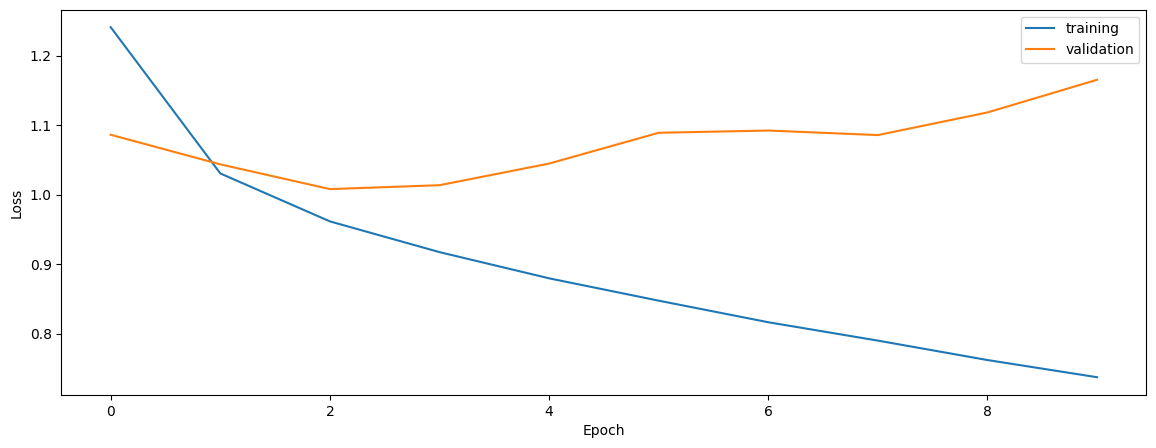

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train


0.6415259172976121
0.599041158478545
0.6101293400176557


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6052369901660055
0.5935241412711423
0.5739575289575289


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6083312397247896
0.6093432845142553
0.5885552246419756


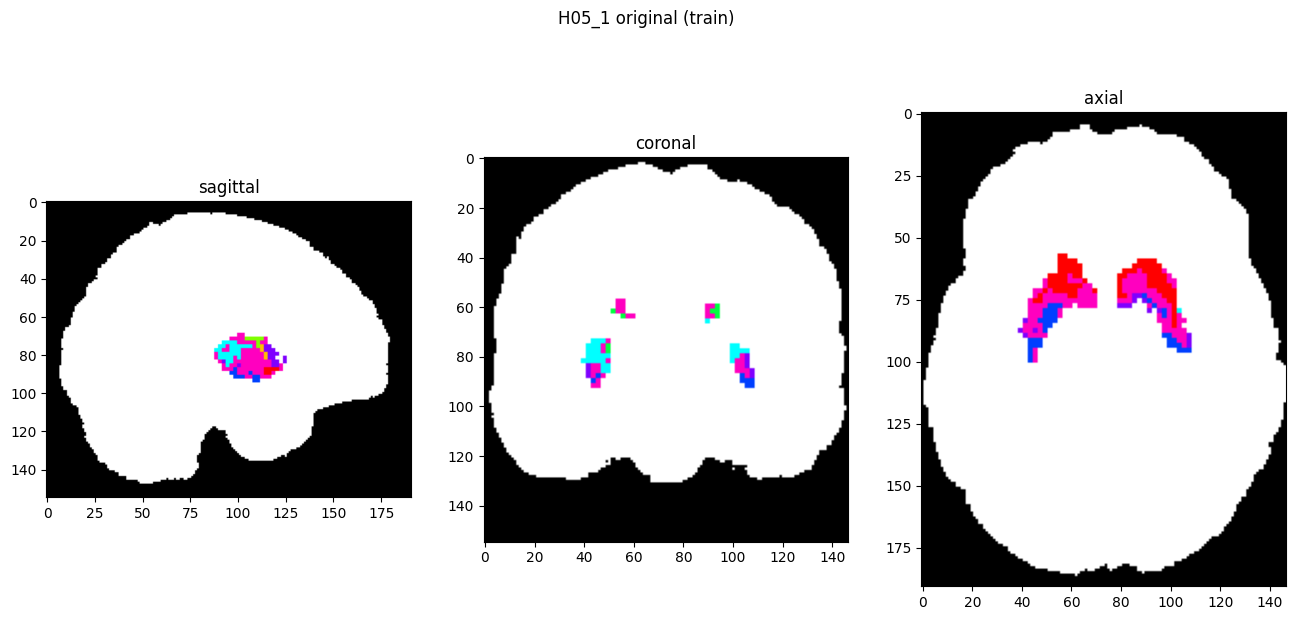

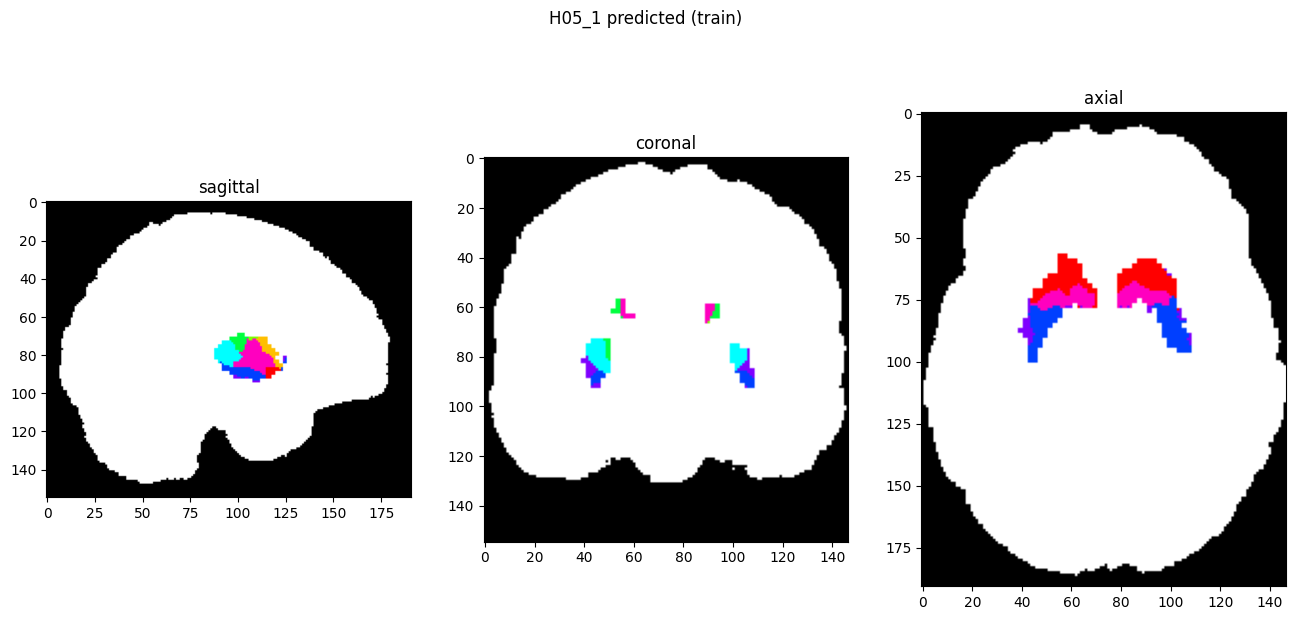

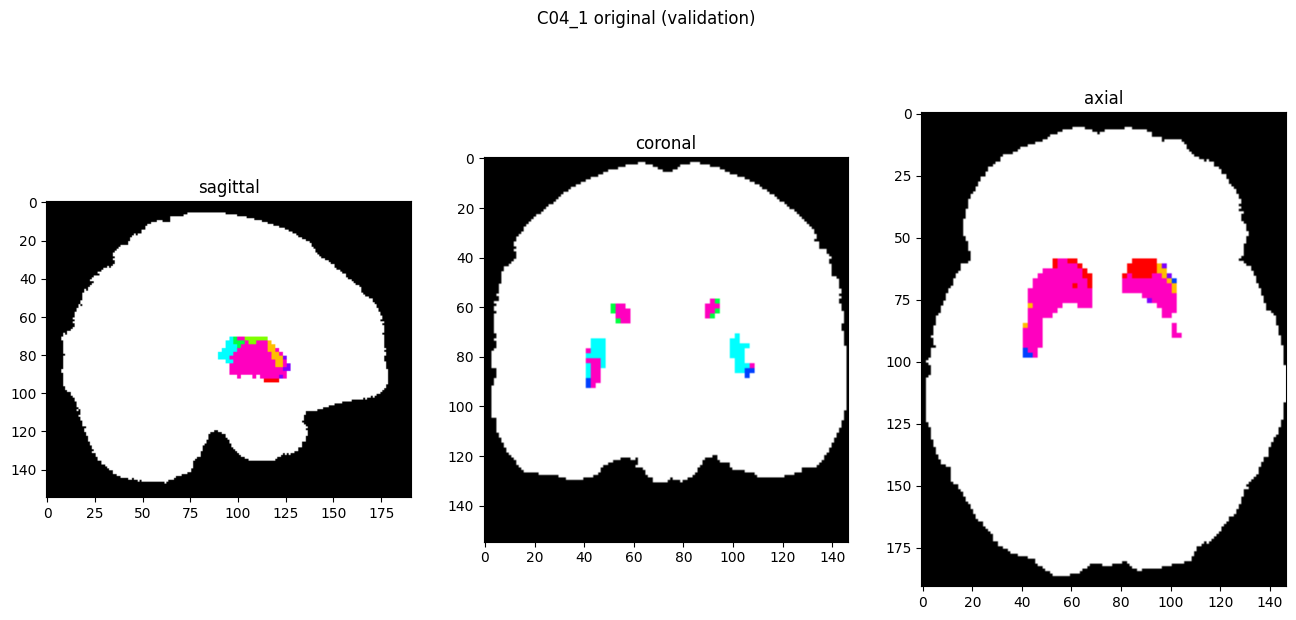

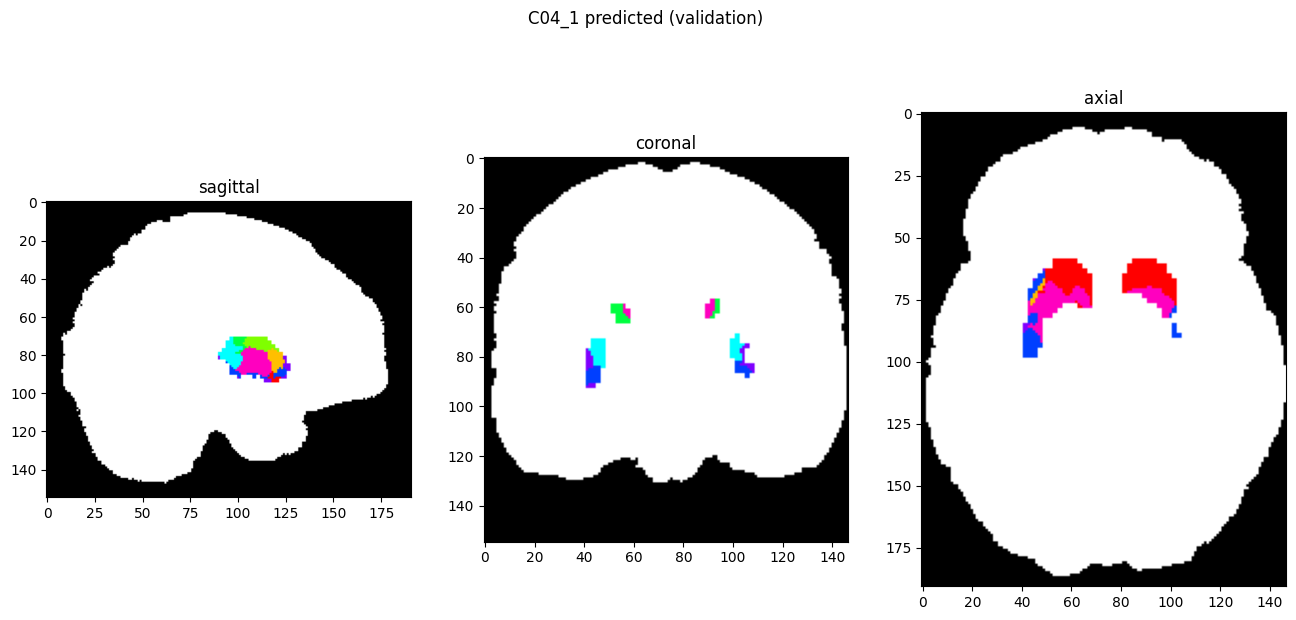

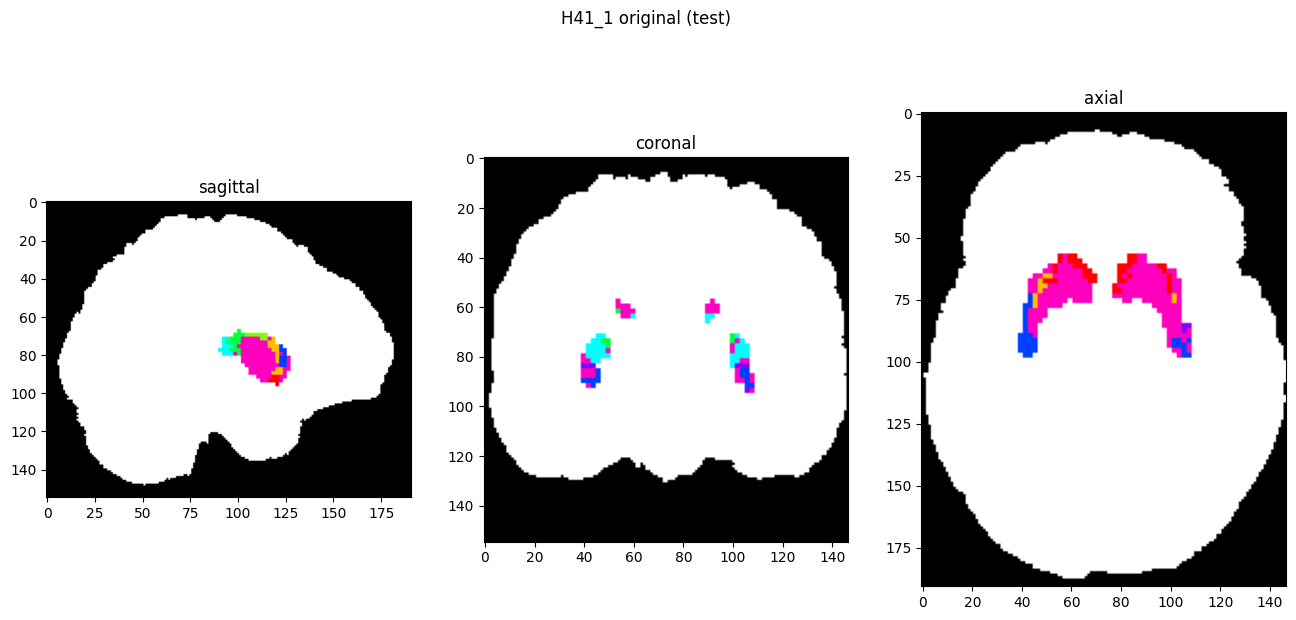

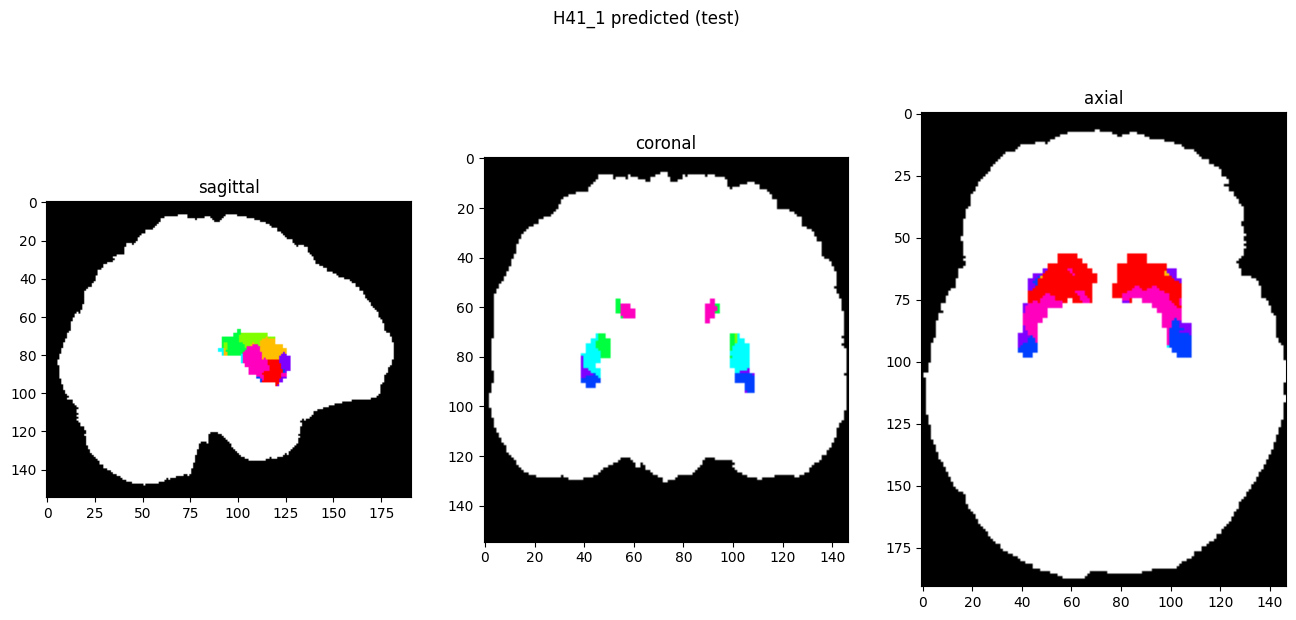

In [10]:
showResults(model, gen, threshold=0)